L'ensemble de données TCGA sur les cancers est un ensemble de données de séquençage d'ARN en vrac qui contient les profils transcriptomiques de patients diagnostiqués avec trois sous-types différents de cancers du rein.
<br>
Le dataset est un ensemble de fichiers JSON.
<br>
<br>
**Statistiques de base :**
* Nombre de lignes : 6883
* Nombre de colonnes : 147
* Valeurs manquantes : ?
<br>
<br>

**Objectif de l'analyse :**
<br>
* Notre objectif principal est de développer un modèle de classification pour le statut de vie des patients.
* Pour cela nous commencerons par regroupper chaque dataset dans un seul au format CSV.
* Ensuite, nous utiliserons plusieurs techniques de classifications.
<br>
<br>

**Sources utilisées :**
<br>

## **Imports**

In [2]:
# pip install scikit-learn, xgboost, catboost, lightgbm, matplotlib, numpy, pandas, seaborn, MiniSom, scikit-optimize
from imblearn.over_sampling import SMOTE

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    davies_bouldin_score,
    f1_score,
    precision_score,
    silhouette_score
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from skopt import BayesSearchCV

from xgboost import XGBClassifier

# !pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# pip install numpy==1.23.5
import numpy as np

# print(np.__version__)

import pandas as pd
import seaborn as sns
import shap

# !pip install MiniSom
from minisom import MiniSom

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## **Lecture des datasets**

In [3]:
dataJSON = pd.read_json(r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA.json")

In [4]:
acc = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-ACC.json"
)

blca = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-BLCA.json"
)

brca = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-BRCA.json"
)

coad = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-COAD.json"
)

gbm = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-GBM.json"
)

hnsc = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-HNSC.json"
)

kich = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-KICH.json"
)

kirc = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-KIRC.json"
)

laml = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-LAML.json"
)

lihc = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-LIHC.json"
)

luad = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-LUAD.json"
)

lusc = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-LUSC.json"
)

ov = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-OV.json"
)

read = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-READ.json"
)

ucec = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-UCEC.json"
)

ucs = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-UCS.json"
)

uvm = pd.read_json(
    r"C:\Users\godai\Documents\BUT\semestre_5\Données massives\TCGA\TCGA-UVM.json"
)

## **Regrouppement des données dans un dataset**

In [5]:
def getValues(list_elems, column = ''):
    values = []
    for elems in list_elems:
        row = {}

        if isinstance(elems, dict):
            for key, value in elems.items():
                row[key] = value

        elif isinstance(elems, list):
            for elem in elems:
                for key, value in elem.items():
                    if isinstance(value, list):
                        next_row = getValues(value)
                        row.update(next_row)

                    else:
                        row[key] = value

        elif isinstance(elems, str):
            row[column] = elems

        values.append(row)

    return pd.DataFrame(values)

In [6]:
def getValuesDiagnoses(list_elem):
    values = []

    for diagnoses in list_elem:
        for diagnose in diagnoses:
            row = {}
            cpt = 1
            for key, value in diagnose.items():

                if isinstance(value, list):
                    for elems in value:
                        for k, v in elems.items():
                            row[k + "_" + str(cpt)] = v
                        cpt += 1

                else:
                    row[key] = value

            values.append(row)

    return pd.DataFrame(values)

In [7]:
def transformToCsv(df):
    values = []

    for column in df.columns:
        if column == 'case_id':
            value = getValues(df[column], 'case_id')
        elif column != 'diagnoses':
            value = getValues(df[column])
        else:
            value = getValuesDiagnoses(df[column])

        values.append(value)

    return pd.concat(values, axis=1)

In [8]:
dataFrame = transformToCsv(pd.DataFrame(dataJSON))
dataFrame = dataFrame.loc[:, ~dataFrame.columns.duplicated()]
display(dataFrame)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                    NaN    Not Reported  2019-07-31T18:13:48.892735-05:00   
1                    NaN    Not Reported  2019-07-31T18:13:45.683420-05:00   
2                    NaN    Not Reported  2019-07-31T18:13:51.863154-05:00   
3                    NaN    Not Reported  2019-07-31T15:14:18.909624-05:00   
4                    NaN    Not Reported  2019-07-31T18:13:55.018419-05:00   
...                  ...             ...                               ...   
6878                 NaN    Not Reported  2019-07-31T16:39:44.817656-05:00   
6879                 NaN    Not Reported  2019-08-01T00:15:42.995359-05:00   
6880                 NaN    Not Reported  2019-07-31T17:26:09.027240-05:00   
6881                 NaN    Not Reported  2019-08-01T00:16:36.663659-05:00   
6882                 NaN    Not Reported  2019-07-31T17:28:18.546032-05:00   

                               exposure_id           submitter_id  \
0     1a917935-2e39-5fa4-933d-d3f39eabf7bb  TCGA-OR-A5LL_exposure   
1     b1702d01-b0de-5aeb-bd32-ef5d2cf03249  TCGA-OR-A5J7_exposure   
2     8b3ee534-818f-5b8a-9eac-454a15cb9ebc  TCGA-P6-A5OG_exposure   
3     1fc49e34-3ffe-5e3b-9430-3bf99b25cc69  TCGA-OR-A5J8_exposure   
4     ff6e2425-d41d-5b80-b69f-5e36d3ef9016  TCGA-OR-A5KB_exposure   
...                                    ...                    ...   
6878  44ca7325-06c3-5560-ac49-eb828bca5130  TCGA-WC-A888_exposure   
6879  fcdfc4a8-80a7-5a35-9862-532298eef655  TCGA-V4-A9ET_exposure   
6880  c0ed5042-5120-5f46-a785-12933b3083de  TCGA-VD-A8K7_exposure   
6881  397720db-70ca-5ad4-83f1-f9a19f8fe13d  TCGA-V4-A9F5_exposure   
6882  a97b047a-21c0-5bae-a1c4-2a82b907b306  TCGA-V4-A9EV_exposure   

      years_smoked     state created_datetime alcohol_intensity  \
0              NaN  released             None              None   
1              NaN  released             None              None   
2              NaN  released             None              None   
3              NaN  released             None              None   
4              NaN  released             None              None   
...            ...       ...              ...               ...   
6878           NaN  released             None              None   
6879           NaN  released             None              None   
6880           NaN  released             None              None   
6881           NaN  released             None              None   
6882           NaN  released             None              None   

      pack_years_smoked  ...  vital_status  age_at_index  days_to_birth  \
0                   NaN  ...          Dead          75.0       -27607.0   
1                   NaN  ...          Dead          30.0       -11279.0   
2                   NaN  ...          Dead          45.0       -16659.0   
3                   NaN  ...          Dead          66.0       -24266.0   
4                   NaN  ...         Alive          61.0       -22550.0   
...                 ...  ...           ...           ...            ...   
6878                NaN  ...          Dead          76.0       -28117.0   
6879                NaN  ...         Alive          57.0       -21113.0   
6880                NaN  ...         Alive          39.0       -14294.0   
6881                NaN  ...         Alive          85.0       -31314.0   
6882                NaN  ...          Dead          59.0       -21855.0   

      year_of_birth                        demographic_id  days_to_death  \
0            1932.0  905acbd5-a5da-5630-b6a0-c9b737138af7         1613.0   
1            1979.0  95dc144c-b5cc-54df-8315-51bc85a1146b          490.0   
2            1966.0  a5957a98-4b3d-5651-a154-8adf70d31771          383.0   
3            1945.0  c7ee293d-87da-5a5a-9121-6963a2a36b25          579.0   
4            1950.0  0e0589ec-863f-5435-8e06-11f27c15727f            NaN   
...             ...                                   ...            ...   
68

## **Autres datasets**

In [9]:
acc_csv = transformToCsv(pd.DataFrame(acc))
display(acc_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                None    Not Reported  2019-07-31T18:13:48.892735-05:00   
1                None    Not Reported  2019-07-31T18:13:45.683420-05:00   
2                None    Not Reported  2019-07-31T18:13:51.863154-05:00   
3                None    Not Reported  2019-07-31T15:14:18.909624-05:00   
4                None    Not Reported  2019-07-31T18:13:55.018419-05:00   
..                ...             ...                               ...   
87               None    Not Reported  2019-07-31T18:15:35.911185-05:00   
88               None    Not Reported  2019-07-31T18:15:40.033489-05:00   
89               None    Not Reported  2019-07-31T15:20:33.463247-05:00   
90               None    Not Reported  2019-07-31T15:17:53.835578-05:00   
91               None    Not Reported  2019-07-31T15:21:10.590674-05:00   

                             exposure_id           submitter_id years_smoked  \
0   1a917935-2e39-5fa4-933d-d3f39eabf7bb  TCGA-OR-A5LL_exposure         None   
1   b1702d01-b0de-5aeb-bd32-ef5d2cf03249  TCGA-OR-A5J7_exposure         None   
2   8b3ee534-818f-5b8a-9eac-454a15cb9ebc  TCGA-P6-A5OG_exposure         None   
3   1fc49e34-3ffe-5e3b-9430-3bf99b25cc69  TCGA-OR-A5J8_exposure         None   
4   ff6e2425-d41d-5b80-b69f-5e36d3ef9016  TCGA-OR-A5KB_exposure         None   
..                                   ...                    ...          ...   
87  fdd3dee8-c5cd-5355-bbbc-d679520d1d95  TCGA-OR-A5K1_exposure         None   
88  ddb97abe-1a36-5df0-86e5-3f3cbe4b88fe  TCGA-OR-A5LG_exposure         None   
89  c14ca2e2-5154-55e3-950e-4ea1af9e5027  TCGA-OR-A5LB_exposure         None   
90  1d1771b6-7e56-5b5b-95d1-8a6c483fed7b  TCGA-OR-A5JM_exposure         None   
91  c5c971bd-0cbb-5194-9fcc-8b1102a2f7ed  TCGA-OR-A5LJ_exposure         None   

       state created_datetime alcohol_intensity  \
0   released             None              None   
1   released             None              None   
2   released             None              None   
3   released             None              None   
4   released             None              None   
..       ...              ...               ...   
87  released             None              None   
88  released             None              None   
89  released             None              None   
90  released             None              None   
91  released             None              None   

                                 case_id  ... age_at_index  \
0   0304b12d-7640-4150-a581-2eea2b1f2ad5  ...           75   
1   075dbfd0-9cf4-4877-884f-ae858902c79e  ...           30   
2   0824b246-9fa2-4a8b-ad4c-1ffc7731bf7d  ...           45   
3   08e0d412-d4d8-4d13-b792-a4dd0bd9ec2b  ...           66   
4   09454ed6-64bc-4a35-af44-7c4344623d45  ...           61   
..                                   ...  ...          ...   
87  f8e77bb6-e521-4a6a-9cb4-4b58ee38ca7f  ...           48   
88  fad4b7e6-510c-4968-83df-3140ed5a0549  ...           46   
89  fb504e55-1859-48ee-aec7-a3fcb082785e  ...           59   
90  fb54458d-c373-46c2-841e-82663e13efaa  ...           25   
91  fc83ab27-929e-4ad4-ba18-abb0694f1e43  ...           54   

                submitter_id  days_to_birth created_datetime  year_of_birth  \
0   TCGA-OR-A5LL_demographic         -27607             None           1932   
1   TCGA-OR-A5J7_demographic         -11279             None           1979   
2   TCGA-P6-A5OG_demographic         -16659             None           1966   
3   TCGA-OR-A5J8_demographic         -24266             None           1945   
4   TCGA-OR-A5KB_demographic         -22550             None           1950   
..                       ...            ...              ...            ...   
87  TCGA-OR-A5K1_demographic         -17596             None           1958   
88  TCGA-OR-A5LG_demographic         -16875             None           1962   
89  TCGA-OR-A5LB_demographic         -21565             None           1

In [10]:
blca_csv = transformToCsv(pd.DataFrame(blca))
display(blca_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0              0.821918    Not Reported  2019-07-31T15:15:49.426257-05:00   
1              2.739726    Not Reported  2019-07-31T17:01:30.392297-05:00   
2                   NaN    Not Reported  2019-07-31T17:18:24.125787-05:00   
3                   NaN    Not Reported  2019-07-31T17:01:33.306181-05:00   
4                   NaN    Not Reported  2019-07-31T17:01:36.199839-05:00   
..                  ...             ...                               ...   
407                 NaN    Not Reported  2019-07-31T17:01:15.956536-05:00   
408            3.068493    Not Reported  2019-07-31T17:01:18.680451-05:00   
409                 NaN    Not Reported  2019-07-31T17:01:21.673907-05:00   
410                 NaN    Not Reported  2019-07-31T17:01:24.718328-05:00   
411            0.164384    Not Reported  2019-07-31T17:01:27.549544-05:00   

                              exposure_id           submitter_id years_smoked  \
0    ec9dc6f1-7f95-5ead-a277-4f172b7f118c  TCGA-BL-A13I_exposure         None   
1    b0e05c8d-317a-5480-9e48-5646995635bd  TCGA-BT-A20N_exposure         None   
2    c82fc363-1bf4-5d6b-b1cc-f0ae73bd9d94  TCGA-LT-A5Z6_exposure         None   
3    454df293-77a5-5772-8f54-fac4b77775bf  TCGA-XF-AAMZ_exposure         None   
4    4e5bc1eb-57b5-51ee-b6b3-0c4daf9273b7  TCGA-XF-AAMX_exposure         None   
..                                    ...                    ...          ...   
407  c923087e-61d7-56ee-8331-021baceb17eb  TCGA-GU-A766_exposure         None   
408  eb4d8da0-afa0-5260-afb3-5d5b770c798a  TCGA-XF-AAN0_exposure         None   
409  19d2d375-7d4b-5199-9c2f-82dec1ca93ff  TCGA-ZF-AA56_exposure         None   
410  817f29e9-9b06-5f89-a536-a40fe14f7f55  TCGA-DK-AA77_exposure         None   
411  edf71766-89b6-5822-a83e-2531f3118e18  TCGA-ZF-A9R9_exposure         None   

        state  created_datetime alcohol_intensity  pack_years_smoked  ...  \
0    released              None              None               15.0  ...   
1    released              None              None               50.0  ...   
2    released              None              None                NaN  ...   
3    released              None              None                NaN  ...   
4    released              None              None                NaN  ...   
..        ...               ...               ...                ...  ...   
407  released              None              None                NaN  ...   
408  released              None              None               56.0  ...   
409  released              None              None                NaN  ...   
410  released              None              None                NaN  ...   
411  released              None              None                3.0  ...   

    age_at_index              submitter_id days_to_birth  created_datetime  \
0             57  TCGA-BL-A13I_demographic      -20885.0              None   
1             72  TCGA-BT-A20N_demographic      -26456.0              None   
2             56  TCGA-LT-A5Z6_demographic      -20746.0              None   
3             81  TCGA-XF-AAMZ_demographic      -29667.0              None   
4             87  TCGA-XF-AAMX_demographic      -31884.0              None   
..           ...                       ...           ...               ...   
407           62  TCGA-GU-A766_demographic      -22774.0              None   
408           68  TCGA-XF-AAN0_demographic      -24877.0              None   
409           79  TCGA-ZF-AA56_demographic      -28937.0              None   
410           61  TCGA-DK-AA77_demographic      -22365.0              None   
411           58  TCGA-ZF-A9R9_demographic      -21491.0              None   

    year_of_birth                        demographic_id  \
0          1953.0  ba9fff81-0ad3-56b5-a9a5-a7f1ad7cd96d   
1          1931.0  19cba497-5f32-5c6a-8ef2-50b0de719c44   
2          1957.0  3cf8c25b-f0a9-58d5-bf88-8bd7b37621f6   
3        

In [11]:
brca_csv = transformToCsv(pd.DataFrame(brca))
display(brca_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                  None    Not Reported  2019-07-31T22:03:21.728232-05:00   
1                  None    Not Reported  2019-07-31T21:15:35.044085-05:00   
2                  None    Not Reported  2019-07-31T22:03:28.232780-05:00   
3                  None    Not Reported  2019-07-31T22:03:31.532597-05:00   
4                  None    Not Reported  2019-07-31T21:21:30.416708-05:00   
...                 ...             ...                               ...   
1092               None    Not Reported  2019-07-31T21:45:21.895282-05:00   
1093               None    Not Reported  2019-07-31T21:57:37.713361-05:00   
1094               None    Not Reported  2019-07-31T21:45:27.738848-05:00   
1095               None    Not Reported  2019-07-31T15:45:55.574767-05:00   
1096               None    Not Reported  2019-07-31T21:21:24.471517-05:00   

                               exposure_id           submitter_id  \
0     c29826be-f033-5b4c-aa85-eb3b632a7891  TCGA-E2-A1L8_exposure   
1     b127ffdc-1e64-52cf-ae8a-0f29581346ac  TCGA-A7-A0D9_exposure   
2     a252e1ce-10f7-5830-9a6b-0f48b0ae5f77  TCGA-E2-A1LG_exposure   
3     38eed29d-b5ec-5f12-a0fc-7e675b62b32d  TCGA-E2-A107_exposure   
4     202a89ba-8f9d-50bc-882d-66a98efbe64c  TCGA-A7-A3RF_exposure   
...                                    ...                    ...   
1092  132f53e6-cadd-5417-ab7b-88ffee865942  TCGA-E2-A1IO_exposure   
1093  bb012f3c-5d96-51db-be4f-2946adeaf0e6  TCGA-AR-A2LR_exposure   
1094  dde6c60e-ddbb-5685-8515-b66a4ce79a12  TCGA-C8-A9FZ_exposure   
1095  6277b89b-9159-5f2d-b20a-7f6b6ee95670  TCGA-BH-A0C1_exposure   
1096  15652c45-2d65-53dd-a8ef-44293bca0f24  TCGA-A8-A07R_exposure   

     years_smoked     state created_datetime alcohol_intensity  \
0            None  released             None              None   
1            None  released             None              None   
2            None  released             None              None   
3            None  released             None              None   
4            None  released             None              None   
...           ...       ...              ...               ...   
1092         None  released             None              None   
1093         None  released             None              None   
1094         None  released             None              None   
1095         None  released             None              None   
1096         None  released             None              None   

                                   case_id  ... age_at_index  \
0     eebad74f-5961-4e91-b0eb-157a2f6f952b  ...           52   
1     17baef7c-d97d-4b98-ab53-503ef856523d  ...           37   
2     ef4cbd38-bc79-4d60-a715-647edd2ebe9e  ...           50   
3     eff2360e-399a-4167-ab2b-798e27bef739  ...           54   
4     7451af3c-acc0-4d79-8429-6b8be96911d8  ...           79   
...                                    ...  ...          ...   
1092  71fc8941-4cfb-47ea-a533-873d38f8c95c  ...           37   
1093  d093173f-08ab-4138-bf3c-399c45a6e163  ...           49   
1094  726c6892-0dce-4869-a7a7-cc44c26fe843  ...           49   
1095  d10a4887-373b-4726-a61d-126f950e4a06  ...           61   
1096  72e486b8-a866-4916-b2e4-8b4bb5dcd92d  ...           80   

                  submitter_id  days_to_birth created_datetime  year_of_birth  \
0     TCGA-E2-A1L8_demographic       -19187.0             None         1956.0   
1     TCGA-A7-A0D9_demographic       -13836.0             None         1972.0   
2     TCGA-E2-A1LG_demographic       -18492.0             None         1960.0   
3     TCGA-E2-A107_demographic       -20065.0             None         1954.0   
4     TCGA-A7-A3RF_demographic       -29184.0             None         1933.0   
...                        ...            ...              ...            ...   
1092  TCGA-E2-A1IO_demographic       -13671.0             None         1972.0   
1093  TCGA-AR-A2LR_demographic       -182

In [12]:
coad_csv = transformToCsv(pd.DataFrame(coad))
display(coad_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                 None    Not Reported  2019-07-31T18:22:16.240216-05:00   
1                 None    Not Reported  2019-07-31T18:22:19.487538-05:00   
2                 None    Not Reported  2019-07-31T18:22:22.240264-05:00   
3                 None    Not Reported  2019-07-31T18:22:25.357970-05:00   
4                 None    Not Reported  2019-07-31T18:22:28.241053-05:00   
..                 ...             ...                               ...   
454               None    Not Reported  2019-07-31T18:41:09.062845-05:00   
455               None    Not Reported  2019-07-31T18:41:12.243393-05:00   
456               None    Not Reported  2019-07-31T18:41:15.434480-05:00   
457               None    Not Reported  2019-07-31T18:41:18.132336-05:00   
458               None    Not Reported  2019-07-31T15:17:59.324160-05:00   

                              exposure_id           submitter_id years_smoked  \
0    7b3a315f-2cc1-5aee-9ed4-7a951fe26905  TCGA-F4-6854_exposure         None   
1    90596be3-bf9e-5f31-a69e-8bb6fe889a1d  TCGA-AA-3561_exposure         None   
2    d4a3248f-a192-5d85-94a8-fc669d6608e5  TCGA-AA-A00O_exposure         None   
3    4b6821bc-9560-5b24-b97a-b4e282a85e82  TCGA-DM-A28F_exposure         None   
4    1a562036-305d-54c7-893f-4c9637eee4cc  TCGA-AA-3866_exposure         None   
..                                    ...                    ...          ...   
454  ed9d48a7-3d41-52e0-a3e6-de5c6d93dc63  TCGA-CM-6675_exposure         None   
455  a04712cd-50c6-5b75-bf7a-62964e4b1869  TCGA-AA-3556_exposure         None   
456  32d0bc1d-f24d-5995-9c6a-bc1c45a92862  TCGA-AA-3818_exposure         None   
457  934a2072-7e68-5753-9d53-69f9424e1d7b  TCGA-A6-2680_exposure         None   
458  79d5c82c-8d3f-522f-a022-737eeb31dcf5  TCGA-DM-A28G_exposure         None   

        state created_datetime alcohol_intensity  \
0    released             None              None   
1    released             None              None   
2    released             None              None   
3    released             None              None   
4    released             None              None   
..        ...              ...               ...   
454  released             None              None   
455  released             None              None   
456  released             None              None   
457  released             None              None   
458  released             None              None   

                                  case_id  ... age_at_index  \
0    01240896-3f3f-4bf9-9799-55c87bfacf36  ...           77   
1    01ad5016-f691-4bca-82a0-910429d8d25b  ...           72   
2    01f493d4-229d-47a6-baa8-32a342c65d01  ...           83   
3    022f39e9-57ee-4b2b-8b3a-8929e3d69a37  ...           73   
4    02f9668c-71e6-485f-88b1-b37dc8bdd2ab  ...           78   
..                                    ...  ...          ...   
454  fce1fd5a-54d2-4260-b187-4eb7035e96e9  ...           35   
455  fd16b634-2e04-44a3-862d-fb03cd73c057  ...           78   
456  fdffda5f-72b2-4153-b7f1-d7043b7ca898  ...           78   
457  ff1407c6-9174-4bae-a19b-d34ca71b898c  ...           72   
458  ffa7e03a-4a3c-41f0-937a-4fb862fd2194  ...           75   

                 submitter_id  days_to_birth created_datetime  year_of_birth  \
0    TCGA-F4-6854_demographic       -28272.0             None           1934   
1    TCGA-AA-3561_demographic       -26420.0             None           1937   
2    TCGA-AA-A00O_demographic       -30316.0             None           1925   
3    TCGA-DM-A28F_demographic       -26856.0             None           1929   
4    TCGA-AA-3866_demographic       -28672.0             None           1928   
..                        ...            ...              ...            ...   
454  TCGA-CM-6675_demographic       -12935.0             None           1976   
455  TCGA-AA-3556_demographic       -28704.0             None           1930   
456  TCGA-AA-381

In [13]:
gbm_csv = transformToCsv(pd.DataFrame(gbm))
display(gbm_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                 None    Not Reported  2019-07-31T22:37:15.735436-05:00   
1                 None    Not Reported  2019-07-31T22:37:18.827175-05:00   
2                 None    Not Reported  2019-07-31T22:37:21.903189-05:00   
3                 None    Not Reported  2019-07-31T22:37:24.914509-05:00   
4                 None    Not Reported  2019-07-31T22:37:28.059308-05:00   
..                 ...             ...                               ...   
594               None    Not Reported  2019-07-31T22:52:23.945509-05:00   
595               None    Not Reported  2019-07-31T15:51:30.725529-05:00   
596               None    Not Reported  2019-07-31T22:52:27.102477-05:00   
597               None    Not Reported  2019-07-31T22:52:30.286790-05:00   
598               None    Not Reported  2019-07-31T22:52:33.249386-05:00   

                              exposure_id           submitter_id years_smoked  \
0    1230cb60-05f0-51b7-834a-cc880a802e6d  TCGA-14-1034_exposure         None   
1    2f22906f-9e21-50a0-8639-9b28a07723e6  TCGA-06-0133_exposure         None   
2    660b9b63-60ad-5918-9325-b745fcbcf108  TCGA-06-0140_exposure         None   
3    4ce27317-6d8a-52f9-8874-61577e6dbbea  TCGA-06-0171_exposure         None   
4    a003dcac-d40e-57cf-9a9f-9f405faebef0  TCGA-06-0402_exposure         None   
..                                    ...                    ...          ...   
594  4db344f5-f69d-59dc-b541-3e1474b59393  TCGA-06-0216_exposure         None   
595  58217592-0eee-5da9-9611-0a7c18945b87  TCGA-41-6646_exposure         None   
596  72847f96-5d9b-59b6-860e-7f81d03aaaa7  TCGA-14-1453_exposure         None   
597  ab0be56d-5453-5db9-a7d7-8f3f9e4e01f2  TCGA-06-0414_exposure         None   
598  2bc9f6d1-a9e5-5229-b0b0-b269e373ef7c  TCGA-02-0446_exposure         None   

        state  created_datetime alcohol_intensity  alcohol_days_per_week  ...  \
0    released              None              None                    NaN  ...   
1    released              None              None                    NaN  ...   
2    released              None              None                    NaN  ...   
3    released              None              None                    NaN  ...   
4    released              None              None                    NaN  ...   
..        ...               ...               ...                    ...  ...   
594  released              None              None                    NaN  ...   
595  released              None              None                    NaN  ...   
596  released              None              None                    NaN  ...   
597  released              None              None                    NaN  ...   
598  released              None              None                    NaN  ...   

     created_datetime  year_of_birth                        demographic_id  \
0                None         1939.0  e5726d82-754f-58c2-9240-6770df1d6149   
1                None         1943.0  1d9d6fb0-2b01-5e38-a05b-879f830bb52c   
2                None         1917.0  f3014ecf-07aa-581a-a454-eb64d3f05bef   
3                None         1937.0  aad029fa-889d-56c0-abba-0fc65c3251d5   
4                None         1922.0  89f17ab1-dfb6-5596-b6d2-6633aeaaaeb2   
..                ...            ...                                   ...   
594              None         1938.0  3d3765a2-73f4-5aa7-948a-9edb569cccc9   
595              None         1938.0  ee70946d-9ef6-50f3-8c47-8db91326f6b0   
596              None         1936.0  5d65a8b2-9550-58c8-8346-b2054bdee6a7   
597              None         1933.0  9e128bb3-bf95-53a8-9d76-be1206904fda   
598              None         1936.0  a7756dd0-dc53-5062-a880-2fc64946ff50   

                     updated_datetime  days_to_death     state  year_of_death  \
0    2019-07-31T22:37:15.735436-05:00          485.0  released         2000.0   
1    2019-07-31T22:37:18.827175-05:00         

In [14]:
hnsc_csv = transformToCsv(pd.DataFrame(hnsc))
display(hnsc_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                   NaN             Yes  2019-07-31T18:13:07.116555-05:00   
1                   NaN              No  2019-07-31T18:13:10.280378-05:00   
2              2.191781             Yes  2019-07-31T18:13:13.604705-05:00   
3              2.191781              No  2019-07-31T18:13:16.799913-05:00   
4              1.643836              No  2019-07-31T19:32:46.185248-05:00   
..                  ...             ...                               ...   
523                 NaN             Yes  2019-07-31T19:47:57.611267-05:00   
524            0.027397             Yes  2019-07-31T19:48:00.586105-05:00   
525                 NaN             Yes  2019-07-31T19:48:03.490635-05:00   
526            1.917808             Yes  2019-07-31T19:48:06.540477-05:00   
527            2.739726             Yes  2019-07-31T19:48:09.943691-05:00   

                              exposure_id           submitter_id  \
0    2a33510f-d0b7-5322-b7dc-0fc326938526  TCGA-BA-5152_exposure   
1    ac8f27d7-452f-5942-bdb8-dd2c058ace10  TCGA-CQ-5329_exposure   
2    3ef915d8-ff87-5d53-8886-cabc4df16fc6  TCGA-BB-A5HY_exposure   
3    4bfa29f0-5a6f-5f18-ba8d-e5841e322b26  TCGA-CN-6998_exposure   
4    e6758eea-31bd-52fc-aa5e-6a5204aa5afb  TCGA-CR-7392_exposure   
..                                    ...                    ...   
523  af7cbe56-e78e-5d67-9ff6-c136781d81aa  TCGA-BB-A5HZ_exposure   
524  29bd28ae-e368-5ab0-968d-d236098d66bd  TCGA-DQ-7590_exposure   
525  e7993aee-0f1c-592c-82a5-53fd83ce3a95  TCGA-CR-7365_exposure   
526  8cb142ce-e213-5813-8aa4-5d8c766dae77  TCGA-CR-5248_exposure   
527  8150283d-965f-5c09-9dac-3fb2c68c29d6  TCGA-CR-6492_exposure   

     years_smoked     state  created_datetime alcohol_intensity  \
0             NaN  released              None              None   
1             NaN  released              None              None   
2             NaN  released              None              None   
3             NaN  released              None              None   
4            20.0  released              None              None   
..            ...       ...               ...               ...   
523           NaN  released              None              None   
524           2.0  released              None              None   
525           NaN  released              None              None   
526           NaN  released              None              None   
527           NaN  released              None              None   

     pack_years_smoked  ... age_at_index              submitter_id  \
0                  NaN  ...         56.0  TCGA-BA-5152_demographic   
1                  NaN  ...         46.0  TCGA-CQ-5329_demographic   
2                 40.0  ...         64.0  TCGA-BB-A5HY_demographic   
3                 40.0  ...         53.0  TCGA-CN-6998_demographic   
4                 30.0  ...         67.0  TCGA-CR-7392_demographic   
..                 ...  ...          ...                       ...   
523                NaN  ...         65.0  TCGA-BB-A5HZ_demographic   
524                0.5  ...         51.0  TCGA-DQ-7590_demographic   
525                NaN  ...         60.0  TCGA-CR-7365_demographic   
526               35.0  ...         53.0  TCGA-CR-5248_demographic   
527               50.0  ...         78.0  TCGA-CR-6492_demographic   

    days_to_birth  created_datetime year_of_birth  \
0        -20783.0              None        1953.0   
1        -17028.0              None        1962.0   
2        -23640.0              None        1948.0   
3        -19447.0              None        1958.0   
4        -24650.0              None        1942.0   
..            ...               ...           ...   
523      -23906.0              None        1947.0   
524      -18718.0              None        1959.0   
525      -22101.0              None        1948.0   
526      -19441.0              None        1953.0   
527      -28600.0              Non

In [15]:
kich_csv = transformToCsv(pd.DataFrame(kich))
display(kich_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                   NaN    Not Reported  2019-07-31T18:09:55.178657-05:00   
1              0.054795    Not Reported  2019-07-31T15:54:01.407165-05:00   
2              1.917808    Not Reported  2019-07-31T18:10:13.405100-05:00   
3                   NaN    Not Reported  2019-07-31T18:10:04.335742-05:00   
4              0.164384    Not Reported  2019-07-31T15:46:58.553816-05:00   
..                  ...             ...                               ...   
108            0.547945    Not Reported  2019-07-31T18:12:11.013831-05:00   
109                 NaN    Not Reported  2019-07-31T16:10:37.185099-05:00   
110                 NaN    Not Reported  2019-07-31T18:12:46.112049-05:00   
111                 NaN    Not Reported  2019-07-31T15:58:24.981591-05:00   
112                 NaN    Not Reported  2019-07-31T18:13:01.238674-05:00   

                              exposure_id           submitter_id  \
0    4b0475fe-52f6-580e-8ff2-ec0c2867d599  TCGA-KN-8431_exposure   
1    4c86adb6-511d-55da-8cd7-6f0a068783a7  TCGA-KL-8324_exposure   
2    2a3a9edf-dd51-5c2f-8c65-702dcbacd925  TCGA-KL-8330_exposure   
3    911eb22a-5e4a-569c-a3eb-672905b2f923  TCGA-KM-A7QK_exposure   
4    15fb789e-c9f6-59b1-829f-3cc167ff63e7  TCGA-KO-8409_exposure   
..                                    ...                    ...   
108  0b5ecc42-aee2-5d82-bca5-e866d84b0e2b  TCGA-UW-A7GX_exposure   
109  11695b22-1b3f-5c7e-b459-06c44eb12f92  TCGA-NP-A5H1_exposure   
110  d768137a-17b5-524f-a12d-6c23a442d03f  TCGA-KN-8436_exposure   
111  48925609-aa2c-597f-8ed8-0316128e3c53  TCGA-KN-8434_exposure   
112  5282d3ed-bb2f-508c-b45f-e69e22b7a594  TCGA-KM-A7QE_exposure   

     years_smoked     state  created_datetime alcohol_intensity  \
0             NaN  released              None              None   
1             NaN  released              None              None   
2             NaN  released              None              None   
3             NaN  released              None              None   
4             6.0  released              None              None   
..            ...       ...               ...               ...   
108           NaN  released              None              None   
109           NaN  released              None              None   
110           NaN  released              None              None   
111           NaN  released              None              None   
112           NaN  released              None              None   

     pack_years_smoked  ... age_at_index              submitter_id  \
0                  NaN  ...           35  TCGA-KN-8431_demographic   
1                  1.0  ...           67  TCGA-KL-8324_demographic   
2                 35.0  ...           44  TCGA-KL-8330_demographic   
3                  NaN  ...           53  TCGA-KM-A7QK_demographic   
4                  3.0  ...           69  TCGA-KO-8409_demographic   
..                 ...  ...          ...                       ...   
108               10.0  ...           45  TCGA-UW-A7GX_demographic   
109                NaN  ...           66  TCGA-NP-A5H1_demographic   
110                NaN  ...           62  TCGA-KN-8436_demographic   
111                NaN  ...           65  TCGA-KN-8434_demographic   
112                NaN  ...           59  TCGA-KM-A7QE_demographic   

    days_to_birth  created_datetime year_of_birth  \
0          -13043              None          1972   
1          -24650              None          1933   
2          -16250              None          1959   
3          -19486              None          1959   
4          -25419              None          1935   
..            ...               ...           ...   
108        -16782              None          1966   
109        -24299              None          1945   
110        -22997              None          1947   
111        -23934              None          1944   
112        -21580              Non

In [16]:
kirc_csv = transformToCsv(pd.DataFrame(kirc))
display(kirc_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                   NaN    Not Reported  2019-07-31T23:02:55.053486-05:00   
1              1.808219    Not Reported  2019-07-31T23:02:58.215444-05:00   
2                   NaN    Not Reported  2019-07-31T23:03:01.276935-05:00   
3                   NaN    Not Reported  2019-07-31T23:03:07.503085-05:00   
4                   NaN    Not Reported  2019-07-31T23:03:10.838892-05:00   
..                  ...             ...                               ...   
532                 NaN    Not Reported  2019-07-31T23:29:37.718100-05:00   
533                 NaN    Not Reported  2019-07-31T23:10:27.848554-05:00   
534                 NaN    Not Reported  2019-07-31T23:10:30.924622-05:00   
535                 NaN    Not Reported  2019-07-31T23:29:44.143816-05:00   
536                 NaN    Not Reported  2019-07-31T23:29:47.154057-05:00   

                              exposure_id           submitter_id  \
0    b397625e-d855-5375-990b-8bc2b1f9d611  TCGA-B0-5088_exposure   
1    2c9f1350-8dee-5864-a3fc-85aee8dba9d5  TCGA-DV-A4W0_exposure   
2    6b2e1916-9c5d-57c5-bc98-041f5378e52b  TCGA-BP-4162_exposure   
3    83af06eb-8b8d-5121-851e-a46d8ea3d309  TCGA-BP-4759_exposure   
4    bd790021-d595-514b-87fe-28113d0cb5fe  TCGA-BP-4352_exposure   
..                                    ...                    ...   
532  13394585-9056-5c0b-b7a6-29e16fb0f41f  TCGA-B0-4815_exposure   
533  e5c660b3-89e9-51a0-aa50-7ccc8cffc231  TCGA-CZ-5985_exposure   
534  a966fe47-76ee-596e-8b39-91c288cfd9e6  TCGA-A3-3336_exposure   
535  1ffc18a3-ad19-5a17-a84c-8b240cd3e4d4  TCGA-BP-5190_exposure   
536  a943b6c2-c259-551f-ada2-5786c3aa362f  TCGA-BP-4790_exposure   

     years_smoked     state  created_datetime alcohol_intensity  \
0             NaN  released              None              None   
1             NaN  released              None              None   
2             NaN  released              None              None   
3             NaN  released              None              None   
4             NaN  released              None              None   
..            ...       ...               ...               ...   
532           NaN  released              None              None   
533           NaN  released              None              None   
534           NaN  released              None              None   
535           NaN  released              None              None   
536           NaN  released              None              None   

     pack_years_smoked  ... age_at_index              submitter_id  \
0                  NaN  ...           53  TCGA-B0-5088_demographic   
1                 33.0  ...           55  TCGA-DV-A4W0_demographic   
2                  NaN  ...           65  TCGA-BP-4162_demographic   
3                  NaN  ...           50  TCGA-BP-4759_demographic   
4                  NaN  ...           74  TCGA-BP-4352_demographic   
..                 ...  ...          ...                       ...   
532                NaN  ...           65  TCGA-B0-4815_demographic   
533                NaN  ...           58  TCGA-CZ-5985_demographic   
534                NaN  ...           75  TCGA-A3-3336_demographic   
535                NaN  ...           61  TCGA-BP-5190_demographic   
536                NaN  ...           76  TCGA-BP-4790_demographic   

    days_to_birth  created_datetime year_of_birth  \
0        -19677.0              None          1953   
1        -20101.0              None          1953   
2        -23966.0              None          1937   
3        -18569.0              None          1954   
4        -27253.0              None          1933   
..            ...               ...           ...   
532      -23873.0              None          1936   
533      -21242.0              None          1948   
534      -27538.0              None          1932   
535      -22285.0              None          1946   
536      -28076.0              Non

In [17]:
laml_csv = transformToCsv(pd.DataFrame(laml))
display(laml_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                 None    Not Reported  2019-07-31T20:01:40.584333-05:00   
1                 None    Not Reported  2019-07-31T20:01:43.475136-05:00   
2                 None    Not Reported  2019-07-31T20:01:46.288070-05:00   
3                 None    Not Reported  2019-07-31T20:01:49.331765-05:00   
4                 None    Not Reported  2019-07-31T20:01:52.349915-05:00   
..                 ...             ...                               ...   
195               None    Not Reported  2019-07-31T20:06:06.049798-05:00   
196               None    Not Reported  2019-07-31T20:06:09.040650-05:00   
197               None    Not Reported  2019-07-31T20:06:11.917396-05:00   
198               None    Not Reported  2019-07-31T20:06:14.625566-05:00   
199               None    Not Reported  2019-07-31T20:06:17.651905-05:00   

                              exposure_id           submitter_id years_smoked  \
0    8aeebfa8-de8d-5542-986d-3de1d82a9be0  TCGA-AB-2823_exposure         None   
1    423f5d51-7e48-5350-a80e-eea924a3c779  TCGA-AB-2820_exposure         None   
2    98fdc1c6-c488-5f37-a5b3-96e9e23d06d2  TCGA-AB-2853_exposure         None   
3    d673a1df-aaf5-5e09-b99f-c35920f9ce84  TCGA-AB-2893_exposure         None   
4    5b15ea83-80e8-5a47-80d3-adf334897c73  TCGA-AB-2919_exposure         None   
..                                    ...                    ...          ...   
195  d031f326-8382-5688-af41-addb5744ba69  TCGA-AB-2947_exposure         None   
196  926b4718-4583-5879-bbf3-768876089543  TCGA-AB-2974_exposure         None   
197  4498469c-4274-51d8-b50e-f52e308e9ce7  TCGA-AB-2884_exposure         None   
198  cb7ba5b8-9e08-5c14-a32a-d1e9e96b773c  TCGA-AB-2875_exposure         None   
199  7665499c-43ce-5e67-96c7-cdb8508ae25a  TCGA-AB-2881_exposure         None   

        state created_datetime alcohol_intensity  \
0    released             None              None   
1    released             None              None   
2    released             None              None   
3    released             None              None   
4    released             None              None   
..        ...              ...               ...   
195  released             None              None   
196  released             None              None   
197  released             None              None   
198  released             None              None   
199  released             None              None   

                                  case_id  ... age_at_index  \
0    a05e93e6-ad8b-4893-b27d-c9cd329ad564  ...           61   
1    a086aba1-0df5-497b-85e7-bc84aac1acec  ...           76   
2    a24d14d9-4f17-4625-93d0-b0624610d83d  ...           51   
3    a2aee2ef-c3c6-4832-bc3f-3648575af5c6  ...           45   
4    a42bc793-f21d-45d1-9ab3-bfa9de25612e  ...           54   
..                                    ...  ...          ...   
195  fef46ade-e2a8-430e-9e6b-65da64baf266  ...           52   
196  ff7839bb-176e-4483-ac6e-7fae9f6e2e54  ...           67   
197  ffc73551-55e9-4bbb-bd15-76088551964b  ...           44   
198  ffc915b8-cacd-4974-a040-ee496f0efc0e  ...           43   
199  fff35c80-88cd-4923-80c1-0273ba5bed0f  ...           48   

                 submitter_id days_to_birth created_datetime  year_of_birth  \
0    TCGA-AB-2823_demographic        -22522             None           1945   
1    TCGA-AB-2820_demographic        -27971             None           1927   
2    TCGA-AB-2853_demographic        -18720             None           1952   
3    TCGA-AB-2893_demographic        -16617             None           1961   
4    TCGA-AB-2919_demographic        -19724             None           1955   
..                        ...           ...              ...            ...   
195  TCGA-AB-2947_demographic        -19146             None           1957   
196  TCGA-AB-2974_demographic        -24715             None           1940   
197  TCGA-AB-2884_demogra

In [18]:
lihc_csv = transformToCsv(pd.DataFrame(lihc))
display(lihc_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                 None    Not Reported  2019-07-31T20:54:52.590036-05:00   
1                 None    Not Reported  2019-07-31T20:54:55.471937-05:00   
2                 None    Not Reported  2019-07-31T20:54:58.500435-05:00   
3                 None    Not Reported  2019-07-31T20:55:01.442696-05:00   
4                 None    Not Reported  2019-07-31T20:55:04.437111-05:00   
..                 ...             ...                               ...   
372               None    Not Reported  2019-07-31T21:13:03.598079-05:00   
373               None    Not Reported  2019-07-31T21:13:07.232301-05:00   
374               None    Not Reported  2019-07-31T21:13:10.158131-05:00   
375               None    Not Reported  2019-07-31T21:13:13.164558-05:00   
376               None    Not Reported  2019-07-31T21:13:16.604718-05:00   

                              exposure_id           submitter_id years_smoked  \
0    a68e51b7-257b-5a90-8f9e-1987e84e6d5d  TCGA-DD-AAVP_exposure         None   
1    c312839a-dc00-55b3-9d04-e62615b8f37b  TCGA-DD-A4NP_exposure         None   
2    0ff45015-ede3-5356-b53c-a057aa23f454  TCGA-BC-4073_exposure         None   
3    3b1a1f7b-dd0d-54d6-a403-58b6933ac0bb  TCGA-MI-A75E_exposure         None   
4    b388ba9f-221f-516e-ad70-d51b4113f476  TCGA-G3-A7M8_exposure         None   
..                                    ...                    ...          ...   
372  2aa84999-cc4a-5514-b63a-6f12806db3eb  TCGA-G3-A25T_exposure         None   
373  40f55306-808f-5478-90b5-7e6259dd1cac  TCGA-UB-A7MC_exposure         None   
374  17f0daa7-93f0-59c5-8ab3-2dfa2d3fa3c7  TCGA-GJ-A3OU_exposure         None   
375  ec6afbbd-9c67-5220-9daf-f5c31ca2b925  TCGA-DD-AAEH_exposure         None   
376  5c964e32-8c79-5a1a-8fcd-bab943fb1069  TCGA-KR-A7K2_exposure         None   

        state created_datetime alcohol_intensity  \
0    released             None              None   
1    released             None              None   
2    released             None              None   
3    released             None              None   
4    released             None              None   
..        ...              ...               ...   
372  released             None              None   
373  released             None              None   
374  released             None              None   
375  released             None              None   
376  released             None              None   

                                  case_id  ... age_at_index  \
0    0004d251-3f70-4395-b175-c94c2f5b1b81  ...         48.0   
1    001887aa-36d0-463f-8bca-dec7043b4f2e  ...         32.0   
2    00f209c3-041a-4c6e-8b0f-6383eb3c85fc  ...         73.0   
3    010d5817-9a3f-4a06-8643-653116c044ff  ...         61.0   
4    01cc571c-a47c-4548-9c14-5e51c79b095b  ...         31.0   
..                                    ...  ...          ...   
372  f6e5979d-d6a9-4408-bd1b-1b37d1064e83  ...         45.0   
373  f82aff25-0725-48d1-aefd-d60800f7d1ab  ...         59.0   
374  fb2abc2a-ecf1-4184-912f-26a649f861ff  ...         59.0   
375  fbb0e4bc-5398-4a7e-963c-86ea1108a2de  ...         73.0   
376  fbb398fe-2ba8-4845-8083-6533ecb4a52e  ...         64.0   

                 submitter_id  days_to_birth created_datetime  year_of_birth  \
0    TCGA-DD-AAVP_demographic       -17833.0             None         1959.0   
1    TCGA-DD-A4NP_demographic       -11838.0             None         1973.0   
2    TCGA-BC-4073_demographic       -26795.0             None         1936.0   
3    TCGA-MI-A75E_demographic       -22457.0             None         1952.0   
4    TCGA-G3-A7M8_demographic       -11527.0             None         1982.0   
..                        ...            ...              ...            ...   
372  TCGA-G3-A25T_demographic       -16461.0             None         1962.0   
373  TCGA-UB-A7MC_demographic       -21733.0             None         1954.0   
374  TCGA-GJ-A3O

In [19]:
luad_csv = transformToCsv(pd.DataFrame(luad))
display(luad_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0              1.643836    Not Reported  2019-07-31T20:06:20.843697-05:00   
1                   NaN    Not Reported  2019-07-31T20:06:23.723488-05:00   
2                   NaN    Not Reported  2019-07-31T20:06:26.519547-05:00   
3                   NaN    Not Reported  2019-07-31T15:22:17.316596-05:00   
4                   NaN    Not Reported  2019-07-31T20:06:29.391814-05:00   
..                  ...             ...                               ...   
517            2.465753    Not Reported  2019-07-31T20:44:01.197502-05:00   
518            1.917808    Not Reported  2019-07-31T20:44:04.076020-05:00   
519            3.506849    Not Reported  2019-07-31T20:44:06.783198-05:00   
520                 NaN    Not Reported  2019-07-31T20:44:09.895343-05:00   
521            1.643836    Not Reported  2019-07-31T20:28:36.765567-05:00   

                              exposure_id           submitter_id  \
0    507257be-f92e-5764-9f26-321105f4d871  TCGA-62-A471_exposure   
1    22f1b1fc-e35b-54f5-890d-34c2d4a6edad  TCGA-67-3773_exposure   
2    2c7444ec-bda2-5114-b36c-08ca4db90524  TCGA-NJ-A7XG_exposure   
3    c601ba5b-192c-5dc4-9515-5486ee14c1a0  TCGA-91-6848_exposure   
4    2d802058-cd51-5d81-b522-97cd56503224  TCGA-55-6986_exposure   
..                                    ...                    ...   
517  591b4ddf-17b3-5789-8ae1-b1f4f5d717b0  TCGA-64-5774_exposure   
518  11a0c215-9075-55a2-8912-e7a9c6076257  TCGA-78-7220_exposure   
519  4d45ef29-28bc-5123-9c5b-b3e03beaae45  TCGA-78-7167_exposure   
520  e4e2a3a2-7ecc-5e71-bae7-c533ef60c5c6  TCGA-55-8616_exposure   
521  6418b64c-943d-5ef0-9039-09d5b2317d25  TCGA-44-4112_exposure   

     years_smoked     state  created_datetime alcohol_intensity  \
0             NaN  released              None              None   
1             NaN  released              None              None   
2             NaN  released              None              None   
3             NaN  released              None              None   
4             NaN  released              None              None   
..            ...       ...               ...               ...   
517          45.0  released              None              None   
518           NaN  released              None              None   
519           NaN  released              None              None   
520           NaN  released              None              None   
521          20.0  released              None              None   

     pack_years_smoked  ... age_at_index              submitter_id  \
0                 30.0  ...         64.0  TCGA-62-A471_demographic   
1                  NaN  ...         84.0  TCGA-67-3773_demographic   
2                  NaN  ...         49.0  TCGA-NJ-A7XG_demographic   
3                  NaN  ...         59.0  TCGA-91-6848_demographic   
4                  NaN  ...         74.0  TCGA-55-6986_demographic   
..                 ...  ...          ...                       ...   
517               45.0  ...         60.0  TCGA-64-5774_demographic   
518               35.0  ...         53.0  TCGA-78-7220_demographic   
519               64.0  ...         77.0  TCGA-78-7167_demographic   
520                NaN  ...         58.0  TCGA-55-8616_demographic   
521               30.0  ...         60.0  TCGA-44-4112_demographic   

    days_to_birth  created_datetime year_of_birth  \
0        -23689.0              None        1946.0   
1        -30706.0              None        1925.0   
2        -18127.0              None        1964.0   
3        -21829.0              None        1950.0   
4             NaN              None        1930.0   
..            ...               ...           ...   
517      -22059.0              None        1944.0   
518      -19480.0              None        1947.0   
519      -28295.0              None        1925.0   
520      -21225.0              None        1954.0   
521      -22106.0              Non

In [20]:
lusc_csv = transformToCsv(pd.DataFrame(lusc))
display(lusc_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0              3.287671    Not Reported  2019-07-31T19:15:21.431590-05:00   
1              1.369863    Not Reported  2019-07-31T15:22:25.595405-05:00   
2              2.191781    Not Reported  2019-07-31T19:15:30.900321-05:00   
3              4.109589    Not Reported  2019-07-31T19:15:33.777989-05:00   
4              2.958904    Not Reported  2019-07-31T15:42:25.356253-05:00   
..                  ...             ...                               ...   
499            4.383562    Not Reported  2019-07-31T19:22:32.552226-05:00   
500            1.643836    Not Reported  2019-07-31T15:45:43.945609-05:00   
501            0.602740    Not Reported  2019-07-31T19:22:35.464713-05:00   
502            6.575342    Not Reported  2019-07-31T16:08:40.672659-05:00   
503            2.465753    Not Reported  2019-07-31T19:22:38.258974-05:00   

                              exposure_id           submitter_id  \
0    f6812864-92fb-5a05-85b4-62d82ac499a2  TCGA-34-2609_exposure   
1    da851450-61d0-5f8e-8d51-e6f63f8d438f  TCGA-85-A4JB_exposure   
2    add62681-046f-5858-94dd-e4f6937e24f9  TCGA-NK-A5CR_exposure   
3    2b98ff6a-f999-54ea-8eda-1a9954b6aea2  TCGA-22-4605_exposure   
4    a758211f-fd11-5a01-a9ae-77bdf6fa610e  TCGA-77-8138_exposure   
..                                    ...                    ...   
499  72b3e6b4-0e73-50a2-bf41-316c5e41264a  TCGA-21-1079_exposure   
500  9d086f8a-fac3-5f07-a61a-8d50a5f74ea3  TCGA-63-7022_exposure   
501  293c3b3d-86f7-5bfe-9bcc-8e8a9336c69d  TCGA-77-A5GH_exposure   
502  b7d9fe0e-da6a-5c3f-a75b-312e85ac78e7  TCGA-63-A5MR_exposure   
503  ba81070a-cd51-5c20-8bbc-57a87335cf80  TCGA-18-4083_exposure   

     years_smoked     state  created_datetime alcohol_intensity  \
0            63.0  released              None              None   
1             NaN  released              None              None   
2             NaN  released              None              None   
3            50.0  released              None              None   
4            54.0  released              None              None   
..            ...       ...               ...               ...   
499           NaN  released              None              None   
500          60.0  released              None              None   
501          41.0  released              None              None   
502          40.0  released              None              None   
503           NaN  released              None              None   

     pack_years_smoked  ... age_at_index              submitter_id  \
0                 60.0  ...         81.0  TCGA-34-2609_demographic   
1                 25.0  ...         74.0  TCGA-85-A4JB_demographic   
2                 40.0  ...         77.0  TCGA-NK-A5CR_demographic   
3                 75.0  ...         78.0  TCGA-22-4605_demographic   
4                 54.0  ...         74.0  TCGA-77-8138_demographic   
..                 ...  ...          ...                       ...   
499               80.0  ...         71.0  TCGA-21-1079_demographic   
500               30.0  ...          NaN  TCGA-63-7022_demographic   
501               11.0  ...         81.0  TCGA-77-A5GH_demographic   
502              120.0  ...         70.0  TCGA-63-A5MR_demographic   
503               45.0  ...         63.0  TCGA-18-4083_demographic   

    days_to_birth  created_datetime year_of_birth  \
0        -29871.0              None        1923.0   
1        -27315.0              None        1938.0   
2        -28126.0              None        1930.0   
3        -28623.0              None        1925.0   
4        -27225.0              None        1929.0   
..            ...               ...           ...   
499      -26176.0              None        1924.0   
500           NaN              None           NaN   
501      -29843.0              None        1930.0   
502      -25879.0              None           NaN   
503      -23125.0              Non

In [21]:
ov_csv = transformToCsv(pd.DataFrame(ov))
display(ov_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                 None    Not Reported  2019-07-31T16:17:41.335989-05:00   
1                 None    Not Reported  2019-07-31T16:07:12.181957-05:00   
2                 None    Not Reported  2019-07-31T16:17:35.149080-05:00   
3                 None    Not Reported  2019-07-31T15:54:25.641852-05:00   
4                 None    Not Reported  2019-07-31T20:02:58.787086-05:00   
..                 ...             ...                               ...   
582               None    Not Reported  2019-07-31T15:54:07.323017-05:00   
583               None    Not Reported  2019-07-31T16:34:26.934675-05:00   
584               None    Not Reported  2019-07-31T15:54:12.887821-05:00   
585               None    Not Reported  2019-07-31T17:41:59.219730-05:00   
586               None    Not Reported  2019-07-31T16:25:27.407784-05:00   

                              exposure_id           submitter_id years_smoked  \
0    e13b637a-3d5f-5e5c-8fa1-cb82ad74439e  TCGA-31-1955_exposure         None   
1    c4b4e845-afda-50f6-a1a1-98dd062f8e5f  TCGA-13-1504_exposure         None   
2    c66710dd-fbf8-502c-89a1-17bd5469fe58  TCGA-24-1469_exposure         None   
3    19d20ed2-0676-5b1b-8d46-0fca74cc07c8  TCGA-04-1353_exposure         None   
4    5ad765c7-6f2e-5200-8f80-f878e3ed9294  TCGA-04-1648_exposure         None   
..                                    ...                    ...          ...   
582  6c62bc48-1acd-5527-b937-bf0ab48eff4f  TCGA-20-1685_exposure         None   
583  5962b3b5-e3d6-5d49-bd27-6a1ee2ee63c5  TCGA-30-1866_exposure         None   
584  4a09b799-e2b2-5082-b435-b1759a2b2c5e  TCGA-23-1030_exposure         None   
585  652755bf-83bb-5dd2-be52-b44d306a657d  TCGA-09-2054_exposure         None   
586  38235f2e-f005-56e8-8583-e22be02a1bf6  TCGA-25-1627_exposure         None   

        state created_datetime alcohol_intensity  \
0    released             None              None   
1    released             None              None   
2    released             None              None   
3    released             None              None   
4    released             None              None   
..        ...              ...               ...   
582  released             None              None   
583  released             None              None   
584  released             None              None   
585  released             None              None   
586  released             None              None   

                                  case_id  ... age_at_index  \
0    cce34351-1700-405b-818f-a598f63a33e8  ...           43   
1    cd49126a-ec15-43fa-9e43-3f7460d43f2b  ...           68   
2    cd6e5d3d-1c86-40dd-9cb3-b2e2075dec56  ...           71   
3    cddbac56-2861-46a5-98a3-df32ab69d5da  ...           64   
4    cddce77f-21e6-4124-9f03-96fb5ca7cefa  ...           57   
..                                    ...  ...          ...   
582  cbc5b936-ead5-4858-ab90-e639402789b0  ...           45   
583  cbc7f427-5f7b-4267-ad56-055d8880a4cc  ...           61   
584  cbcf6922-a3c0-43a1-826e-642918b0a635  ...           64   
585  cbd87697-7708-4b69-9e50-9ee474feabe1  ...           58   
586  cbe3309e-9b7b-4f62-87b5-0f5ed4218ada  ...           73   

                 submitter_id  days_to_birth created_datetime year_of_birth  \
0    TCGA-31-1955_demographic       -15926.0             None          1962   
1    TCGA-13-1504_demographic       -25008.0             None          1939   
2    TCGA-24-1469_demographic       -25937.0             None          1937   
3    TCGA-04-1353_demographic       -23611.0             None          1939   
4    TCGA-04-1648_demographic       -21113.0             None          1946   
..                        ...            ...              ...           ...   
582  TCGA-20-1685_demographic       -16745.0             None          1963   
583  TCGA-30-1866_demographic       -22562.0             None          1942   
584  TCGA-23-1030_demogra

In [22]:
read_csv = transformToCsv(pd.DataFrame(read))
display(read_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                 None    Not Reported  2019-07-31T18:01:54.191421-05:00   
1                 None    Not Reported  2019-07-31T18:01:57.098500-05:00   
2                 None    Not Reported  2019-07-31T18:02:00.310556-05:00   
3                 None    Not Reported  2019-07-31T18:02:03.238740-05:00   
4                 None    Not Reported  2019-07-31T18:02:06.269857-05:00   
..                 ...             ...                               ...   
166               None    Not Reported  2019-07-31T18:01:39.042628-05:00   
167               None    Not Reported  2019-07-31T18:01:42.064294-05:00   
168               None    Not Reported  2019-07-31T18:01:50.909783-05:00   
169               None    Not Reported  2019-07-31T18:01:45.049807-05:00   
170               None    Not Reported  2019-07-31T18:01:47.897025-05:00   

                              exposure_id           submitter_id years_smoked  \
0    acb29e0e-6851-517a-a4fe-46145dbb66f7  TCGA-EI-6917_exposure         None   
1    559cbff8-3820-5cba-b16b-b2135cb9af3c  TCGA-AG-3574_exposure         None   
2    a13eab6e-e8f8-50ec-a24e-ad86ee7f537d  TCGA-AG-3593_exposure         None   
3    be736b56-2fc7-56f1-9e84-c11815e6c45d  TCGA-AH-6549_exposure         None   
4    e088073e-fb39-5e9e-912a-a07ae701958d  TCGA-AG-A01N_exposure         None   
..                                    ...                    ...          ...   
166  57eaecbf-fc09-518e-8cd7-30e383801983  TCGA-EI-6510_exposure         None   
167  c392baa0-0b50-50a8-8f7c-7eee749e72c8  TCGA-AG-A015_exposure         None   
168  56727752-122c-5807-9ba4-d584b17918d3  TCGA-G5-6641_exposure         None   
169  5cd5dc00-f1a2-5d71-b5d9-c42f5654069a  TCGA-EF-5830_exposure         None   
170  22542e79-9508-5d02-bb87-e3cb6eb16613  TCGA-AG-A032_exposure         None   

        state  created_datetime alcohol_intensity  alcohol_days_per_week  ...  \
0    released              None              None                    NaN  ...   
1    released              None              None                    NaN  ...   
2    released              None              None                    NaN  ...   
3    released              None              None                    NaN  ...   
4    released              None              None                    NaN  ...   
..        ...               ...               ...                    ...  ...   
166  released              None              None                    NaN  ...   
167  released              None              None                    NaN  ...   
168  released              None              None                    NaN  ...   
169  released              None              None                    NaN  ...   
170  released              None              None                    NaN  ...   

     created_datetime  year_of_birth                        demographic_id  \
0                None         1977.0  36a0fc6a-faae-5559-8d41-b575e34cb17d   
1                None         1916.0  56270e18-c42c-53b5-a207-574101aede73   
2                None         1935.0  e4f74cfa-683c-5c46-ad48-0827083faba7   
3                None         1944.0  087bb104-92e4-5f4b-922c-e10151ca4010   
4                None         1941.0  55e7d299-dafd-5fb2-9ee4-2c7ecea0e4b5   
..                ...            ...                                   ...   
166              None         1933.0  beef3547-9b64-52fa-bc95-a96f378fcba7   
167              None         1945.0  c3ae747d-3f42-5139-a396-d7ee0c193c80   
168              None         1942.0  bf6afad4-9ed9-5622-abb2-91ad6312c121   
169              None         1956.0  b18a304d-8527-5bd0-b1bd-d3af26bb8bad   
170              None         1939.0  222cf343-dcf8-5467-a2c5-e225639bd028   

                     updated_datetime     state  year_of_death  days_to_death  \
0    2019-07-31T18:01:54.191421-05:00  released            NaN            NaN   
1    2019-07-31T18:01:57.098500-05:00  release

In [23]:
ucec_csv = transformToCsv(pd.DataFrame(ucec))
display(ucec_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                 None    Not Reported  2019-07-31T22:35:47.581650-05:00   
1                 None    Not Reported  2019-07-31T22:09:58.816644-05:00   
2                 None    Not Reported  2019-07-31T22:35:54.795957-05:00   
3                 None    Not Reported  2019-07-31T22:35:57.863680-05:00   
4                 None    Not Reported  2019-07-31T22:10:07.682754-05:00   
..                 ...             ...                               ...   
543               None    Not Reported  2019-07-31T22:11:01.415000-05:00   
544               None    Not Reported  2019-07-31T22:36:55.576533-05:00   
545               None    Not Reported  2019-07-31T22:11:06.980564-05:00   
546               None    Not Reported  2019-07-31T22:37:01.073910-05:00   
547               None    Not Reported  2019-07-31T22:11:13.064111-05:00   

                              exposure_id           submitter_id years_smoked  \
0    84717fa6-8c46-51e1-8ad3-f63221b231ad  TCGA-B5-A11I_exposure         None   
1    9f90326d-c8de-5788-99f6-7ea88ef9781a  TCGA-BG-A0M6_exposure         None   
2    4ca76d7b-6324-56b1-a042-4525a1d322eb  TCGA-B5-A11X_exposure         None   
3    0be8c84b-36a8-51c8-9a8d-0505b621143d  TCGA-EY-A2OP_exposure         None   
4    3d2140bf-eb5d-5bdb-b454-65e0c043eacd  TCGA-D1-A1O7_exposure         None   
..                                    ...                    ...          ...   
543  69e79316-783f-5c93-92a6-2fd795d7937a  TCGA-AP-A1DH_exposure         None   
544  30600b66-bf82-55d6-b907-4990f8da47e9  TCGA-BG-A18A_exposure         None   
545  f4db310b-c3ac-5116-af33-3bfb83aa14db  TCGA-EO-A3AY_exposure         None   
546  768e2081-e8d4-5593-93ec-ff24fa4954ab  TCGA-BS-A0UJ_exposure         None   
547  4894509c-6db8-53f0-9707-4932f8f9ca69  TCGA-BS-A0TE_exposure         None   

        state created_datetime alcohol_intensity  \
0    released             None              None   
1    released             None              None   
2    released             None              None   
3    released             None              None   
4    released             None              None   
..        ...              ...               ...   
543  released             None              None   
544  released             None              None   
545  released             None              None   
546  released             None              None   
547  released             None              None   

                                  case_id  ... age_at_index  \
0    f6d136c7-c250-4361-9fed-50f513959a40  ...         65.0   
1    002724fa-7051-49fa-9c58-4bcb7eba4ac6  ...         73.0   
2    f70a64a8-3faa-468a-a6f3-4815eb01e5a3  ...         66.0   
3    f7165dea-c528-44f3-954f-e111a3d77b4e  ...         63.0   
4    01ed791e-3187-4e24-a5ff-afff0778c152  ...         60.0   
..                                    ...  ...          ...   
543  07d1aef3-31c7-4c44-a078-16a9eb096d58  ...         62.0   
544  feb3e930-3638-44b4-ac0f-a5dcb01fed76  ...         74.0   
545  0878e44d-bdc8-4d5f-9bf4-31101f14f797  ...         58.0   
546  ff82548a-f1bb-4daa-a8f7-b3831b5843ad  ...         68.0   
547  09066fbf-6a1d-46c9-a4c5-c53340c3d1ba  ...         35.0   

                 submitter_id  days_to_birth created_datetime year_of_birth  \
0    TCGA-B5-A11I_demographic       -23857.0             None        1940.0   
1    TCGA-BG-A0M6_demographic       -26666.0             None        1935.0   
2    TCGA-B5-A11X_demographic       -24217.0             None        1944.0   
3    TCGA-EY-A2OP_demographic       -23090.0             None        1947.0   
4    TCGA-D1-A1O7_demographic       -22037.0             None        1950.0   
..                        ...            ...              ...           ...   
543  TCGA-AP-A1DH_demographic       -22652.0             None        1943.0   
544  TCGA-BG-A18A_demographic       -27086.0             None        1936.0   
545  TCGA-EO-A3AY_demogra

In [24]:
ucs_csv = transformToCsv(pd.DataFrame(ucs))
display(ucs_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                None    Not Reported  2019-07-31T16:41:24.517680-05:00   
1                None    Not Reported  2019-07-31T17:08:33.523749-05:00   
2                None    Not Reported  2019-07-31T16:37:16.744241-05:00   
3                None    Not Reported  2019-07-31T17:13:02.824479-05:00   
4                None    Not Reported  2019-07-31T17:26:27.065653-05:00   
5                None    Not Reported  2019-07-31T17:27:48.561455-05:00   
6                None    Not Reported  2019-07-31T17:28:03.820514-05:00   
7                None    Not Reported  2019-07-31T17:27:00.270415-05:00   
8                None    Not Reported  2019-07-31T15:23:22.714691-05:00   
9                None    Not Reported  2019-07-31T17:21:37.976931-05:00   
10               None    Not Reported  2019-07-31T17:24:28.262978-05:00   
11               None    Not Reported  2019-07-31T17:19:56.557600-05:00   
12               None    Not Reported  2019-07-31T17:27:18.234524-05:00   
13               None    Not Reported  2019-07-31T17:24:46.159746-05:00   
14               None    Not Reported  2019-07-31T17:27:06.332126-05:00   
15               None    Not Reported  2019-07-31T17:16:16.678843-05:00   
16               None    Not Reported  2019-07-31T17:24:48.965981-05:00   
17               None    Not Reported  2019-07-31T17:26:48.446277-05:00   
18               None    Not Reported  2019-07-31T17:27:42.648920-05:00   
19               None    Not Reported  2019-07-31T17:21:34.980734-05:00   
20               None    Not Reported  2019-07-31T15:23:37.323663-05:00   
21               None    Not Reported  2019-07-31T17:26:18.245242-05:00   
22               None    Not Reported  2019-07-31T17:23:52.009533-05:00   
23               None    Not Reported  2019-07-31T17:15:58.697545-05:00   
24               None    Not Reported  2019-07-31T18:06:40.241934-05:00   
25               None    Not Reported  2019-07-31T17:07:01.056088-05:00   
26               None    Not Reported  2019-07-31T17:25:48.312215-05:00   
27               None    Not Reported  2019-07-31T17:19:02.752025-05:00   
28               None    Not Reported  2019-07-31T17:07:41.541692-05:00   
29               None    Not Reported  2019-07-31T17:16:14.015959-05:00   
30               None    Not Reported  2019-07-31T17:08:42.617539-05:00   
31               None    Not Reported  2019-07-31T17:27:24.408280-05:00   
32               None    Not Reported  2019-07-31T17:27:15.391118-05:00   
33               None    Not Reported  2019-07-31T17:19:59.587882-05:00   
34               None    Not Reported  2019-07-31T17:18:59.714855-05:00   
35               None    Not Reported  2019-07-31T17:25:45.530645-05:00   
36               None    Not Reported  2019-07-31T17:25:12.376064-05:00   
37               None    Not Reported  2019-07-31T17:27:21.095380-05:00   
38               None    Not Reported  2019-07-31T17:21:11.692343-05:00   
39               None    Not Reported  2019-07-31T17:28:00.809074-05:00   
40               None    Not Reported  2019-07-31T17:24:31.356880-05:00   
41               None    Not Reported  2019-07-31T17:27:37.173758-05:00   
42               None    Not Reported  2019-07-31T17:26:24.072072-05:00   
43               None    Not Reported  2019-07-31T17:27:54.994694-05:00   
44               None    Not Reported  2019-07-31T17:21:32.132773-05:00   
45               None    Not Reported  2019-07-31T17:07:03.887143-05:00   
46               None    Not Reported  2019-07-31T17:23:54.807884-05:00   
47               None    Not Reported  2019-07-31T17:27:30.725741-05:00   
48               None    Not Reported  2019-07-31T22:34:16.280098-05:00   
49               None    Not Reported  2019-07-31T17:11:29.994740-05:00   
50               None    Not Reported  2019-07-31T17:27:03.344265-05:00   
51               None    Not Reported  2019-07-31T17:21:29.209806-05:00   
52               None    Not

In [25]:
uvm_csv = transformToCsv(pd.DataFrame(uvm))
display(uvm_csv)

cigarettes_per_day alcohol_history                  updated_datetime  \
0                None    Not Reported  2019-07-31T17:43:29.733216-05:00   
1                None    Not Reported  2019-07-31T16:42:47.199280-05:00   
2                None    Not Reported  2019-07-31T17:25:57.220830-05:00   
3                None    Not Reported  2019-08-01T00:15:49.046866-05:00   
4                None    Not Reported  2019-07-31T17:25:36.176110-05:00   
..                ...             ...                               ...   
75               None    Not Reported  2019-07-31T16:39:44.817656-05:00   
76               None    Not Reported  2019-08-01T00:15:42.995359-05:00   
77               None    Not Reported  2019-07-31T17:26:09.027240-05:00   
78               None    Not Reported  2019-08-01T00:16:36.663659-05:00   
79               None    Not Reported  2019-07-31T17:28:18.546032-05:00   

                             exposure_id           submitter_id years_smoked  \
0   9f5f9c97-2ce5-597a-97b3-6943f816ff29  TCGA-VD-AA8N_exposure         None   
1   8f4999e8-31ef-5b58-aa01-263b1cd6364f  TCGA-WC-A87T_exposure         None   
2   3b1be9d5-9b42-5926-83d2-2ab1db62f670  TCGA-V4-A9EK_exposure         None   
3   9232144a-d705-568a-9881-74ea6e5dd192  TCGA-V4-A9F2_exposure         None   
4   0304c971-7523-5360-a6d2-ca60a0bdc204  TCGA-WC-A87W_exposure         None   
..                                   ...                    ...          ...   
75  44ca7325-06c3-5560-ac49-eb828bca5130  TCGA-WC-A888_exposure         None   
76  fcdfc4a8-80a7-5a35-9862-532298eef655  TCGA-V4-A9ET_exposure         None   
77  c0ed5042-5120-5f46-a785-12933b3083de  TCGA-VD-A8K7_exposure         None   
78  397720db-70ca-5ad4-83f1-f9a19f8fe13d  TCGA-V4-A9F5_exposure         None   
79  a97b047a-21c0-5bae-a1c4-2a82b907b306  TCGA-V4-A9EV_exposure         None   

       state created_datetime alcohol_intensity  \
0   released             None              None   
1   released             None              None   
2   released             None              None   
3   released             None              None   
4   released             None              None   
..       ...              ...               ...   
75  released             None              None   
76  released             None              None   
77  released             None              None   
78  released             None              None   
79  released             None              None   

                                 case_id  ... age_at_index  \
0   1dbd7b0e-9234-47d9-bdca-5b17f5af619b  ...           86   
1   3eb7aded-8887-4c27-a464-1b50ec090133  ...           64   
2   4464418c-ec35-4826-b3d5-152ac2a27a04  ...           37   
3   411ddf79-fe92-44ad-8d10-eeb703f11be7  ...           78   
4   60d7b6cf-d605-4837-9061-612f6bbb7393  ...           57   
..                                   ...  ...          ...   
75  339490ef-6cf5-4d05-81b1-5e339e95f678  ...           76   
76  5383fb57-69c2-4b34-af7f-c67208efb2b5  ...           57   
77  6103e640-8b62-4e39-908b-b62a0debeb0e  ...           39   
78  bbf07e1f-8c17-4c2e-89ed-38332d82e455  ...           85   
79  da6f0ed2-a6d5-4d87-823e-122ebd59aaba  ...           59   

                submitter_id  days_to_birth created_datetime  year_of_birth  \
0   TCGA-VD-AA8N_demographic         -31475             None           1927   
1   TCGA-WC-A87T_demographic         -23409             None           1943   
2   TCGA-V4-A9EK_demographic         -13731             None           1975   
3   TCGA-V4-A9F2_demographic         -28832             None           1934   
4   TCGA-WC-A87W_demographic         -20872             None           1953   
..                       ...            ...              ...            ...   
75  TCGA-WC-A888_demographic         -28117             None           1937   
76  TCGA-V4-A9ET_demographic         -21113             None           1954   
77  TCGA-VD-A8K7_demographic         -14294             None           1

## **Vérification du regrouppement**

In [26]:
print("\tDIMENSIONS DU DATA ACC (lignes, colonnes) :", acc_csv.shape)
print("\tDIMENSIONS DU DATA BLCA (lignes, colonnes) :", blca_csv.shape)
print("\tDIMENSIONS DU DATA BRCA (lignes, colonnes) :", brca_csv.shape)
print("\tDIMENSIONS DU DATA COAD (lignes, colonnes) :", coad_csv.shape)
print("\tDIMENSIONS DU DATA GBM (lignes, colonnes) :", gbm_csv.shape)
print("\tDIMENSIONS DU DATA HNSC (lignes, colonnes) :", hnsc_csv.shape)
print("\tDIMENSIONS DU DATA KIHC (lignes, colonnes) :", kich_csv.shape)
print("\tDIMENSIONS DU DATA KIRC (lignes, colonnes) :", kirc_csv.shape)
print("\tDIMENSIONS DU DATA LAML (lignes, colonnes) :", laml_csv.shape)
print("\tDIMENSIONS DU DATA LIHC (lignes, colonnes) :", lihc_csv.shape)
print("\tDIMENSIONS DU DATA LUAD (lignes, colonnes) :", luad_csv.shape)
print("\tDIMENSIONS DU DATA LUSC (lignes, colonnes) :", lusc_csv.shape)
print("\tDIMENSIONS DU DATA OV (lignes, colonnes) :", ov_csv.shape)
print("\tDIMENSIONS DU DATA READ (lignes, colonnes) :", read_csv.shape)
print("\tDIMENSIONS DU DATA UCEC (lignes, colonnes) :", ucec_csv.shape)
print("\tDIMENSIONS DU DATA UCS (lignes, colonnes) :", ucs_csv.shape)
print("\tDIMENSIONS DU DATA UVM (lignes, colonnes) :", uvm_csv.shape)

	DIMENSIONS DU DATA ACC (lignes, colonnes) : (92, 83)
	DIMENSIONS DU DATA BLCA (lignes, colonnes) : (412, 86)
	DIMENSIONS DU DATA BRCA (lignes, colonnes) : (1097, 84)
	DIMENSIONS DU DATA COAD (lignes, colonnes) : (459, 84)
	DIMENSIONS DU DATA GBM (lignes, colonnes) : (599, 155)
	DIMENSIONS DU DATA HNSC (lignes, colonnes) : (528, 89)
	DIMENSIONS DU DATA KIHC (lignes, colonnes) : (113, 86)
	DIMENSIONS DU DATA KIRC (lignes, colonnes) : (537, 86)
	DIMENSIONS DU DATA LAML (lignes, colonnes) : (200, 78)
	DIMENSIONS DU DATA LIHC (lignes, colonnes) : (377, 84)
	DIMENSIONS DU DATA LUAD (lignes, colonnes) : (522, 85)
	DIMENSIONS DU DATA LUSC (lignes, colonnes) : (504, 85)
	DIMENSIONS DU DATA OV (lignes, colonnes) : (587, 80)
	DIMENSIONS DU DATA READ (lignes, colonnes) : (171, 155)
	DIMENSIONS DU DATA UCEC (lignes, colonnes) : (548, 80)
	DIMENSIONS DU DATA UCS (lignes, colonnes) : (57, 80)
	DIMENSIONS DU DATA UVM (lignes, colonnes) : (80, 88)


In [27]:
expected = acc.shape[0]
expected += blca.shape[0]
expected += brca.shape[0]
expected += coad.shape[0]
expected += gbm.shape[0]
expected += hnsc.shape[0]
expected += kich.shape[0]
expected += kirc.shape[0]
expected += laml.shape[0]
expected += lihc.shape[0]
expected += luad.shape[0]
expected += lusc.shape[0]
expected += ov.shape[0]
expected += read.shape[0]
expected += ucec.shape[0]
expected += ucs.shape[0]
expected += uvm.shape[0]

print(f"expected : {expected}")
print(f"gotten : {dataFrame.shape[0]}")

expected : 6883
gotten : 6883


In [28]:
def verifyColumns(data, columns, nameData):
    bool = True
    for column in columns:
        if column not in data.columns:
            bool = False
            print(f"{column} non présente dans DATA")
    if bool:
        print(f"Toutes les colonnes du dataset {nameData} sont présentes dans le dataset combiné")

In [29]:
verifyColumns(dataFrame, acc_csv.columns, "ACC")
verifyColumns(dataFrame, blca_csv.columns, "BLCA")
verifyColumns(dataFrame, brca_csv.columns, "BRCA")
verifyColumns(dataFrame, coad_csv.columns, "COAD")
verifyColumns(dataFrame, gbm_csv.columns, "GBM")
verifyColumns(dataFrame, hnsc_csv.columns, "HNSC")
verifyColumns(dataFrame, kich_csv.columns, "KICH")
verifyColumns(dataFrame, kirc_csv.columns, "KIRC")
verifyColumns(dataFrame, laml_csv.columns, "LAML")
verifyColumns(dataFrame, lihc_csv.columns, "LIHC")
verifyColumns(dataFrame, luad_csv.columns, "LUAD")
verifyColumns(dataFrame, lusc_csv.columns, "LUSC")
verifyColumns(dataFrame, ov_csv.columns, "OV")
verifyColumns(dataFrame, read_csv.columns, "READ")
verifyColumns(dataFrame, ucec_csv.columns, "UCEC")
verifyColumns(dataFrame, ucs_csv.columns, "UCS")
verifyColumns(dataFrame, uvm_csv.columns, "UVM")

Toutes les colonnes du dataset ACC sont présentes dans le dataset combiné
Toutes les colonnes du dataset BLCA sont présentes dans le dataset combiné
Toutes les colonnes du dataset BRCA sont présentes dans le dataset combiné
Toutes les colonnes du dataset COAD sont présentes dans le dataset combiné
Toutes les colonnes du dataset GBM sont présentes dans le dataset combiné
Toutes les colonnes du dataset HNSC sont présentes dans le dataset combiné
Toutes les colonnes du dataset KICH sont présentes dans le dataset combiné
Toutes les colonnes du dataset KIRC sont présentes dans le dataset combiné
Toutes les colonnes du dataset LAML sont présentes dans le dataset combiné
Toutes les colonnes du dataset LIHC sont présentes dans le dataset combiné
Toutes les colonnes du dataset LUAD sont présentes dans le dataset combiné
Toutes les colonnes du dataset LUSC sont présentes dans le dataset combiné
Toutes les colonnes du dataset OV sont présentes dans le dataset combiné
Toutes les colonnes du datase

## **Graphiques**

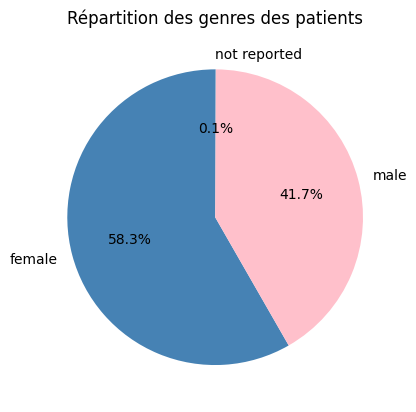

In [30]:
gender_counts = dataFrame['gender'].value_counts()

plt.pie(
    gender_counts,
    labels = gender_counts.index,
    autopct = "%1.1f%%",
    startangle = 90,
    colors = ["steelblue", "pink"],
)
plt.title("Répartition des genres des patients")
plt.show()

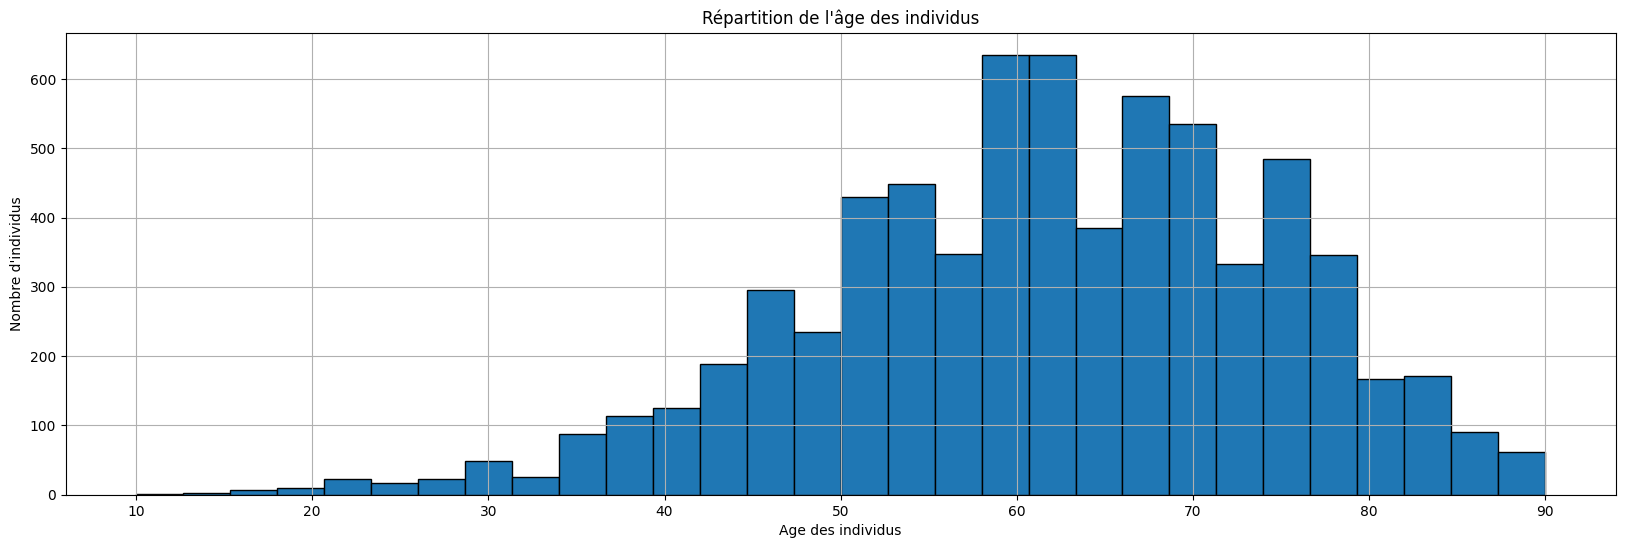

In [31]:
plt.figure(figsize = (20, 6))
plt.hist(dataFrame['age_at_index'], bins = 30, edgecolor = 'black')
plt.xlabel("Age des individus")
plt.ylabel("Nombre d'individus")
plt.title("Répartition de l'âge des individus")
plt.grid()
plt.show()

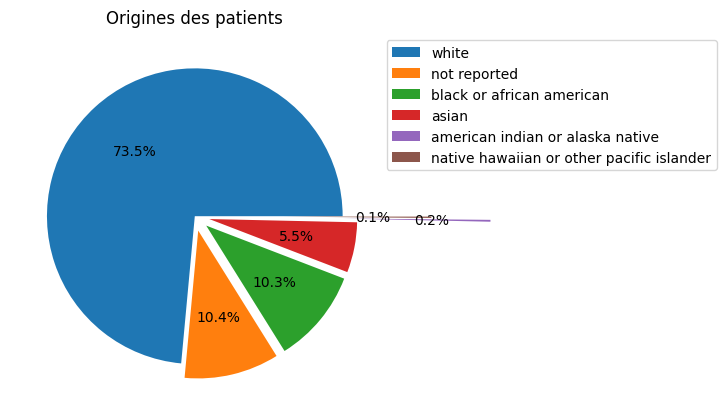

In [32]:
race_counts = dataFrame['race'].value_counts()


explode = (0, 0.1, 0.1, 0.1, 1, 0.6)

plt.pie(race_counts, explode = explode, autopct = "%1.1f%%")
plt.title("Origines des patients")
plt.legend(race_counts.index, bbox_to_anchor = (1, 0.8), loc = "center left")
plt.show()

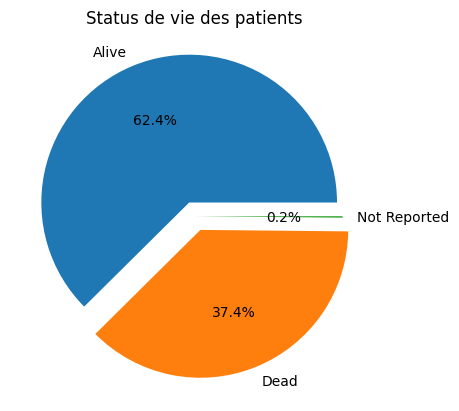

In [33]:
vital_status_counts = dataFrame['vital_status'].value_counts()


explode = (0.1, 0.1, 0)

plt.pie(vital_status_counts, explode = explode, labels = vital_status_counts.index, autopct = "%1.1f%%")
plt.title("Status de vie des patients")
plt.show()

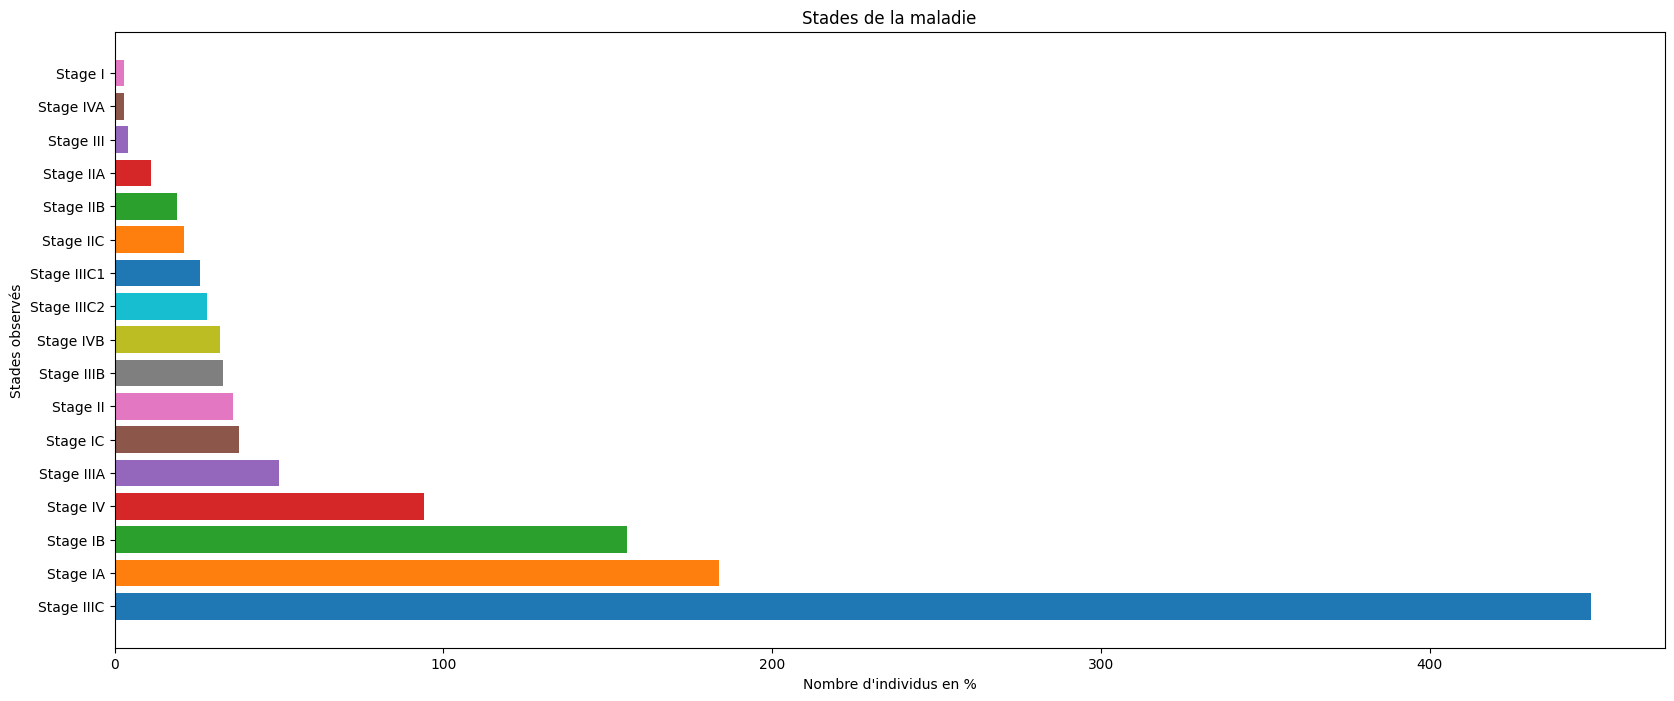

In [34]:
figo_stage_counts = dataFrame['figo_stage'].value_counts()


plt.figure(figsize = (20, 8))
plt.barh(figo_stage_counts.index, figo_stage_counts, color = mcolors.TABLEAU_COLORS)
plt.xlabel("Nombre d'individus en %")
plt.ylabel("Stades observés")
plt.title("Stades de la maladie")
plt.show()

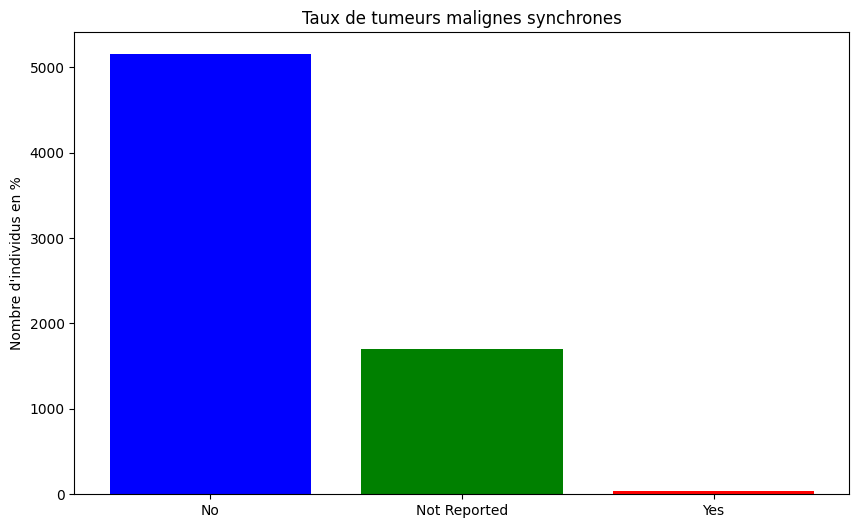

In [35]:
synchronous_malignancy_counts = dataFrame['synchronous_malignancy'].value_counts()


plt.figure(figsize=(10, 6))
plt.bar(synchronous_malignancy_counts.index, synchronous_malignancy_counts, color = mcolors.BASE_COLORS)
plt.ylabel("Nombre d'individus en %")
plt.title("Taux de tumeurs malignes synchrones")
plt.show()

In [36]:
keep_columns = ["age_at_index", "gender", "treatment_type_1", "treatment_type_2", "state"]
subdata = dataFrame.filter(items = keep_columns)

display(subdata)

age_at_index  gender             treatment_type_1  \
0             75.0  female  Pharmaceutical Therapy, NOS   
1             30.0  female       Radiation Therapy, NOS   
2             45.0  female  Pharmaceutical Therapy, NOS   
3             66.0    male  Pharmaceutical Therapy, NOS   
4             61.0  female       Radiation Therapy, NOS   
...            ...     ...                          ...   
6878          76.0    male       Radiation Therapy, NOS   
6879          57.0    male  Pharmaceutical Therapy, NOS   
6880          39.0    male       Radiation Therapy, NOS   
6881          85.0  female  Pharmaceutical Therapy, NOS   
6882          59.0  female  Pharmaceutical Therapy, NOS   

                 treatment_type_2     state  
0          Radiation Therapy, NOS  released  
1     Pharmaceutical Therapy, NOS  released  
2          Radiation Therapy, NOS  released  
3          Radiation Therapy, NOS  released  
4     Pharmaceutical Therapy, NOS  released  
...                           ...       ...  
6878  Pharmaceutical Therapy, NOS  released  
6879       Radiation Therapy, NOS  released  
6880  Pharmaceutical Therapy, NOS  released  
6881       Radiation Therapy, NOS  released  
6882       Radiation Therapy, NOS  released  

[6883 rows x 5 columns]

### **Cigarette consumption**

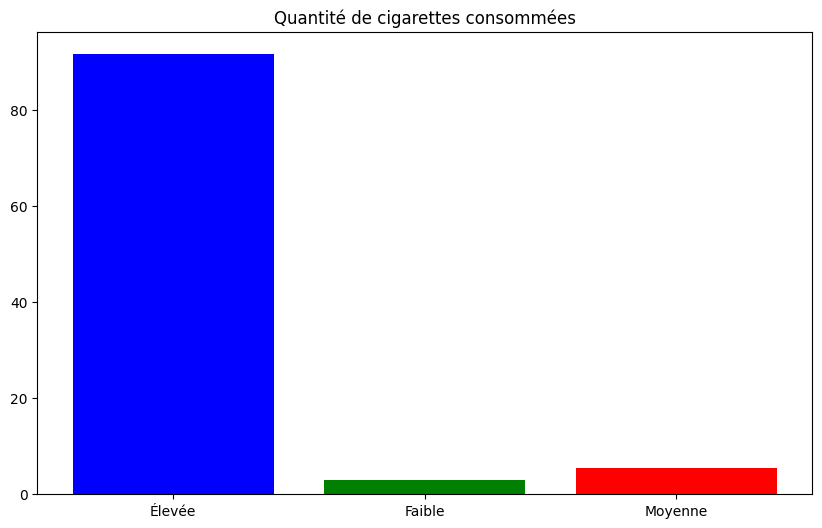

In [37]:
cigarettes_per_day_labels = []
cigarettes_per_day_counts = []


cpt = 0
for cigarettes in dataFrame['cigarettes_per_day']:
    value = "Élevée"
    if cigarettes < 1:
        value = "Faible"
    elif cigarettes < 2:
        value = "Moyenne"
    
    if value not in cigarettes_per_day_labels:
        cigarettes_per_day_labels.append(value)
        cigarettes_per_day_counts.append(1)
    else:
        index = cigarettes_per_day_labels.index(value)
        cigarettes_per_day_counts[index] += 1

for pos in range(0, len(cigarettes_per_day_counts)):
    cigarettes_per_day_counts[pos] = cigarettes_per_day_counts[pos] * 100 / len(dataFrame)


plt.figure(figsize=(10, 6))
plt.bar(cigarettes_per_day_labels, cigarettes_per_day_counts, color = mcolors.BASE_COLORS)
plt.title("Quantité de cigarettes consommées")
plt.show()

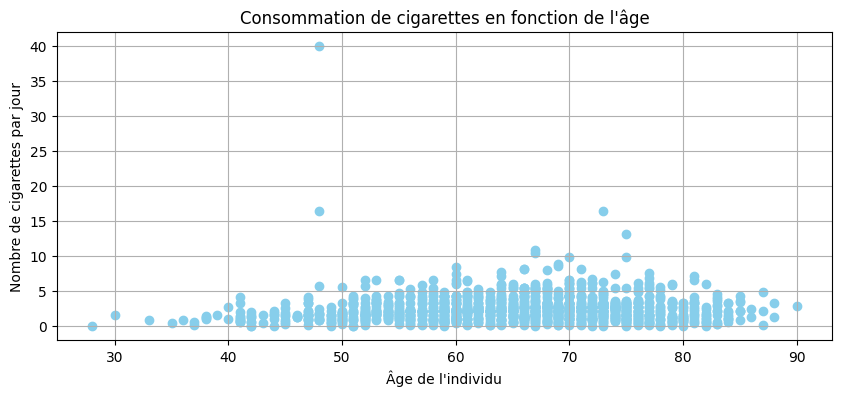

In [38]:
plt.figure(figsize=(10, 4))
plt.scatter(dataFrame['age_at_index'], dataFrame['cigarettes_per_day'], color='skyblue')
plt.xlabel('Âge de l\'individu')
plt.ylabel('Nombre de cigarettes par jour')
plt.title('Consommation de cigarettes en fonction de l\'âge')
plt.grid(True)
plt.show()

## **Transformation du dataframe**

In [39]:
columns = ['vital_status', 'alcohol_history', 'ajcc_pathologic_stage', 'treatment_type_1', 'treatment_type_2', 'tissue_or_organ_of_origin', 'age_at_diagnosis', 'primary_diagnosis', 'prior_malignancy', 'ajcc_pathologic_t', 'morphology', 'ajcc_clinical_m', 'ajcc_pathologic_n', 'icd_10_code', 'site_of_resection_or_biopsy', 'ajcc_staging_system_edition', 'ajcc_pathologic_m', 'ajcc_clinical_t', 'figo_stage', 'ajcc_clinical_stage', 'ajcc_clinical_n', 'race', 'gender', 'age_at_index', 'year_of_birth']
withoutNumberColumns = ['vital_status', 'alcohol_history', 'ajcc_pathologic_stage', 'treatment_type_1', 'treatment_type_2', 'tissue_or_organ_of_origin', 'primary_diagnosis', 'prior_malignancy', 'ajcc_pathologic_t', 'morphology', 'ajcc_clinical_m', 'ajcc_pathologic_n', 'icd_10_code', 'site_of_resection_or_biopsy', 'ajcc_staging_system_edition', 'ajcc_pathologic_m', 'ajcc_clinical_t', 'figo_stage', 'ajcc_clinical_stage', 'ajcc_clinical_n', 'race', 'gender']

In [40]:
data = dataFrame[columns]

label_encoder = LabelEncoder()

for column in withoutNumberColumns:
    data[column] = label_encoder.fit_transform(data[column])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

On vérifie qu'aucune valeurs numériques se trouvent dans data.

In [41]:
for column in columns:
    for value in data[column]:
        if isinstance(value, str):
            print(f"{column} : {value}")

## **Statistiques et nettoyage du dataframe**

In [42]:
print("\tDIMENSIONS DU DATA (lignes, colonnes) :", dataFrame.shape)
print("\n\n\tINFORMATIONS SUR LE DATA :")
print(data.info(), "\n\n")

	DIMENSIONS DU DATA (lignes, colonnes) : (6883, 147)


	INFORMATIONS SUR LE DATA :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   vital_status                 6883 non-null   int32  
 1   alcohol_history              6883 non-null   int32  
 2   ajcc_pathologic_stage        6883 non-null   int32  
 3   treatment_type_1             6883 non-null   int32  
 4   treatment_type_2             6883 non-null   int32  
 5   tissue_or_organ_of_origin    6883 non-null   int32  
 6   age_at_diagnosis             6799 non-null   float64
 7   primary_diagnosis            6883 non-null   int32  
 8   prior_malignancy             6883 non-null   int32  
 9   ajcc_pathologic_t            6883 non-null   int32  
 10  morphology                   6883 non-null   int32  
 11  ajcc_clinical_m              6883 non-null   int32 

In [43]:
data.isna().sum()

vital_status                    0
alcohol_history                 0
ajcc_pathologic_stage           0
treatment_type_1                0
treatment_type_2                0
tissue_or_organ_of_origin       0
age_at_diagnosis               84
primary_diagnosis               0
prior_malignancy                0
ajcc_pathologic_t               0
morphology                      0
ajcc_clinical_m                 0
ajcc_pathologic_n               0
icd_10_code                     0
site_of_resection_or_biopsy     0
ajcc_staging_system_edition     0
ajcc_pathologic_m               0
ajcc_clinical_t                 0
figo_stage                      0
ajcc_clinical_stage             0
ajcc_clinical_n                 0
race                            0
gender                          0
age_at_index                   37
year_of_birth                  82
dtype: int64

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.37730640708993174' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


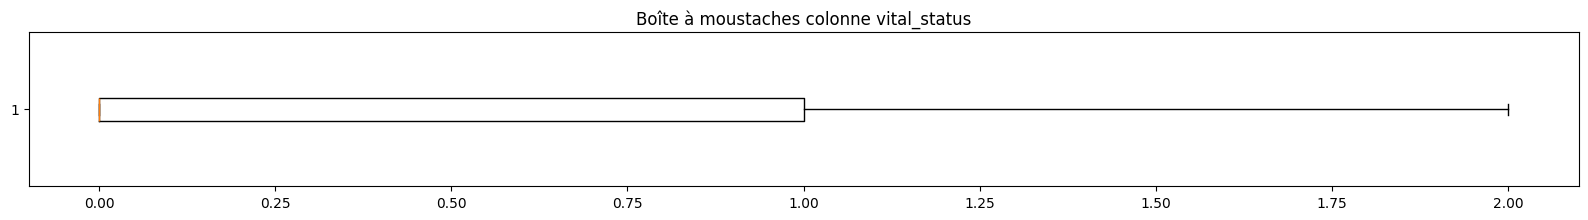

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0271683858782508' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


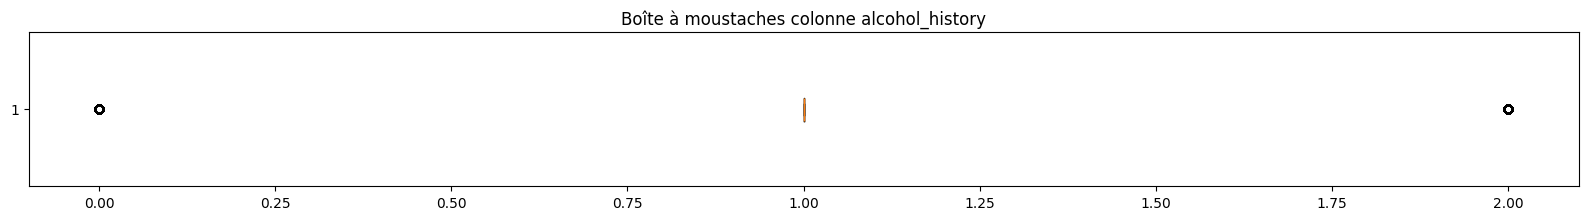

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.779020775824495' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


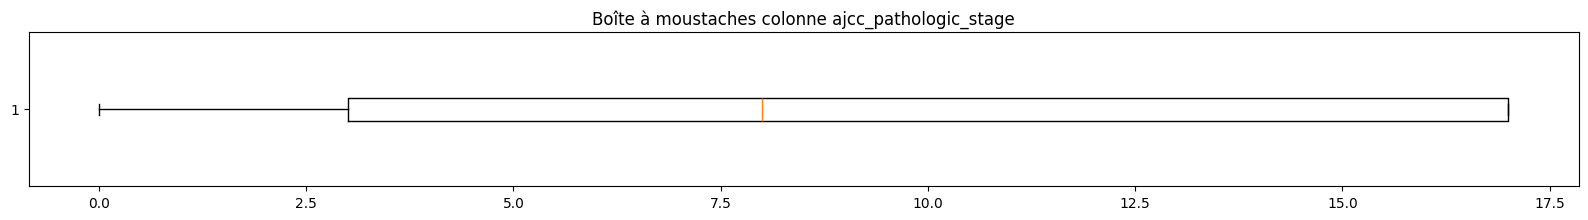

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.49978207177103007' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


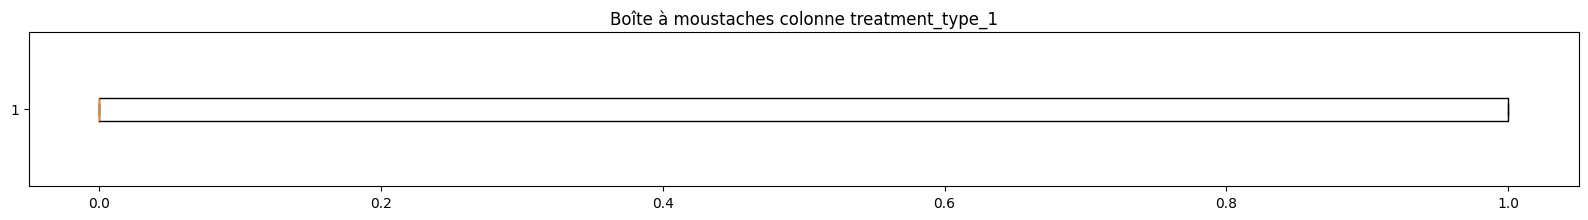

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5002179282289699' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


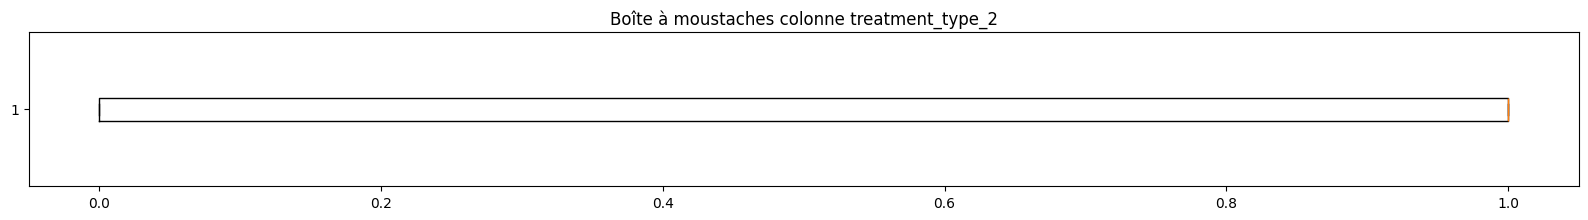

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28.447769867790207' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


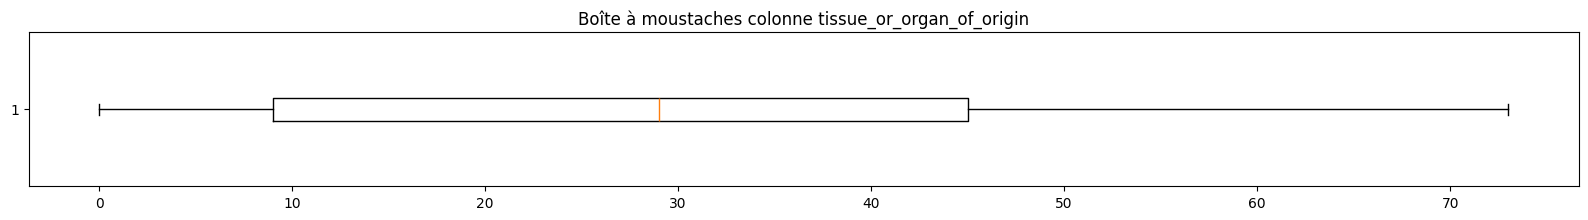

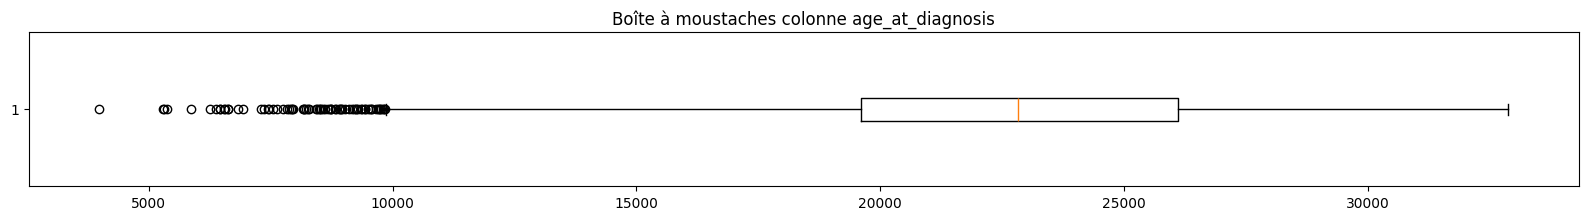

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '34.26485544094145' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


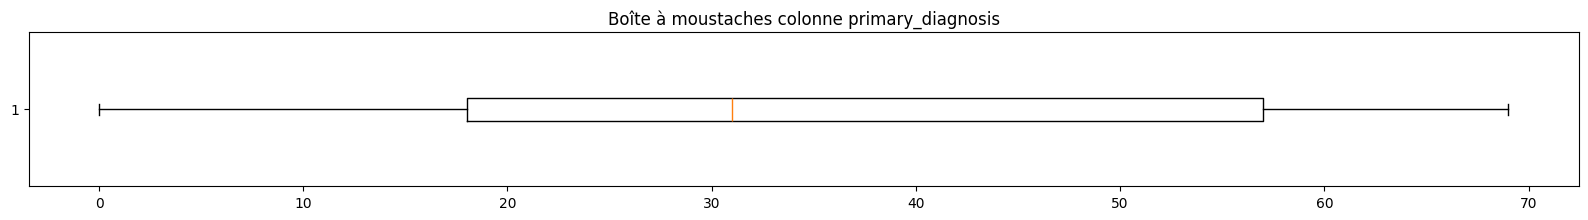

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.34955687926776113' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


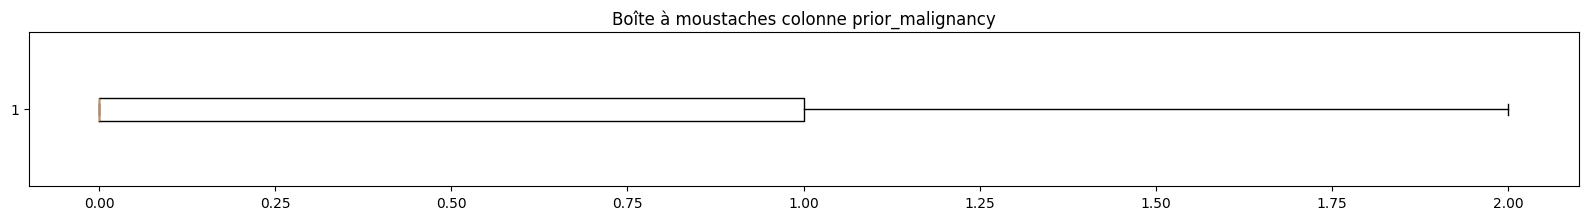

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.64521284323696' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


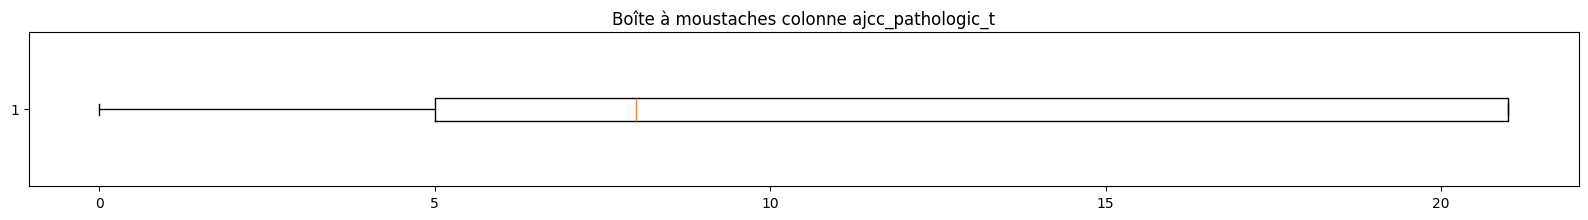

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32.85384280110417' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


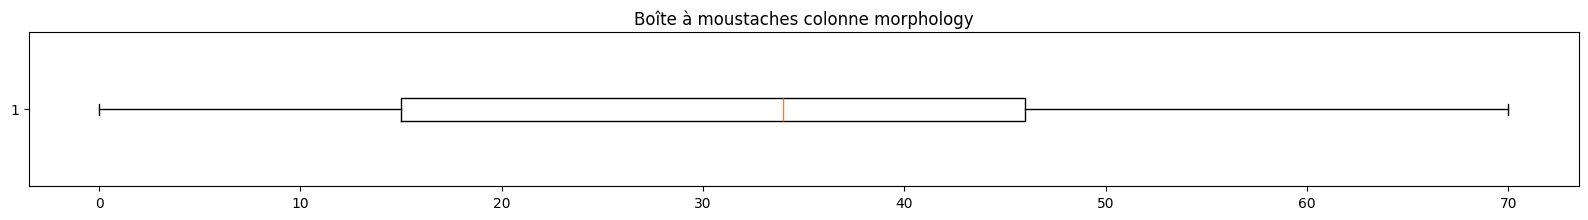

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.436873456341711' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


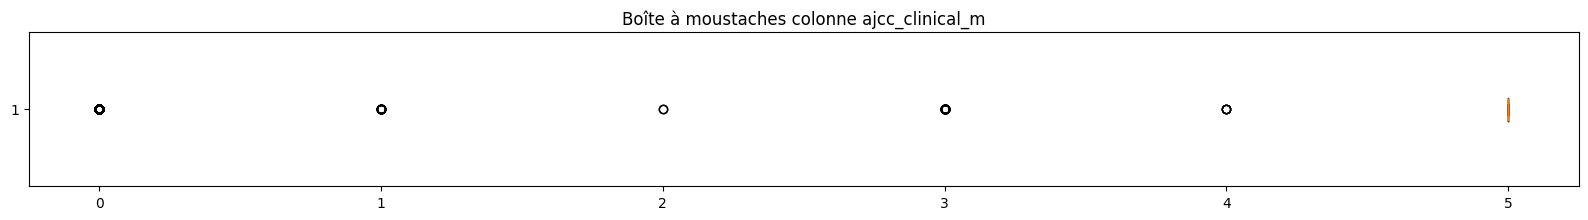

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.849048380066831' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


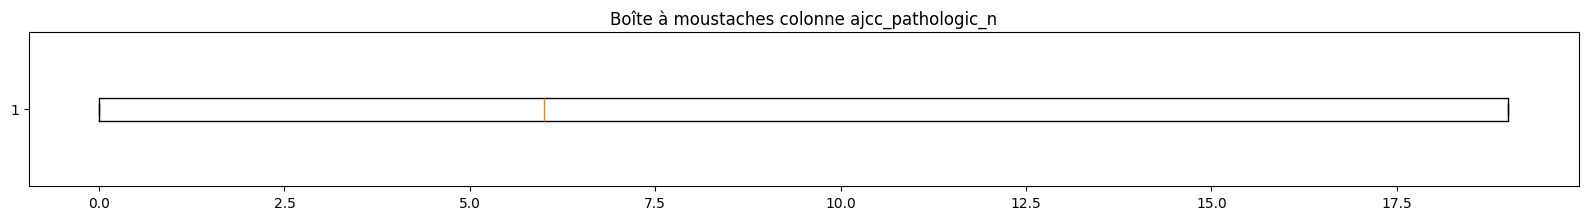

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '48.804445735870985' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


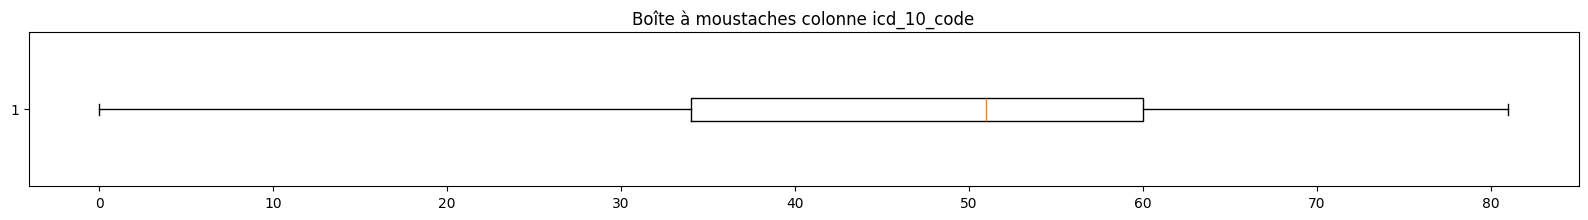

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.039227081214587' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


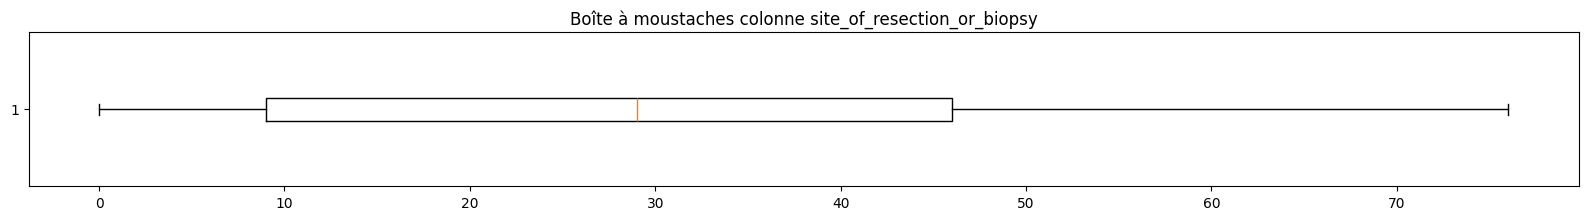

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.476681679500218' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


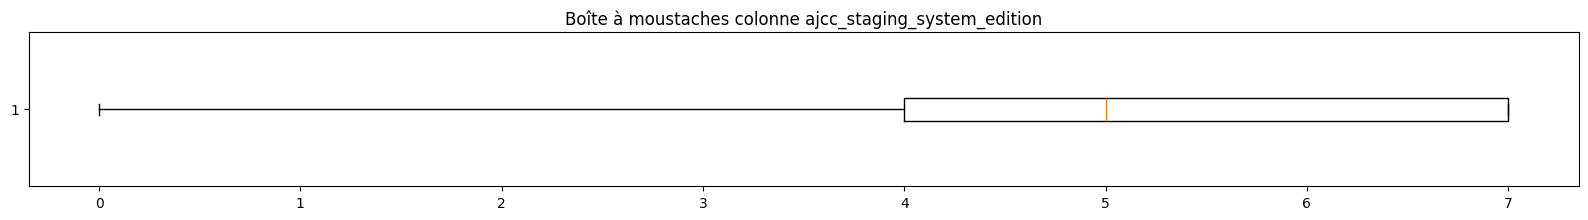

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.039081795728607' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


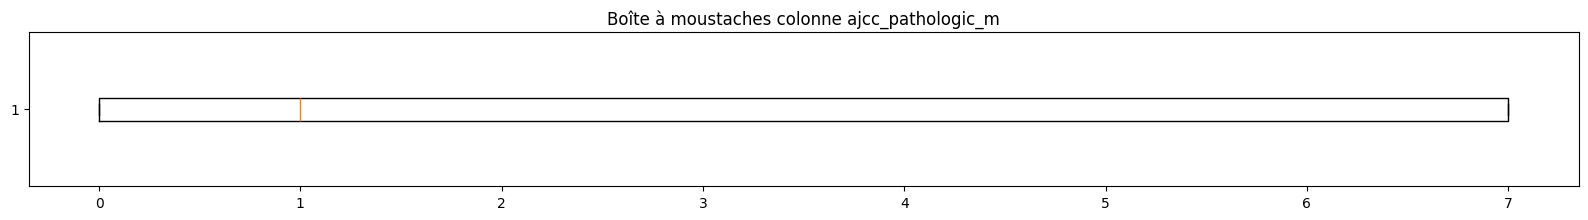

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.780037774226354' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


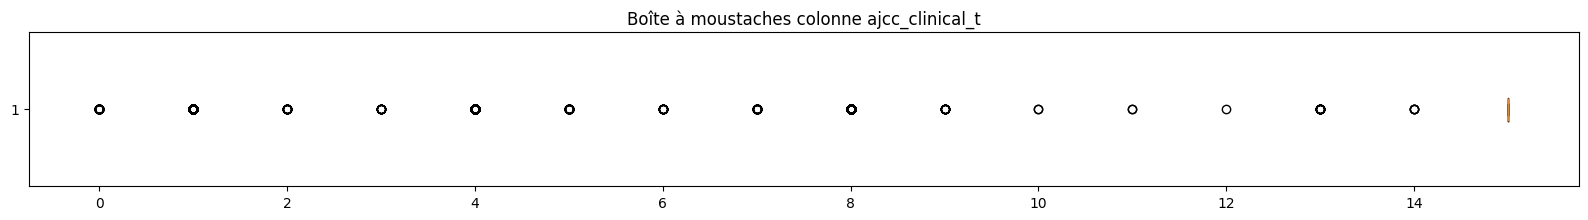

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '16.256574168240594' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


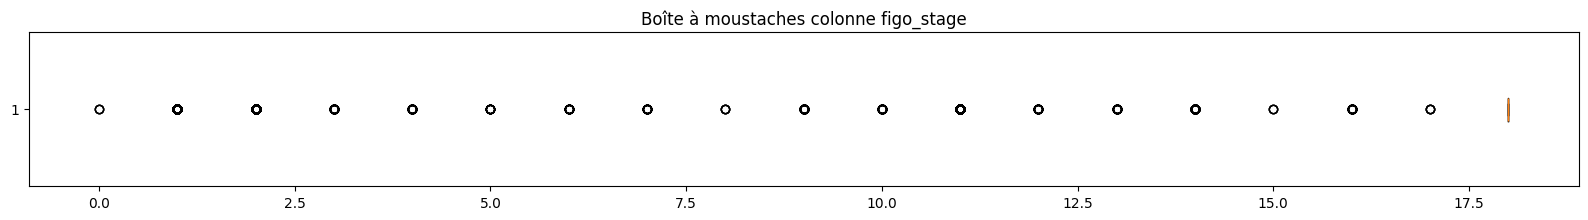

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '12.384134824930989' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


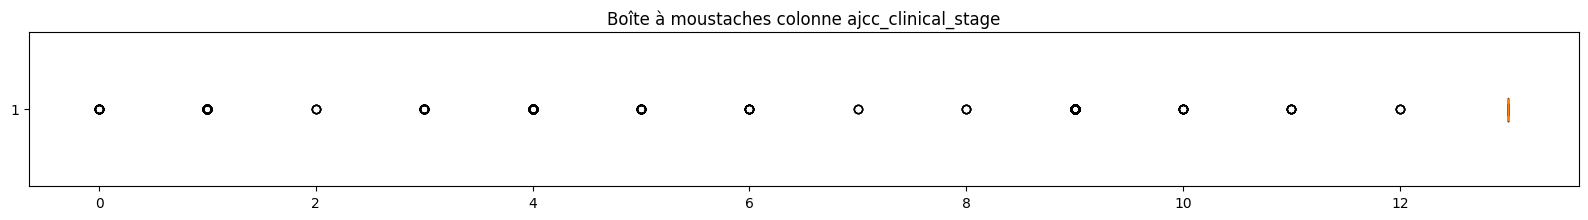

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.347232311492082' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


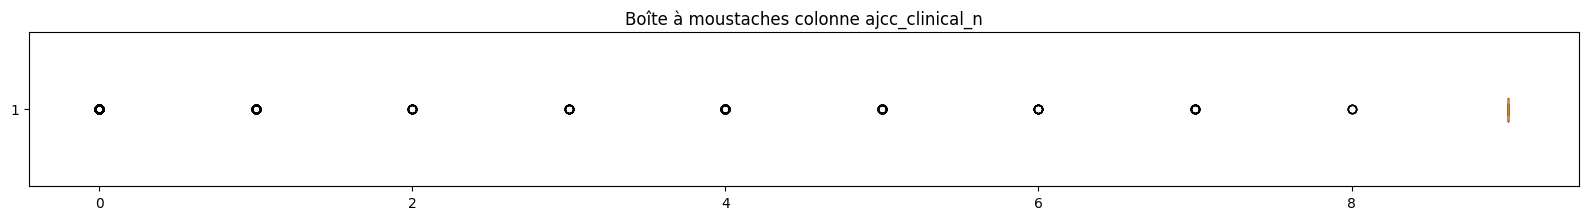

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.3555135841929395' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


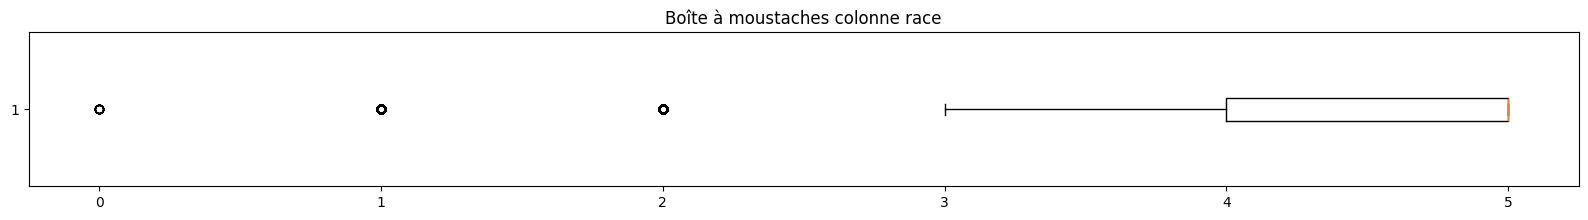

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.417695772192358' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.


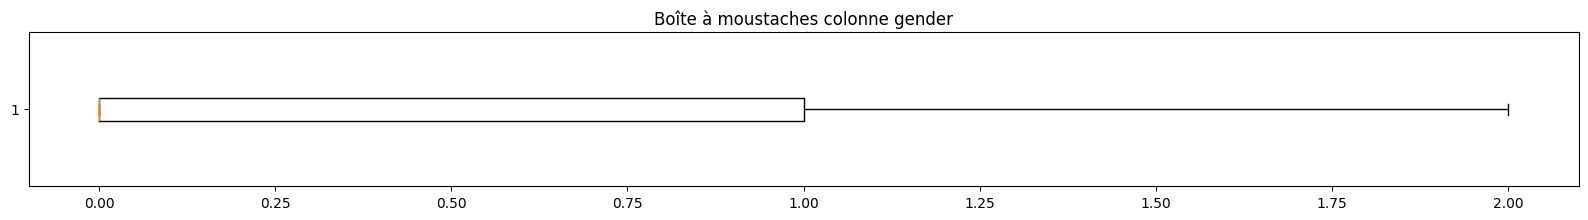

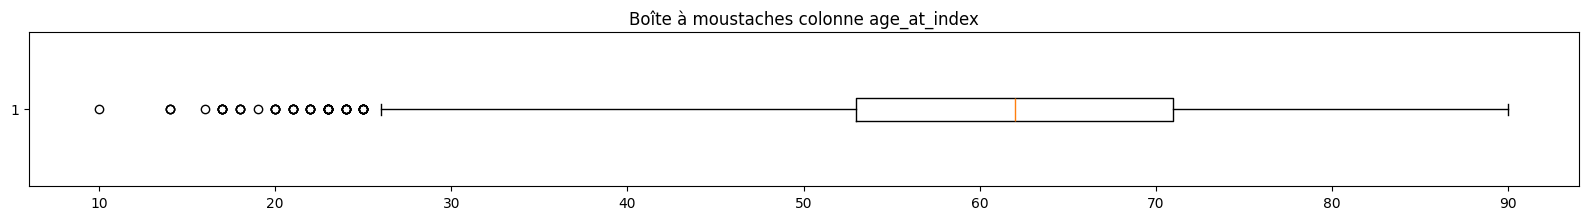

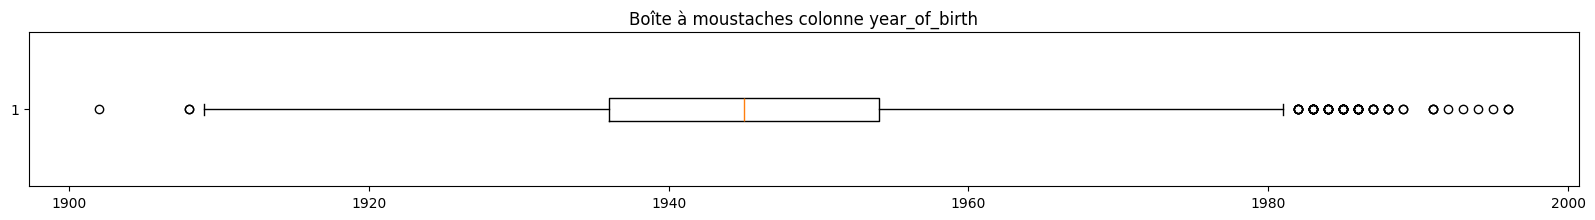

In [44]:
def remplacer_valeurs_aberrantes(data, column):
    mean = data[column].mean()

    # Remplacement des valeurs Nan par la moyenne de la colonne
    data.loc[data[column].isna(), column] = mean
    data.loc[data[column].isna(), column] = mean


def affichage_box_plot(column):
    valeurs = data[column].astype(int).tolist()
    plt.figure(figsize=(20, 2))
    plt.boxplot(valeurs, vert=False)
    plt.title(f'Boîte à moustaches colonne {column}')
    plt.show()

for column in data.columns:
    remplacer_valeurs_aberrantes(data, column)
    affichage_box_plot(column)

In [45]:
data.describe()

vital_status  alcohol_history  ajcc_pathologic_stage  treatment_type_1  \
count   6883.000000      6883.000000            6883.000000       6883.000000   
mean       0.377306         1.027168               8.779021          0.499782   
std        0.488034         0.272737               6.371285          0.500036   
min        0.000000         0.000000               0.000000          0.000000   
25%        0.000000         1.000000               3.000000          0.000000   
50%        0.000000         1.000000               8.000000          0.000000   
75%        1.000000         1.000000              17.000000          1.000000   
max        2.000000         2.000000              17.000000          1.000000   

       treatment_type_2  tissue_or_organ_of_origin  age_at_diagnosis  \
count       6883.000000                6883.000000       6883.000000   
mean           0.500218                  28.447770      22664.804089   
std            0.500036                  20.275041       4721.167592   
min            0.000000                   0.000000       3982.000000   
25%            0.000000                   9.000000      19598.000000   
50%            1.000000                  29.000000      22828.000000   
75%            1.000000                  45.000000      26103.000000   
max            1.000000                  73.000000      32872.000000   

       primary_diagnosis  prior_malignancy  ajcc_pathologic_t  ...  \
count        6883.000000       6883.000000        6883.000000  ...   
mean           34.264855          0.349557          10.645213  ...   
std            21.592613          0.640692           7.338017  ...   
min             0.000000          0.000000           0.000000  ...   
25%            18.000000          0.000000           5.000000  ...   
50%            31.000000          0.000000           8.000000  ...   
75%            57.000000          1.000000          21.000000  ...   
max            69.000000          2.000000          21.000000  ...   

       ajcc_staging_system_edition  ajcc_pathologic_m  ajcc_clinical_t  \
count                  6883.000000        6883.000000      6883.000000   
mean                      5.476682           3.039082        13.780038   
std                       1.366824           3.202651         3.586256   
min                       0.000000           0.000000         0.000000   
25%                       4.000000           0.000000        15.000000   
50%                       5.000000           1.000000        15.000000   
75%                       7.000000           7.000000        15.000000   
max                       7.000000           7.000000        15.000000   

        figo_stage  ajcc_clinical_stage  ajcc_clinical_n         race  \
count  6883.000000          6883.000000      6883.000000  6883.000000   
mean     16.256574            12.384135         8.347232     4.355514   
std       4.308755             2.235949         2.194751     1.244287   
min       0.000000             0.000000         0.000000     0.000000   
25%      18.000000            13.000000         9.000000     4.000000   
50%      18.000000            13.000000         9.000000     5.000000   
75%      18.000000            13.000000         9.000000     5.000000   
max      18.000000            13.000000         9.000000     5.000000   

            gender  age_at_index  year_of_birth  
count  6883.000000   6883.000000    6883.000000  
mean      0.417696     61.559159    1945.870754  
std       0.494392     12.987663      13.391515  
min       0.000000     10.000000    1902.000000  
25%       0.000000     53.000000    1936.000000  
50%       0.000000     62.000000    1945.870754  
75%       1.000000     71.000000    1954.000000  
max       2.000000     90.000000    1996.000000  

[8 rows x 25 columns]

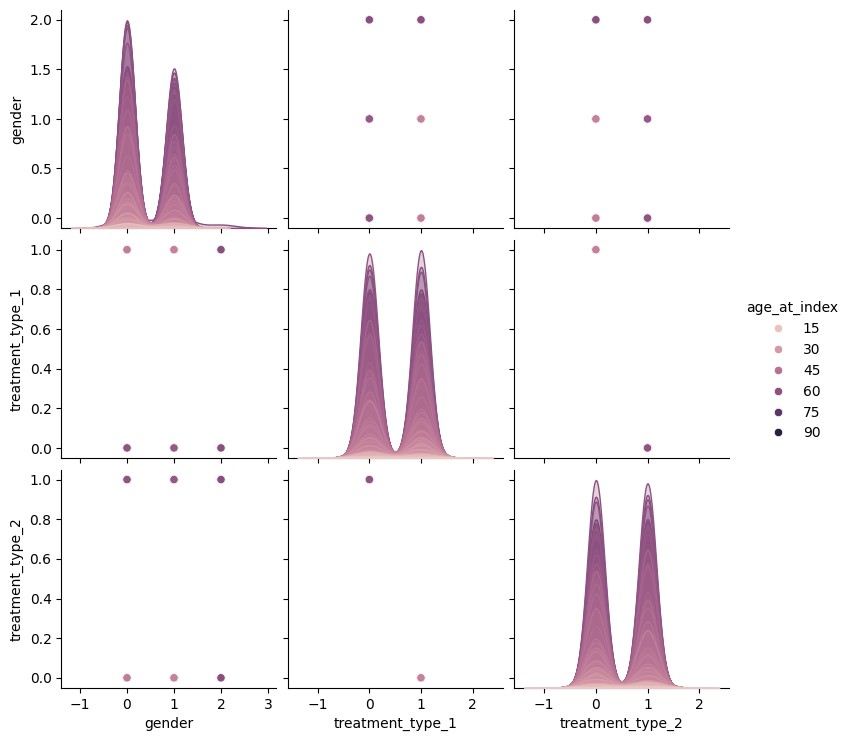

In [46]:
sns.pairplot(data[['age_at_index', 'gender', 'treatment_type_1', 'treatment_type_2']], hue = 'age_at_index')

## **Matrice de corrélation**

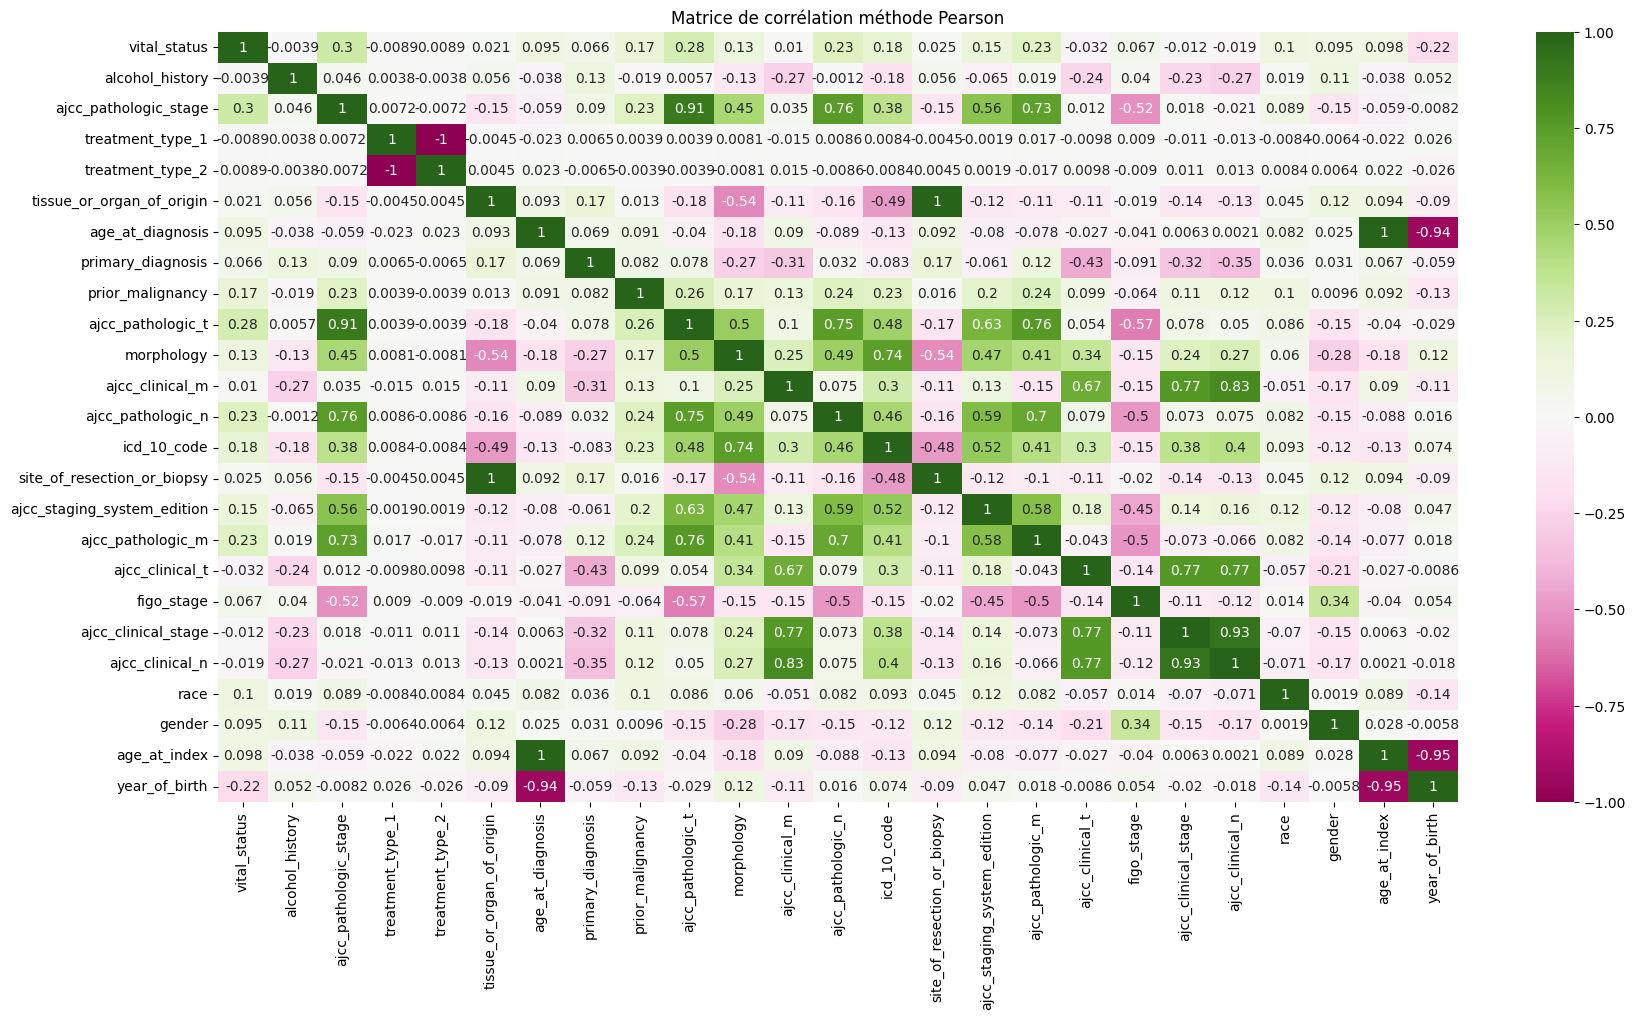

vital_status  alcohol_history  ajcc_pathologic_stage  \
vital_status           1.0        -0.003882               0.304823   

              treatment_type_1  treatment_type_2  tissue_or_organ_of_origin  \
vital_status         -0.008892          0.008892                    0.02131   

              age_at_diagnosis  primary_diagnosis  prior_malignancy  \
vital_status          0.094809           0.066244          0.169714   

              ajcc_pathologic_t  ...  ajcc_staging_system_edition  \
vital_status           0.277547  ...                     0.151624   

              ajcc_pathologic_m  ajcc_clinical_t  figo_stage  \
vital_status           0.231068        -0.032109    0.067282   

              ajcc_clinical_stage  ajcc_clinical_n      race    gender  \
vital_status            -0.011931        -0.019367  0.104503  0.094697   

              age_at_index  year_of_birth  
vital_status      0.098218      -0.223451  

[1 rows x 25 columns]

In [47]:
matrice = data.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(matrice, annot=True, cmap='PiYG')
plt.title('Matrice de corrélation méthode Pearson')
plt.show()

print()
print()

display(matrice.head(1))

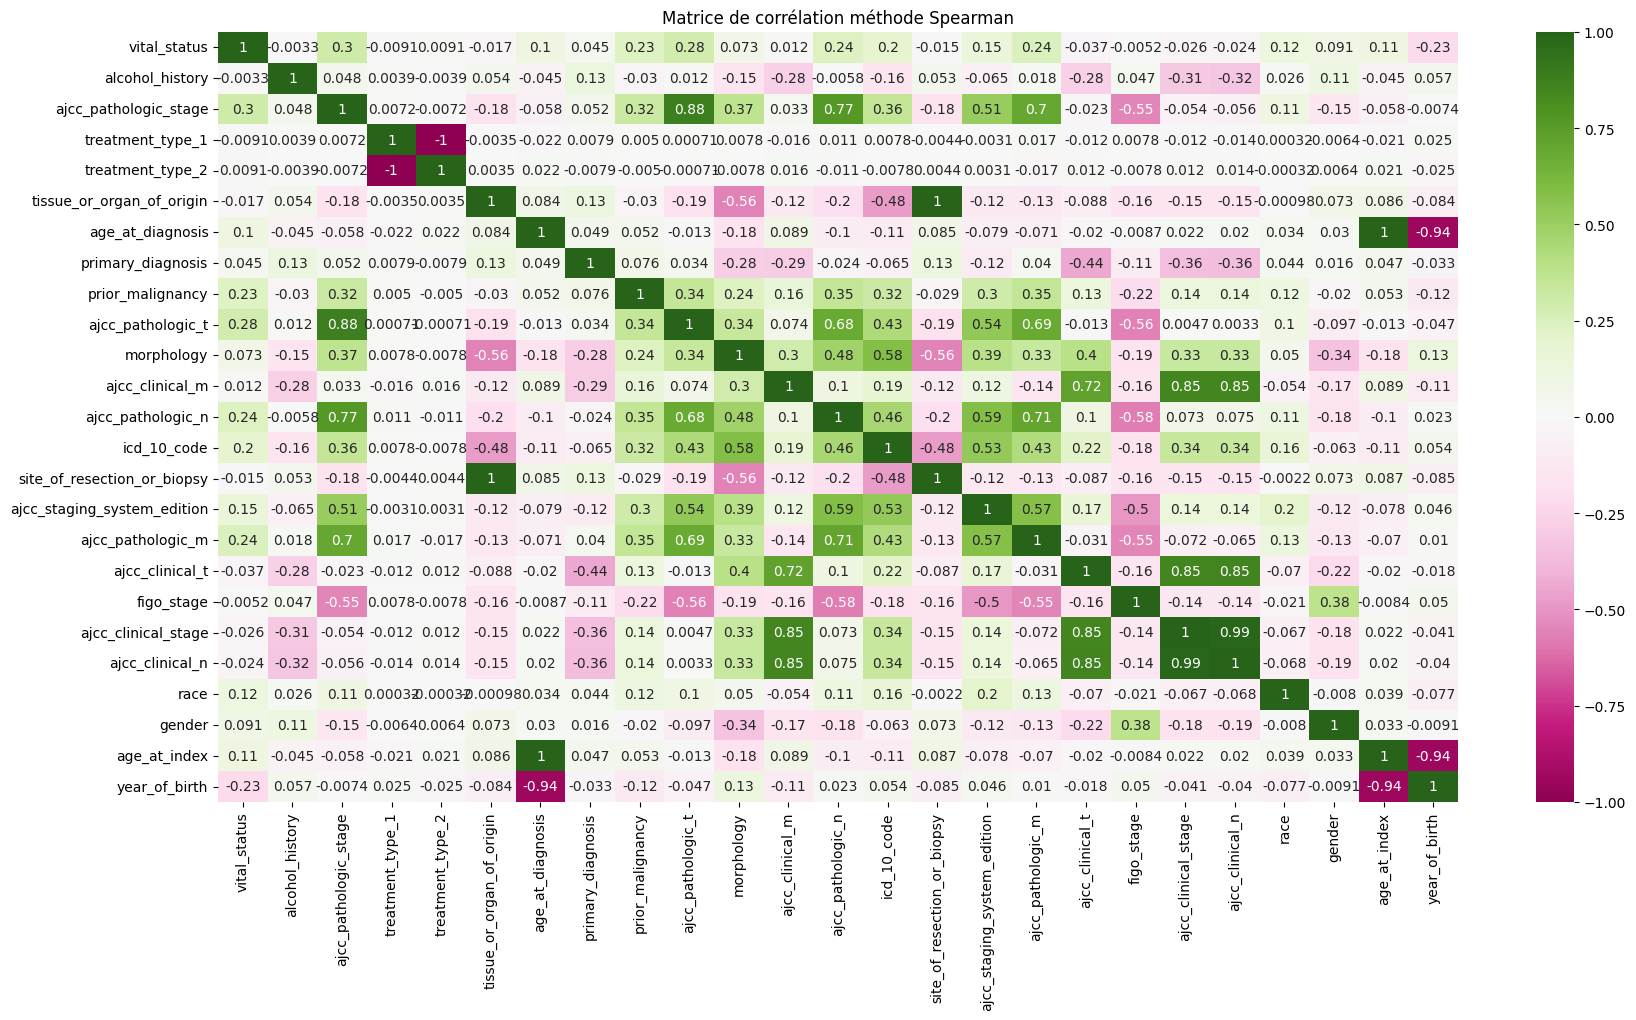

vital_status  alcohol_history  ajcc_pathologic_stage  \
vital_status           1.0        -0.003304               0.299828   

              treatment_type_1  treatment_type_2  tissue_or_organ_of_origin  \
vital_status         -0.009129          0.009129                  -0.017058   

              age_at_diagnosis  primary_diagnosis  prior_malignancy  \
vital_status          0.102051           0.045333          0.229802   

              ajcc_pathologic_t  ...  ajcc_staging_system_edition  \
vital_status           0.281606  ...                     0.149658   

              ajcc_pathologic_m  ajcc_clinical_t  figo_stage  \
vital_status           0.243845        -0.037447   -0.005162   

              ajcc_clinical_stage  ajcc_clinical_n      race    gender  \
vital_status            -0.025654        -0.024117  0.123093  0.090798   

              age_at_index  year_of_birth  
vital_status      0.105615      -0.226115  

[1 rows x 25 columns]

In [48]:
# variables
matrice = data.corr(method='spearman')

# graph
plt.figure(figsize=(20, 10))
sns.heatmap(matrice, annot=True, cmap='PiYG')
plt.title('Matrice de corrélation méthode Spearman')
plt.show()

print()
print()

# cible sur la target
display(matrice.head(1))

## **Mise à l'échelle des données**

In [49]:
scaler = StandardScaler()
target = data['vital_status']
preprocessed_data = data.drop(columns = [f'{target.name}'], axis = 1) # on enlève la variable cible
n_components = 2

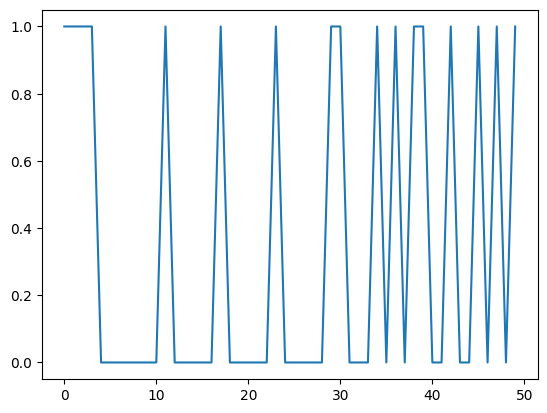

In [50]:
SEED = 1

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, target, test_size = 0.3, random_state = SEED)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.plot(target[:50])

## **PCA (Analyse en Composition Principales)**

In [51]:
def pca(n_components, data, variable, colorbar):
    var_pca = PCA(n_components = n_components)
    principal_components = var_pca.fit_transform(scaler.fit_transform(data))
    principal_df = pd.DataFrame(data = principal_components, columns=["PC1", "PC2"])

    plt.figure(figsize=(10, 8))
    plt.scatter(principal_df["PC1"], principal_df["PC2"], c = variable, cmap='turbo', alpha=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA : analyse en composantes principales")
    plt.colorbar(label = colorbar)
    plt.grid()
    plt.show()

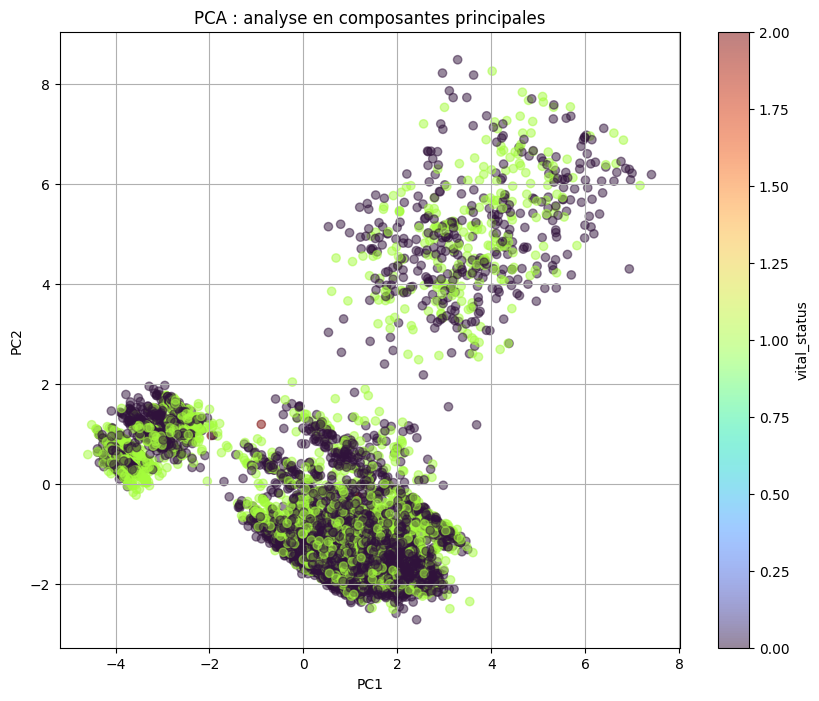

In [52]:
pca(n_components, preprocessed_data, target, target.name)

## **TSNE (t-distributed stochastic neighbor embedding)**

In [53]:
def tsne(n_components, data, variable, colorbar):
    tsne = TSNE(n_components = n_components, perplexity = 25, random_state = 42)
    tsne_components = tsne.fit_transform(data)

    tsne_df = pd.DataFrame(data = tsne_components, columns = ["t-SNE1", "t-SNE2"])

    # graph
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_df["t-SNE1"], tsne_df["t-SNE2"], c = variable, alpha = 0.5)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"t-SNE - Scatter Plot des composantes t-SNE")
    plt.colorbar(label = colorbar)
    plt.grid()
    plt.show()

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\godai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


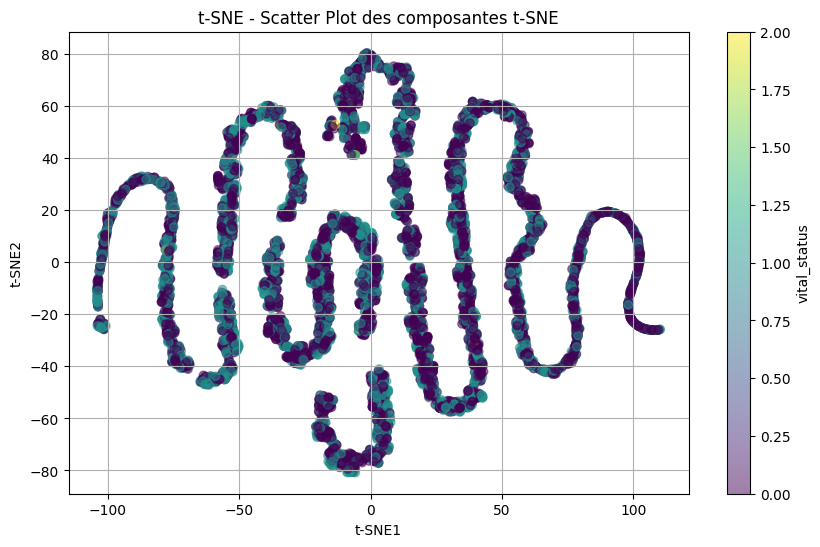

In [54]:
tsne(n_components, preprocessed_data, target, target.name)

## **Self-Organizing Maps (SOM) ~~ cartes auto-organisatrices**

1. **Définition**
* Algorithme d’apprentissage non supervisé (pas de variable cible)
* Algorithme de classification (clustering) qui généralise l’algorithme d’apprentissage compétitif en rajoutant une structure de voisinage entre les classes
* Complexité : linéaire par rapport au nombre de données --> facile à programmer
* Réduire la dimensionnalité des données tout en conservant les structures et les relations entre les données --> facilite l'exploration des données
<br>
<br>
2. **Fonctionnement**
* Les cartes auto-organisatrices de **Kohonen** (1984) sont constituées d'une grille. Dans chaque nœud de la grille se trouve un « neurone »
* Chaque neurone est associé à un vecteur de poids initialisé aléatoirement.
* Chaque neurone calcule sa similarité avec les données d'entrée (mesures telles que la distance euclidienne)
* **Neurone gagnant** = neurone dont le vecteur de poids est le plus similaire aux données
* Les vecteurs de poids des neurones voisins du neurone gagnant sont ajustés pour devenir plus similaires aux données d'entrée --> forme des groupes / clusters
<br>
<br>
Les paramètres de SOM sont les suivants :
* x : som_grid_rows, est le nombre de lignes
* y : som_grid_columns, est le nombre de colonnes
* Sigma est le rayon du voisinage
* learning_rate
<br>
<br>
Utilisées pour visualiser des données telles que des images, des séquences temporelles ou des caractéristiques complexes.

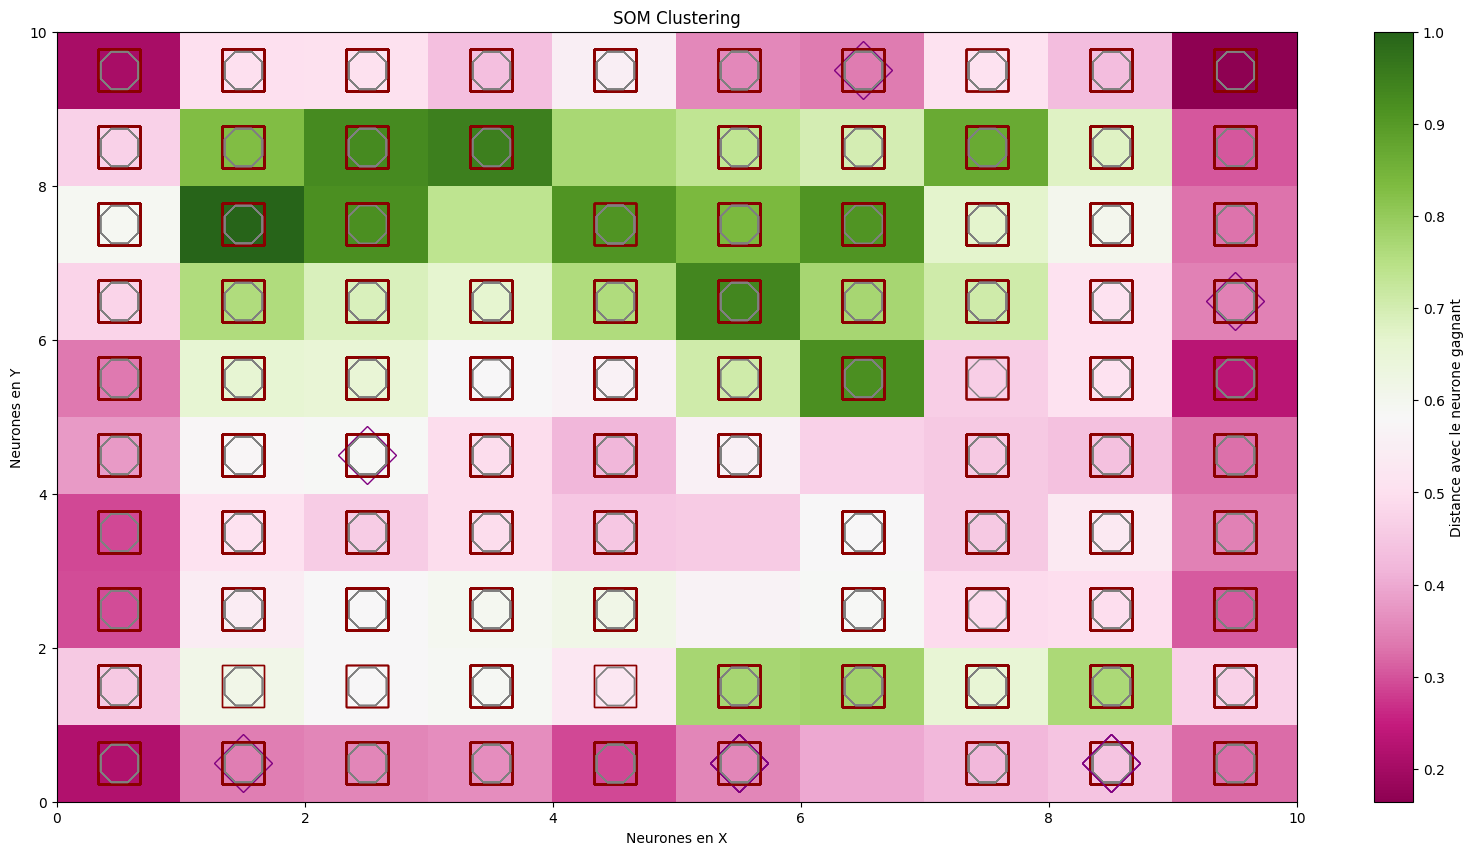

In [55]:
# Mise à l’échelle des x variables
min_max_scaler = MinMaxScaler() # utilisation de MinMaxScaler pour redimensionner les valeurs dans un interval de 0, 1 utile car tout dépend des distances
x = min_max_scaler.fit_transform(preprocessed_data)
pd.DataFrame(x)

som_dimens = (10, 10)
iterations = 20000
sigma = 1
learning_rate = 0.5

som = MiniSom(x = som_dimens[0],
y = som_dimens[1],
input_len = 24,
sigma = sigma,
learning_rate = learning_rate)

som.random_weights_init(x)

som.train_random(x, iterations)

# ==============================================================================

plt.figure(figsize=(20, 10))
plt.pcolor(som.distance_map().T, cmap='PiYG')
plt.colorbar(label="Distance avec le neurone gagnant")

colors = ['darkred', 'gray', 'purple', 'goldenrod', 'slategrey']
markers = ['s', '8', 'D', 'P', 'X']

for i, x in enumerate(x):
    index = int(target[i] % len(markers))
    winner = som.winner(x)
    plt.plot(winner[0] + 0.5,
        winner[1] + 0.5,
        markers[index],
        markeredgecolor = colors[index],
        markerfacecolor = 'None',
        markersize = 30)

plt.title('SOM Clustering')
plt.xlabel('Neurones en X')
plt.ylabel('Neurones en Y')
plt.show()

## **Modèles individuels**

### **Random Forest Classifier**
Repose sur des arbres (arbres de décision)

**Fonctionnement :**
* Découpage du dataset en plusieurs sous-ensembles
* Entrainement d'un modèle de classification sur chaque sous-ensemble
* Regroupement de tous les résultats du modèle pour une prédiction de classe
<br>
<br>

### **Extra Trees Classifier**
Similaire aux arbres de décision, mais avec une touche d'aléatoire

**Fonctionnement :**
* Découpe le dataset en plusieurs sous-ensembles
* Pour chaque sous-ensemble, il crée un arbre de décision avec des règles aléatoires pour réduire le surajustement
* Les résultats de tous les arbres sont combinés pour produire la prédiction finale de classe
<br>
<br>

### **Decision Tree Classifier**
Crée un arbre de décision pour la prise de décision

**Fonctionnement :**
* Divise le dataset en fonction des caractéristiques, en essayant de minimiser l'impureté des nœuds
* L'arbre est utilisé pour prendre des décisions en suivant les chemins du haut vers le bas
* Peut être sensible au surajustement (overfitting) s'il est trop profond
<br>
<br>

### **XGBoost Classifier**

* Algorithme spécialement conçu pour la régression et la classification
* Utilise un ensemble de modèles d'arbres de décision faibles (weak learners)

**Fonctionnement :**
* Les modèles sont formés de manière séquentielle, en corrigeant les erreurs des modèles précédents
* Utilise des techniques de régularisation pour éviter le surajustement
* Donne des performances élevées dans de nombreuses tâches d'apprentissage automatique
<br>
<br>

### **CatBoost Classifier**
* Algorithme adapté aux données catégorielles
* Gère automatiquement les données catégorielles sans conversion en données numériques
* Utilise un grand nombre d'arbres de décision pour la prédiction de classe
* Utilise un algorithme de gradient pour minimiser la perte
* Est conçu pour être efficace et précis, avec des paramètres par défaut bien ajustés
<br>
<br>

### **LightGBM Classifier**

* Algorithme conçu pour être rapide et précis
* Utilise un algorithme de gradient pour l'entraînement des arbres
* Utilise une stratégie de division en feuille (Leaf-Wise) pour accélérer la convergence
* Peut gérer des datasets volumineux et dispose d'options de parallélisme
* Dispose de paramètres ajustables pour optimiser les performances en fonction des besoins

In [56]:
def calculateModelsWithDifferentsMetrics(models, X_train, X_test, y_train, y_test):

    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        matrix = classification_report(y_test, y_pred)
        print("\n", model_name, " : \n", matrix, "\n\n")

In [57]:
def graphPerformanceModels(results):
    metrics = ["accuracy_score", "f1_score", "precision_score", "recall_score"]
    model_names = [row[0] for row in results]
    values = [[row[i] for row in results] for i in range(1, len(results[0]))]

    bar_width = 0.2
    index = np.arange(len(model_names))

    plt.figure(figsize=(12, 4))

    for i, value in enumerate(values):
        plt.bar(index + i * bar_width, value, bar_width, label = metrics[i])

    plt.xlabel('Modèles')
    plt.ylabel('Valeurs')
    plt.title('Performances des modèles')
    plt.legend()
    plt.xticks(index + 1.5 * bar_width, model_names, rotation = 45)

    plt.show()

In [58]:
def affichePerformanceModels(results):
    print("{:<15} \t\t {:<10} \t {:<10} \t {:<10} \t {:<10}".format("Techniques", "accuracy_score", "f1_score", "precision_score", "recall_score"))
    print("_______________________________________________________________________________________________________________")
    for row in results:
        print("{:<15} \t\t {:<10.3f} \t\t {:<10.3f} \t\t {:<10.3f} \t\t {:<10.3f}".format(*row))
        print("_______________________________________________________________________________________________________________")

In [59]:
models_individuels = [
    ("Random Forest", RandomForestClassifier(random_state = SEED, verbose = 0)),
    ("Extra Trees", ExtraTreesClassifier(random_state = SEED, verbose = 0)),
    ("Decision Tree", DecisionTreeClassifier(random_state = SEED)),
    ("XGBoost", XGBClassifier(random_state = SEED)),
    ("CatBoost", CatBoostClassifier(random_seed = SEED, verbose = 0)),
    ("LightGBM", LGBMClassifier(random_state = SEED, verbose = 0))
]

In [60]:
calculateModelsWithDifferentsMetrics(models_individuels, X_train, X_test, y_train, y_test)


 Random Forest  : 
               precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      1291
         1.0       0.72      0.57      0.64       770
         2.0       0.40      0.50      0.44         4

    accuracy                           0.75      2065
   macro avg       0.63      0.64      0.63      2065
weighted avg       0.75      0.75      0.75      2065
 



 Extra Trees  : 
               precision    recall  f1-score   support

         0.0       0.76      0.84      0.80      1291
         1.0       0.68      0.55      0.61       770
         2.0       0.50      0.75      0.60         4

    accuracy                           0.73      2065
   macro avg       0.65      0.71      0.67      2065
weighted avg       0.73      0.73      0.73      2065
 



 Decision Tree  : 
               precision    recall  f1-score   support

         0.0       0.76      0.75      0.75      1291
         1.0       0.59      0.59      0.59       770
        

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



 XGBoost  : 
               precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      1291
         1.0       0.71      0.64      0.67       770
         2.0       0.67      0.50      0.57         4

    accuracy                           0.77      2065
   macro avg       0.72      0.66      0.69      2065
weighted avg       0.76      0.77      0.76      2065
 



 CatBoost  : 
               precision    recall  f1-score   support

         0.0       0.80      0.85      0.83      1291
         1.0       0.73      0.66      0.69       770
         2.0       1.00      0.50      0.67         4

    accuracy                           0.78      2065
   macro avg       0.84      0.67      0.73      2065
weighted avg       0.78      0.78      0.78      2065
 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 LightGBM  : 
               precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      1291
 

## **Ajustement des hyperparamètres du modèle individuel**

* Trouver les meilleurs valeurs pour les paramètres de configuration (complexité du modèle, capacité de généralisation, taux d'apprentissage, nombre d'itération, ...)
* Permet d'améliorer les performances du modèle
<br>
<br>

### **Recherche en grille (Grid Search) :**

* La recherche en grille consiste à spécifier une liste de valeurs pour chaque hyperparamètre que vous souhaitez ajuster.
* Elle examine toutes les combinaisons possibles de ces valeurs.
* Cela signifie que la recherche en grille peut être très coûteuse en termes de temps de calcul, en particulier si vous avez de nombreux hyperparamètres et un grand nombre de valeurs à tester.
* Elle garantit de trouver les meilleurs hyperparamètres, mais cela peut prendre beaucoup de temps.
<br>

### **Recherche aléatoire (Random Search) :**

* La recherche aléatoire consiste à spécifier une distribution de probabilité pour chaque hyperparamètre, plutôt que des valeurs spécifiques.
* Elle échantillonne aléatoirement les hyperparamètres dans ces distributions.
* Par conséquent, la recherche aléatoire explore un espace d'hyperparamètres plus large en moins de temps que la recherche en grille.
* Cependant, il n'est pas garanti de trouver les meilleurs hyperparamètres, car certains jeux d'hyperparamètres peuvent ne jamais être échantillonnés.
<br>

### **Optimisation bayésienne :**

* L'optimisation bayésienne est une méthode plus sophistiquée qui utilise des modèles probabilistes pour estimer les performances du modèle en fonction des hyperparamètres.
* Elle utilise ces estimations pour décider quelles valeurs d'hyperparamètres explorer ensuite.
* L'optimisation bayésienne est plus efficace que la recherche en grille et la recherche aléatoire, car elle tient compte des informations accumulées au fil des itérations pour cibler les hyperparamètres les plus prometteurs.
* Elle est particulièrement utile lorsque l'ajustement des hyperparamètres est coûteux en temps, car elle nécessite moins d'expérimentations.

In [61]:
def confusionMatrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')

    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, cmap = 'Blues', square = True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [62]:
def hyperparametersTuning(models, X_train, X_test, y_train, y_test):

    techniques = []

    for model_name, model, params in models:
        techniques.append((model_name, model, 'BayesSearchCV', BayesSearchCV(model, params, n_iter=10, random_state = SEED)))

    for model_name, model, technique_name, technique in techniques:
        technique.fit(X_train, y_train)
        best_params = technique.best_params_
        print(f'{technique_name} meilleurs hyperparamètres pour {model_name} : {best_params}')

        # Modèle ajusté avec les hyperparamètres
        model_tuned = model.set_params(**best_params)
        model_tuned.fit(X_train, y_train)
        y_pred_tuned = model_tuned.predict(X_test)

        # Calcul des métriques pour les modèles
        matrix = classification_report(y_test, y_pred_tuned)
        print("\t", model_name, "\n", matrix, "\n\n")

        confusionMatrix(y_test, y_pred_tuned)

BayesSearchCV meilleurs hyperparamètres pour LightGBM : OrderedDict([('depth', 12), ('iterations', 143), ('learning_rate', 0.05)])
	 LightGBM 
               precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      1291
         1.0       0.74      0.63      0.68       770
         2.0       1.00      0.50      0.67         4

    accuracy                           0.78      2065
   macro avg       0.85      0.67      0.73      2065
weighted avg       0.78      0.78      0.78      2065
 




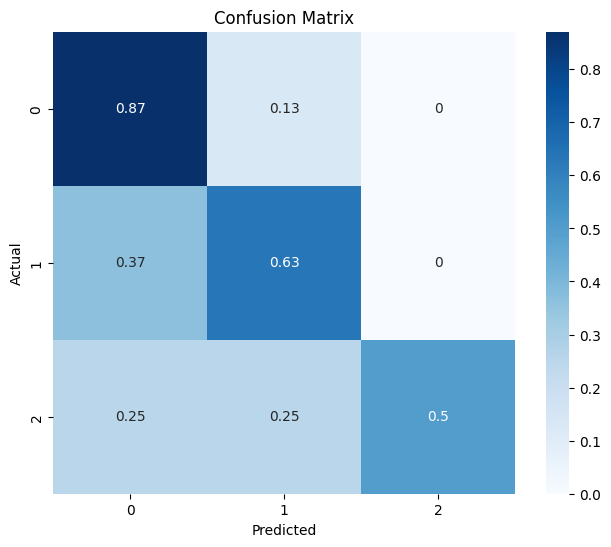

In [63]:
params = {
    'depth': (6, 14, 'uniform'),
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': (100, 800, 'uniform')
}

model = [
    ("LightGBM", LGBMClassifier(random_state = SEED, verbose = -1), params)
]

hyperparametersTuning(model, X_train, X_test, y_train, y_test)

BayesSearchCV meilleurs hyperparamètres pour LightGBM : OrderedDict([('depth', 13), ('iterations', 109), ('learning_rate', 0.1)])
	 LightGBM 
               precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      1291
         1.0       0.73      0.70      0.71       770
         2.0       0.33      0.75      0.46         4

    accuracy                           0.79      2065
   macro avg       0.63      0.76      0.67      2065
weighted avg       0.79      0.79      0.79      2065
 




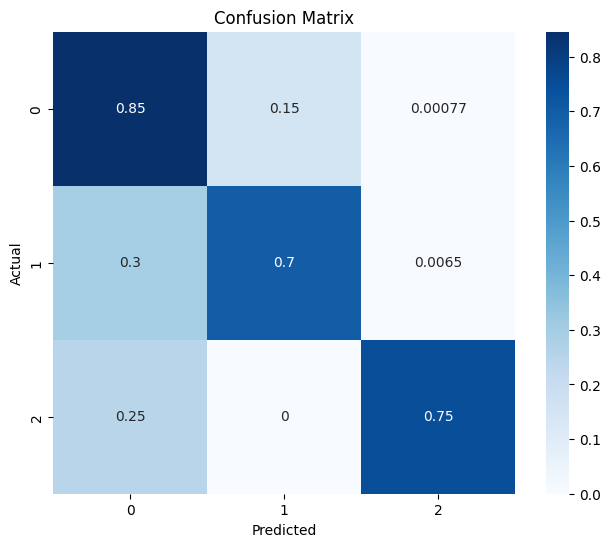

In [64]:
smote = SMOTE(random_state = SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

params = {
    'depth': (6, 14, 'uniform'),
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': (100, 800, 'uniform')
}

model = [
    ("LightGBM", LGBMClassifier(random_state = SEED, is_unbalance = True, verbose = -1), params)
]

hyperparametersTuning(model, X_train_smote, X_test, y_train_smote, y_test)

## **Modèles d'ensemble**

### **Bagging**
<br>
Bagging : Boostrap aggregating
<br>

* Utilise une technique connue sous le nom de Bootstrap

* Réduit la variance des modèles individuels dans l'ensemble
<br>
<br>

### **Staking**
<br>
<br>

### **Voting**
Voting : Méthode d'ensemble utilisée en apprentissage automatique pour combiner les prédictions de plusieurs modèles de maching learning différents
<br>

* **Hard Voting**
* Chaque modèle vote pour sa classe de prédiction, la classe avec le nombre maximal de vote et choisie comme prédiction finale
<br>
<br>
* **Soft Voting**
* Au lieu de voter pour des classes discrètes, les modèles produisent des scores de probabilité pour chaque classe.
* Le soft voting calcule la moyenne des scores de probabilité de chaque classe à partir de tous les modèles, puis sélectionne la classe avec la probabilité la plus élevée comme prédiction finale.
* Cette approche est souvent plus précise que le vote dur car elle prend en compte l'incertitude des modèles.

In [65]:
best_params = {
    'depth': 13,
    'learning_rate': 0.1,
    'iterations': 109
}

lightgbm_model = LGBMClassifier(random_state = SEED, verbose = -1)
lightgbm_tuned = LGBMClassifier(random_state = SEED, verbose = -1, **best_params)

In [66]:
models_ensemble = [
    ("BaggingClassifier", BaggingClassifier(estimator = lightgbm_model)),
    ("B.C hyperparamètres", BaggingClassifier(estimator = lightgbm_tuned)),

    ("StackingClassifier", StackingClassifier([('lightgbm_model', lightgbm_model)])),
    ("S.C hyperparamètres", StackingClassifier(estimators = [('lightgbm_tuned', lightgbm_tuned)])),

    ("VotingClassifier", VotingClassifier([('lightgbm_model', lightgbm_model)])),
    ("V.C hyperparamètres", VotingClassifier(estimators = [('lightgbm_tuned', lightgbm_tuned)]))
]

In [67]:
calculateModelsWithDifferentsMetrics(models_ensemble, X_train_smote, X_test, y_train_smote, y_test)


 BaggingClassifier  : 
               precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      1291
         1.0       0.72      0.69      0.71       770
         2.0       0.25      0.50      0.33         4

    accuracy                           0.79      2065
   macro avg       0.60      0.68      0.62      2065
weighted avg       0.78      0.79      0.78      2065
 



 B.C hyperparamètres  : 
               precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      1291
         1.0       0.72      0.69      0.71       770
         2.0       0.38      0.75      0.50         4

    accuracy                           0.79      2065
   macro avg       0.64      0.76      0.68      2065
weighted avg       0.79      0.79      0.79      2065
 



 StackingClassifier  : 
               precision    recall  f1-score   support

         0.0       0.83      0.84      0.83      1291
         1.0       0.72      0.71      0.71  

### Remarques :
On remarque que chaque modèle a des performances similaires.

## **Score d'importance**

* Évaluer l'influence de chaque variable
* Ces scores mesurent à quel point chaque variable contribue à la performance globale du modèle
<br>
<br>

### **Modèles individuels**
<br>
Les scores donnent une idée de la contribution de chaque caractéristiques à la prédiction du modèle
<br>

**Gini Importance**
* « diminution moyenne de l’impureté »
* Définie comme la diminution totale de l’impureté du nœud qui est pondérée par la probabilité d’atteindre ce nœud
* Méthode moyennée sur tous les arbres de l’ensemble
<br>
<br>

**Modèles d'ensemble**
<br>
Les scores donnent une idée de la contribution relative de chaque caractéristique à la performance globale de l'ensemble

In [68]:
def calculateImportanceIndividualModels(models, preprocessed_data, X_train, y_train):

    feature_importances = [0] * len(preprocessed_data.columns)
    feature_names = preprocessed_data.columns

    for model_name, model in models:
        model.fit(X_train, y_train)

        for index, importance in enumerate(model.feature_importances_):
            feature_importances[index] += importance

    total_importance = sum(feature_importances)
    normalized_importances = [importance / total_importance for importance in feature_importances]

    return [normalized_importances, feature_names]

### Remarque
Calcul des scores d'importance des modèles d'ensemble en utilisant la technique de permutation

In [69]:
def calculateImportanceEnsembleModels(models, X_train, X_test, y_train, y_test, metric = accuracy_score, num_permutations=20):

    feature_importances = [0] * len(preprocessed_data.columns)
    feature_names = preprocessed_data.columns

    for model_name, model in models:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        baseline_score = metric(y_test, y_pred)

        for feature in range(len(feature_names)):
            permuted_scores = []

            for _ in range(num_permutations):
                X_permuted = X_test.copy()
                X_permuted[:, feature] = np.random.permutation(X_permuted[:, feature])
                y_pred = model.predict(X_permuted)
                permuted_score = metric(y_test, y_pred)
                permuted_scores.append(permuted_score)

            feature_importances[feature] += baseline_score - np.mean(permuted_scores)
    total_importance = sum(feature_importances)
    normalized_importances = [importance / total_importance for importance in feature_importances]

    return [normalized_importances, feature_names]

In [70]:
def afficheImportanceCaracteristiques(feature_importances, feature_names):
    palette = ['red', 'steelblue', 'seagreen', 'mediumorchid', 'pink']

    plt.figure(figsize=(20, 6))
    plt.title("Importance des caractéristiques")
    plt.barh(range(len(feature_importances)), [importance for importance in feature_importances], align="center", color=palette)
    plt.yticks(range(len(feature_importances)), [name for name in feature_names])
    plt.tight_layout()
    plt.show()

In [71]:
importance_models_individuels = calculateImportanceIndividualModels(models_individuels, preprocessed_data, X_train_smote, y_train_smote)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


In [72]:
importance_models_ensemble = calculateImportanceEnsembleModels(models_ensemble, X_train_smote, X_test, y_train_smote, y_test)

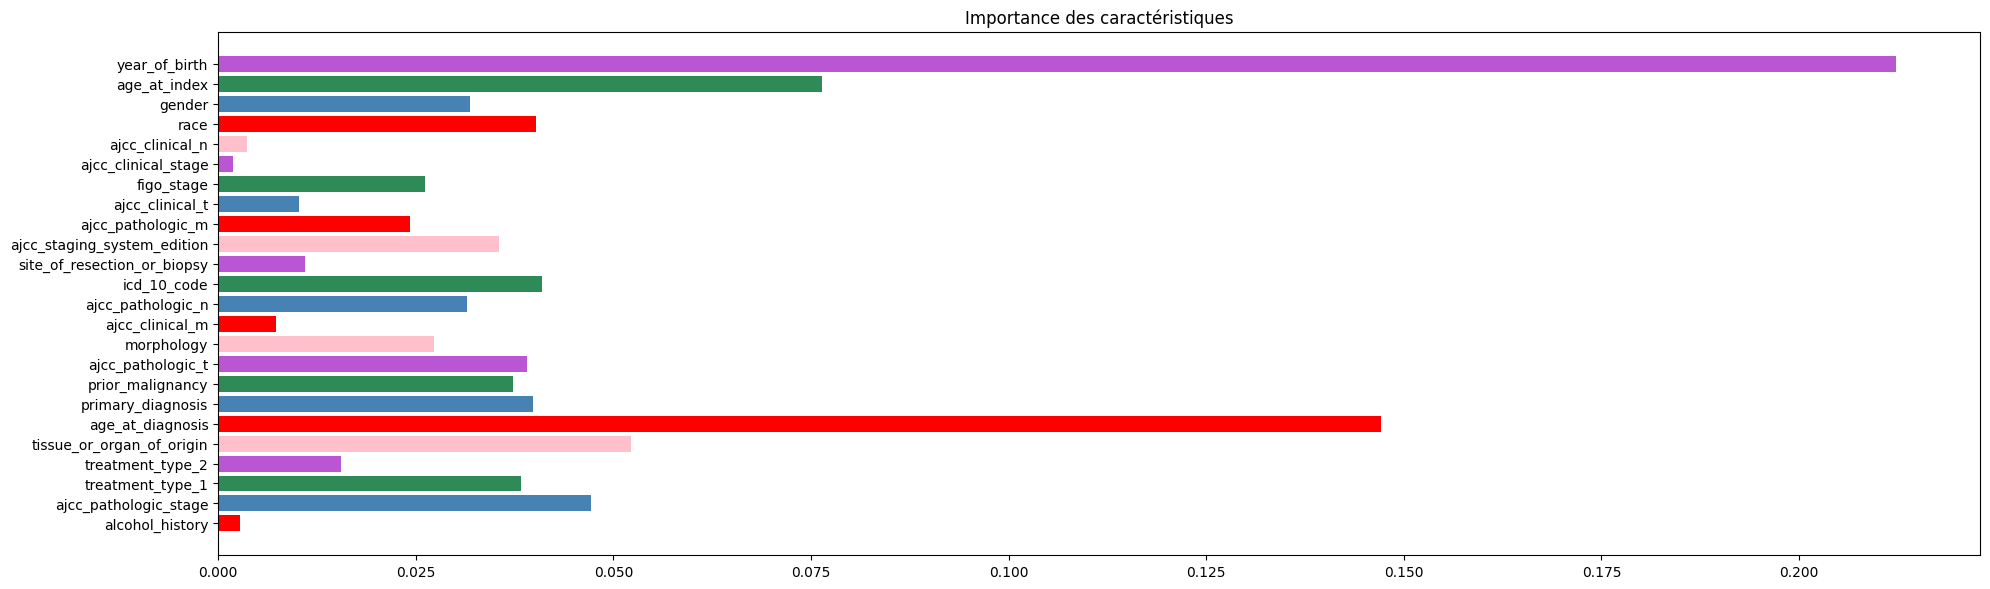

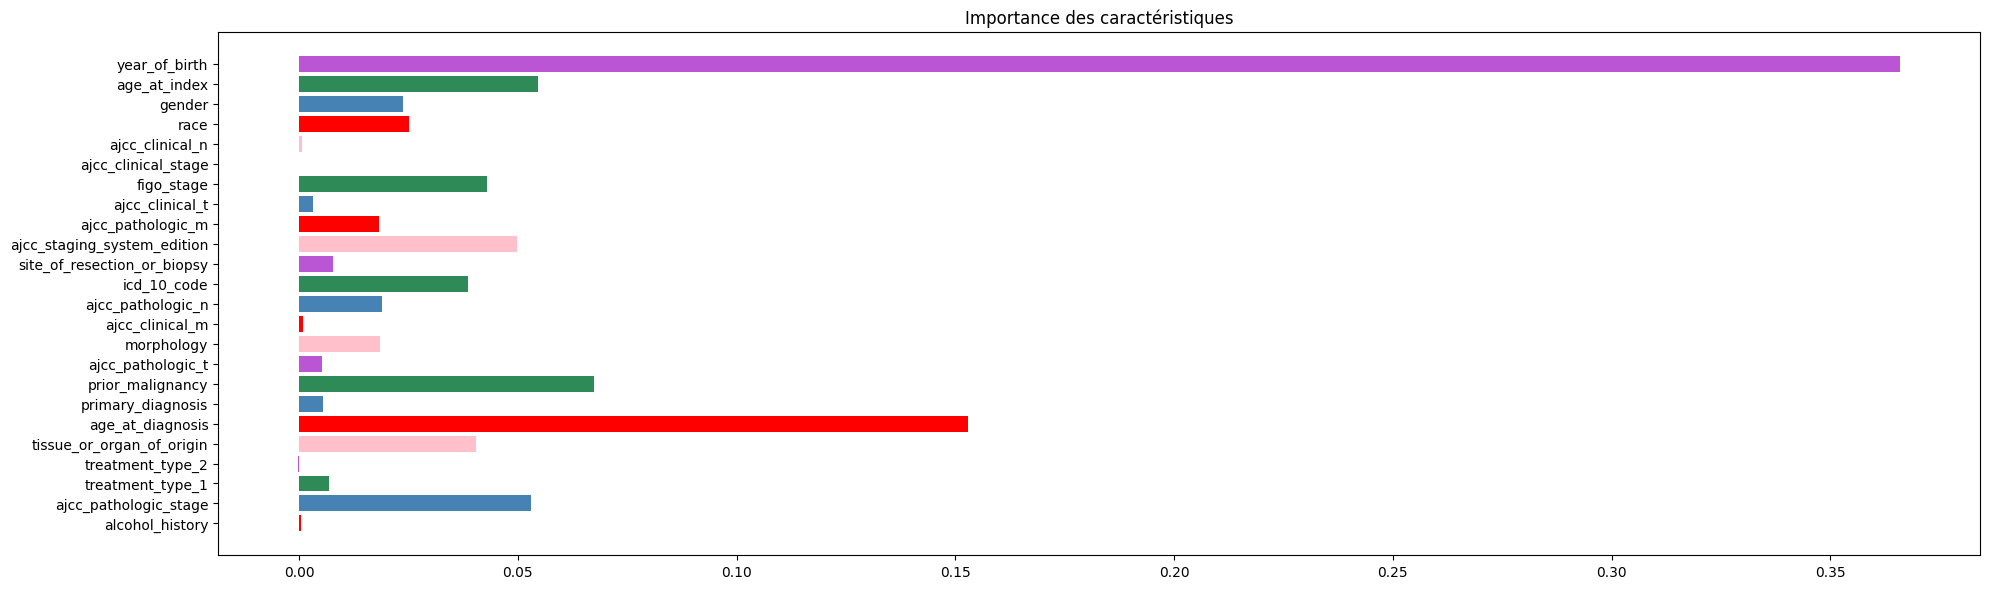

In [73]:
afficheImportanceCaracteristiques(importance_models_individuels[0], importance_models_individuels[1])
afficheImportanceCaracteristiques(importance_models_ensemble[0], importance_models_ensemble[1])

## **Explication des décisions prises par les modèles**

In [74]:
def calculateShapValues(models, X_train, y_train, X_test, type = "individual"):

    for model_name, model in models:
        model.fit(X_train, y_train)

        if type == "individual":
            explainer = shap.TreeExplainer(model)

        else :
            function = model.predict
            explainer = shap.KernelExplainer(function, X_train)

        shap_values = explainer.shap_values(X_test)

        print(model_name)
        shap.summary_plot(shap_values, X_test)

Random Forest


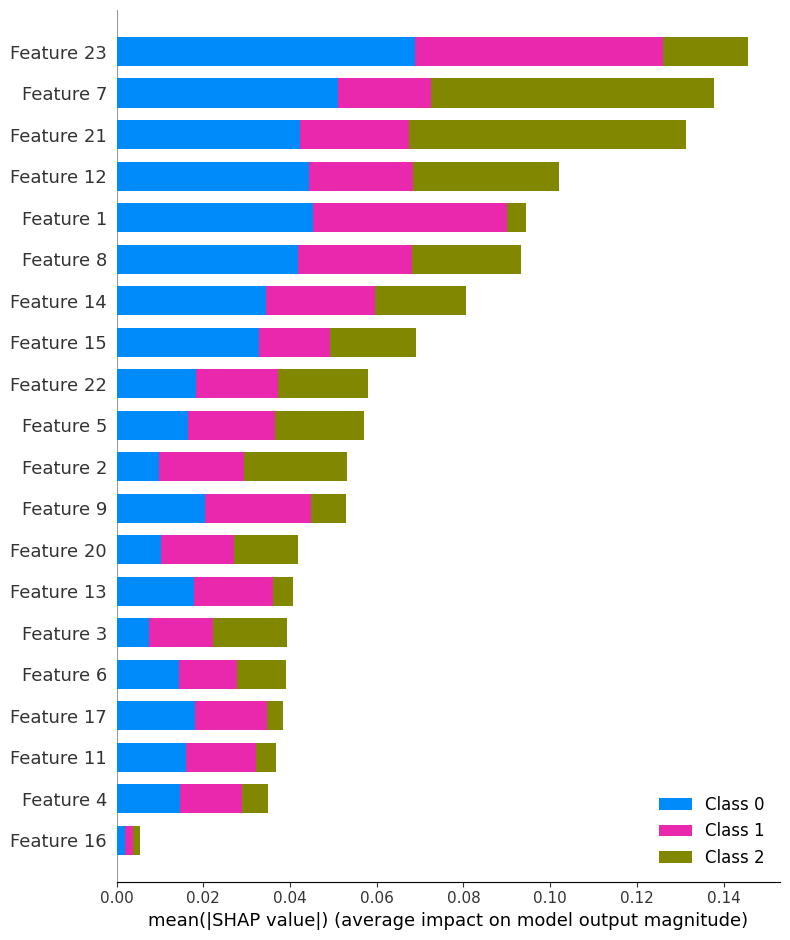

Extra Trees


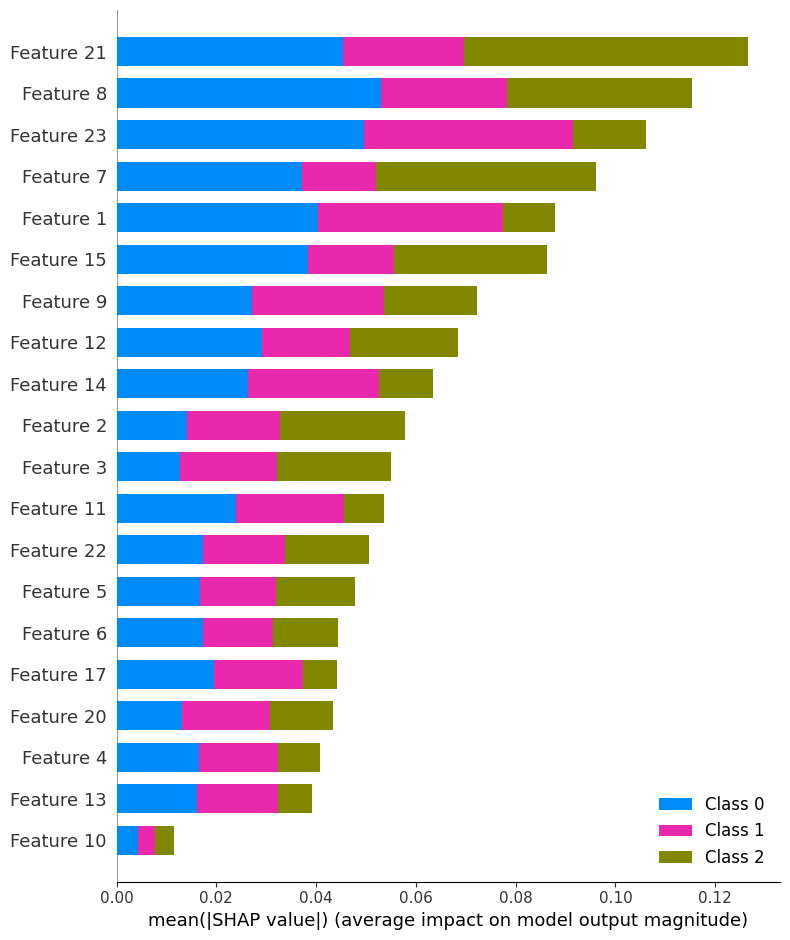

Decision Tree


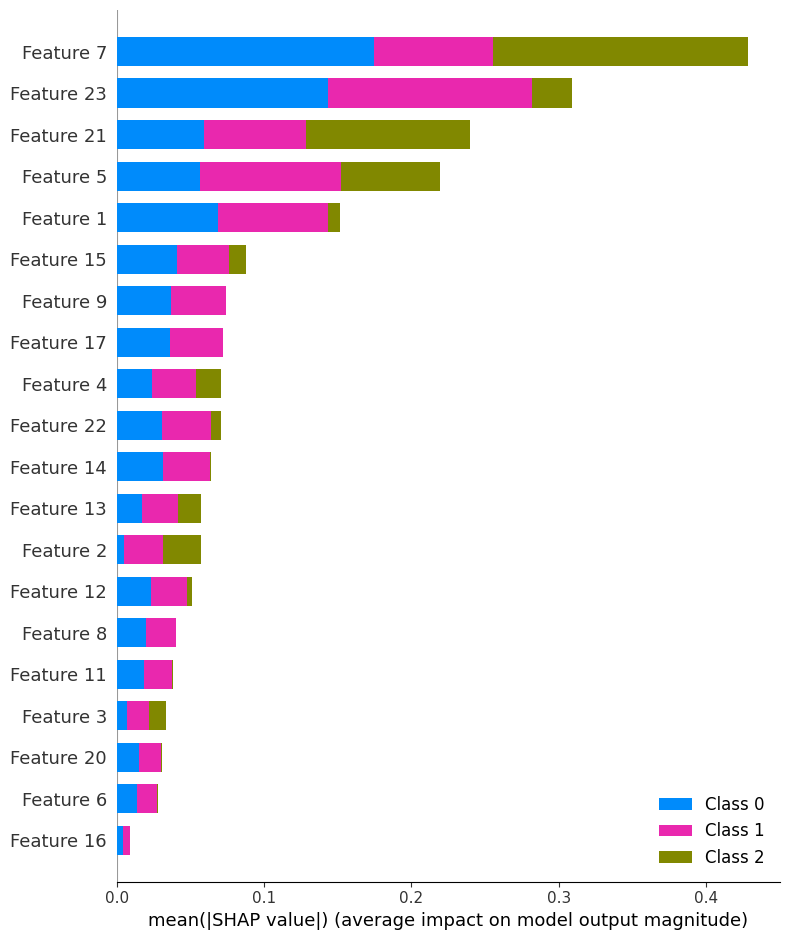

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
[18:11:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


XGBoost


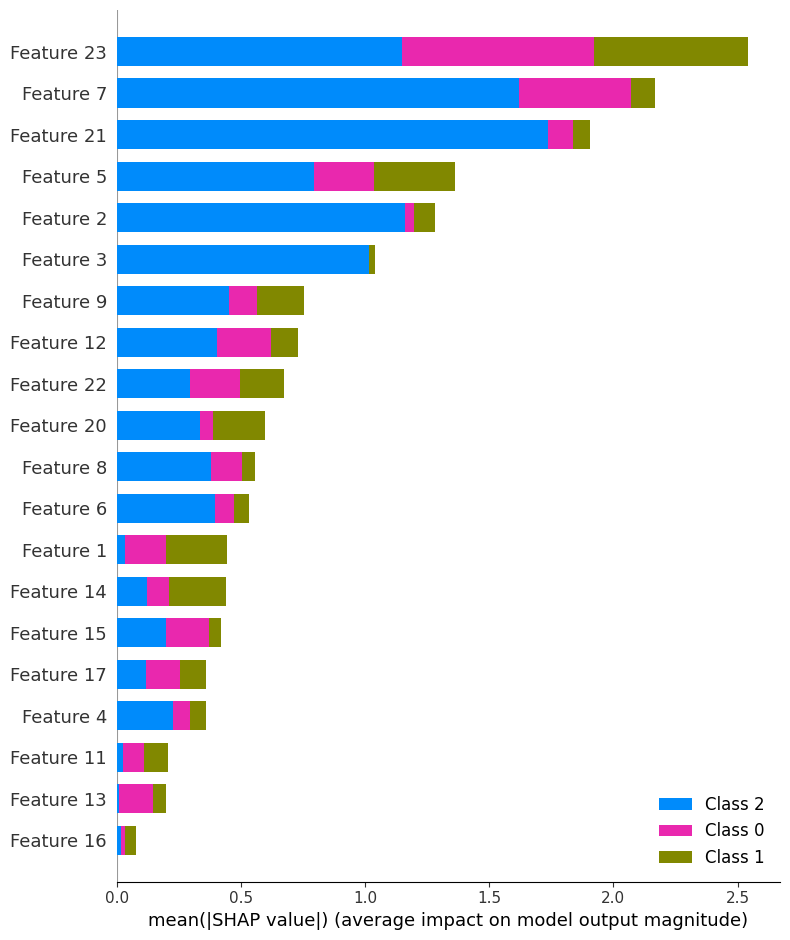

CatBoost


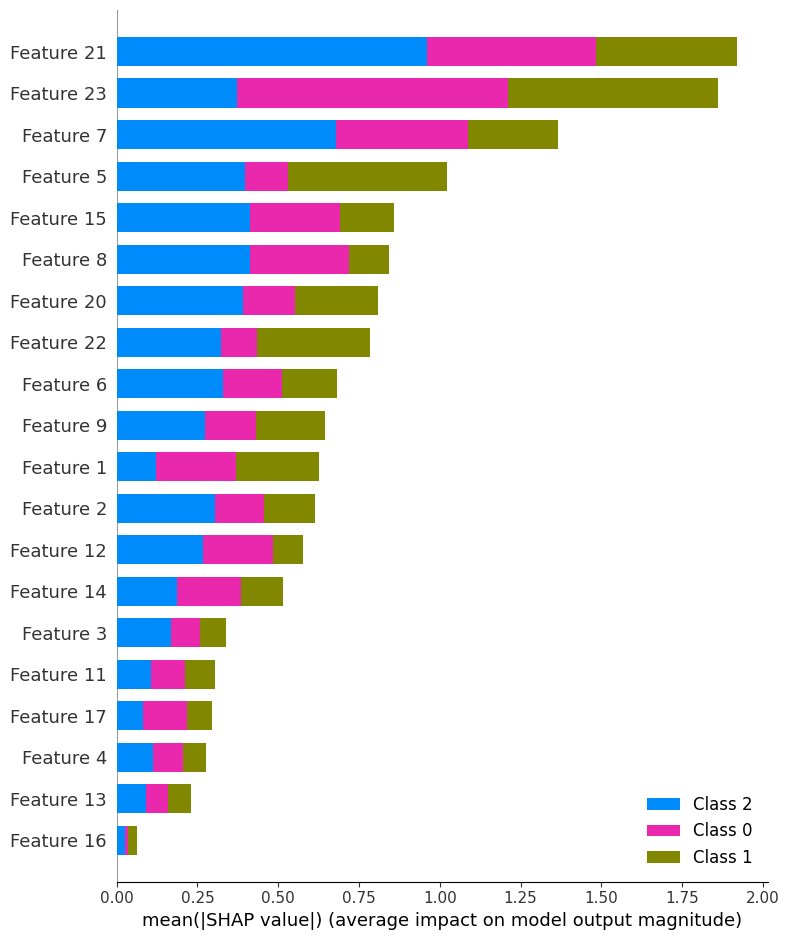

LightGBM


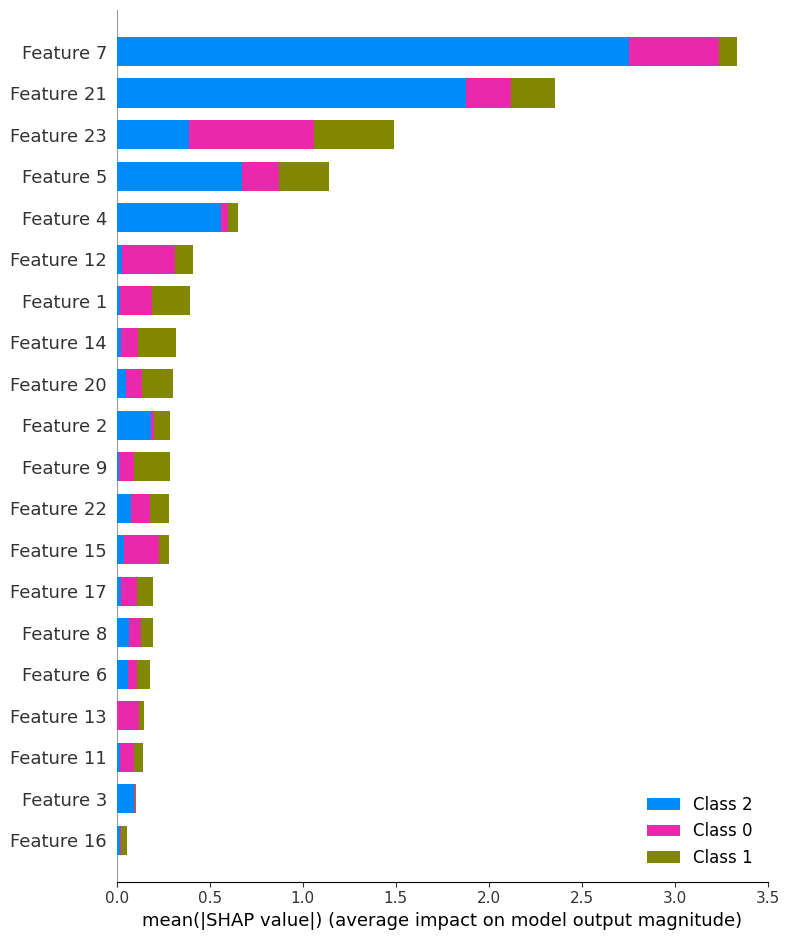

In [75]:
calculateShapValues(models_individuels, X_train_smote, y_train_smote, X_test)

In [76]:
# models_ensemble_ajustes = [
#     ("BaggingRegressor hyperparamètres", BaggingClassifier(estimator = lightgbm_tuned)),
#     ("StackingRegressor hyperparamètres", StackingClassifier(estimators = [('lightgbm_tuned', lightgbm_tuned)])),
#     ("VotingRegressor hyperparamètres", VotingClassifier(estimators = [('lightgbm_tuned', lightgbm_tuned)]))
# ]
# calculateShapValues(models_ensemble_ajustes, X_train_smote, y_train_smote, X_test, "ensemble")

## **Clustering**

### **K-means :**
* Regroupe les données disponibles en essayant de séparer les échantillons en K groupes de variance égale
* Minimiser le critère d' inertie (WCSS) ou somme des carrés intra-cluster
* Nécessite que le nombre de clusters soit spécifié
<br>

**Interprétation**
* Diminution à mesure que le nombre de clusters augmente
* Le nombre optimal de clusters est généralement choisi au niveau où la diminution du WCSS est moins significative
<br>
<br>

### **Modèle de mélange gaussien (GMM) :**
* Algorithme basé sur des distributions gaussiennes pour modéliser les clusters
* Utilisation de métriques tels que :
    * l'AIC (Critère d'information d'Akaike)
    * le BIC (Critère d'information bayésien)
* Ces mesures permettent de choisir le nombre optimal de clusters
<br>

**Interprétation**
* Diminution à mesure que le nombre de clusters augmente
* Préférable de choisir le nombre de clusters qui correspond au point le plus bas de ces courbes
<br>
<br>

### **DBSCAN (Density-Based Spatial Clustering of Applications with Noise) :**
* Algorithme basé sur la densité
* Coefficient de silhouette : métrique courante utilisée pour évaluer le nombre optimal de clusters
<br>
<br>

### **Clustering hierarchique :**
* La découpe du dendrogramme peut indiquer le nombre de clusters
* Utilisation de mesures comme :
    * l'indice de Calinski-Harabasz
    * l'indice Davies-Bouldin
<br>

**Interprétation**
* Augmentation à mesure que le nombre de clusters augmente
* Le nombre optimal de clusters est choisi en fonction du point où la fusion des clusters commence à être significativement élevée

In [77]:
def wcss(matrix, start, stop):
    wcss = []
    for i in range(start, stop):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter = 300, n_init = 10, random_state = SEED)
        kmeans.fit(matrix)
        wcss.append(kmeans.inertia_)
    return wcss

def gmm(matrix, start, stop):
    aic = []
    bic = []
    for i in range(start, stop):
        instance_gmm = GaussianMixture(n_components = i, random_state = SEED)
        instance_gmm.fit(matrix)
        aic.append(instance_gmm.aic(matrix))
        bic.append(instance_gmm.bic(matrix))
    return (aic, bic)

def hierarchical_metrics(matrix, start, stop):
    silhouette_scores = []
    for n_clusters in range(start, stop):
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(matrix)
        silhouette_scores.append(silhouette_score(matrix, labels))
    return silhouette_scores

In [78]:
def numberOfClusters(technique_name, technique_result, min, max):
    plt.figure(figsize=(8, 6))

    if len(technique_result) == 2 :
        plt.plot(range(1, len(technique_result[0]) + 1), technique_result[0], marker='o', linestyle='--', label='AIC')
        plt.plot(range(1, len(technique_result[1]) + 1), technique_result[1], marker='o', linestyle='--', label='BIC')
        plt.legend()
    else :
        plt.plot(range(1, len(technique_result) + 1), technique_result, marker='o', linestyle='--')

    plt.xlabel('Nombre de clusters')
    plt.ylabel('Valeurs')

    plt.title(f'Résultats de l\'algorithme de clustering {technique_name}')
    plt.show()

In [79]:
matrix = scaler.fit_transform(preprocessed_data)
start = 1
stop = 11

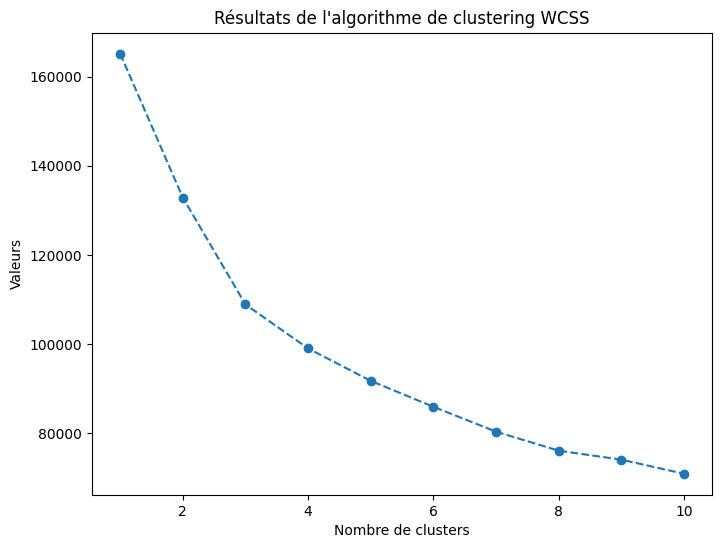

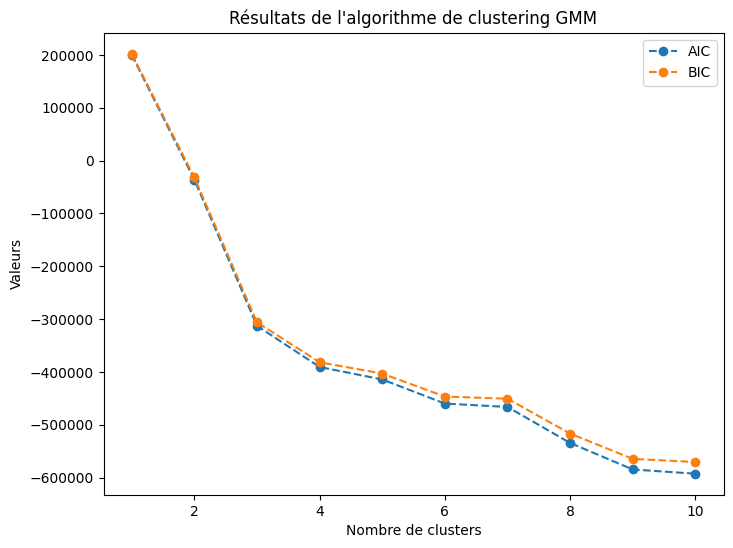

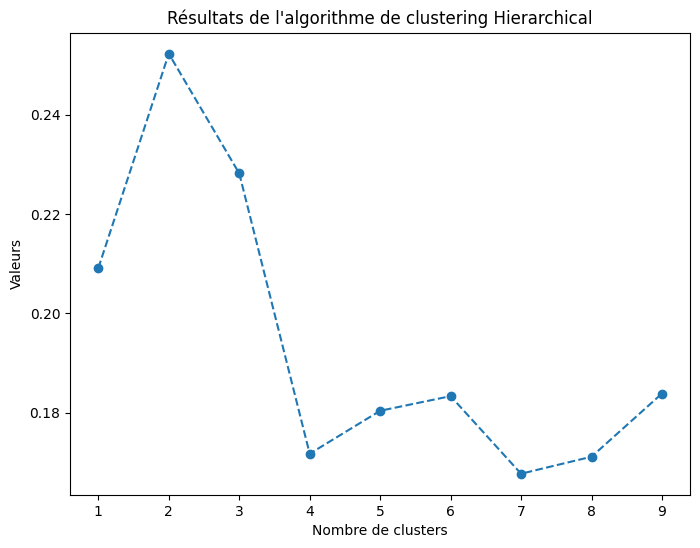

In [80]:
numberOfClusters(technique_name = 'WCSS', technique_result = wcss(matrix, start, stop), min = start, max = stop)
numberOfClusters(technique_name = 'GMM', technique_result = gmm(matrix, start, stop), min = start, max = stop)
numberOfClusters(technique_name = 'Hierarchical', technique_result = hierarchical_metrics(matrix, 2, stop), min = 2, max = stop)

### Remarques
**WCSS :** diminution marginale du WCSS autour de 4 clusters

**GMM :** le nombre de clusters correspond au point le plus bas de ces courbes aux alentours de 10 clusters

**Hierarchical :** la fusion des clusters semble augmenter plus rapidement autour de 2 clusters

## **Regroupement des données**

In [81]:
optimal_k_kmeans = 4
optimal_gmm = 10
optimal_clusters_hierarchical = 2

In [82]:
kmeans = KMeans(n_clusters = optimal_k_kmeans, init = 'k-means++', max_iter = 300, n_init = 10, random_state = SEED)
preprocessed_data['kmeans_cluster'] = kmeans.fit_predict(matrix)

gmm = GaussianMixture(n_components = optimal_gmm, random_state = SEED)
preprocessed_data['gmm_cluster'] = gmm.fit_predict(matrix)

hierarchical = AgglomerativeClustering(n_clusters = optimal_clusters_hierarchical, affinity = 'euclidean', linkage = 'ward')
preprocessed_data['hierarchical_cluster'] = hierarchical.fit_predict(matrix)

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


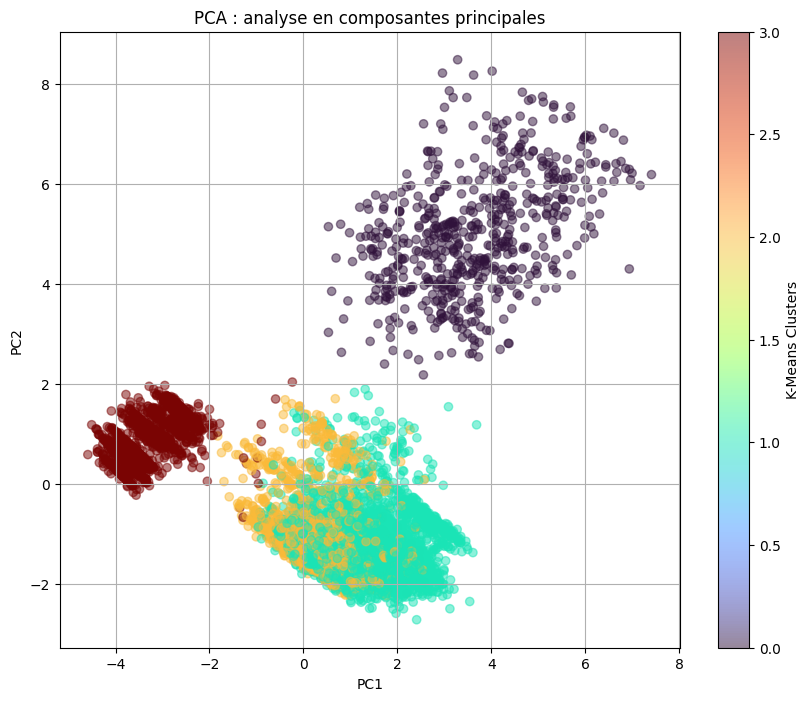

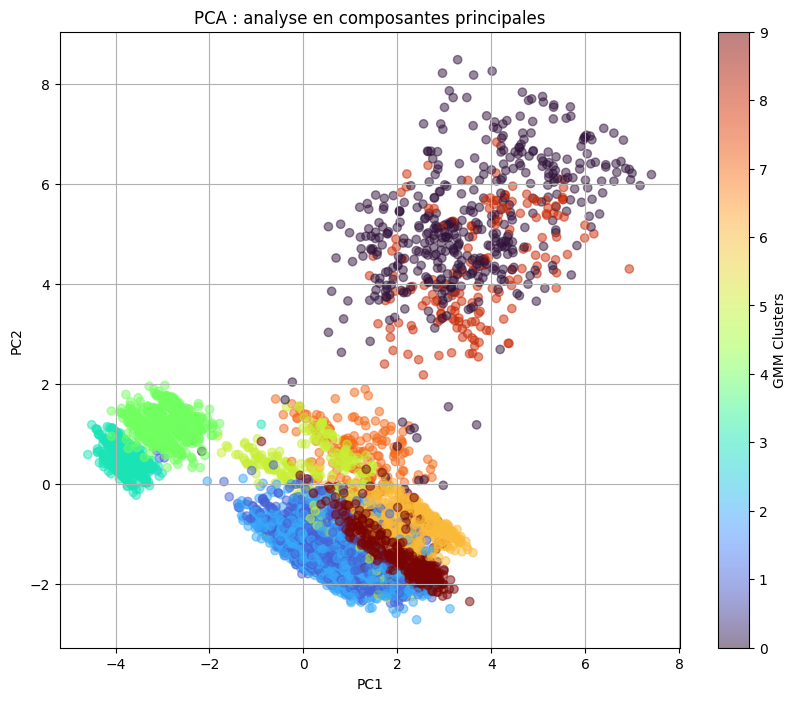

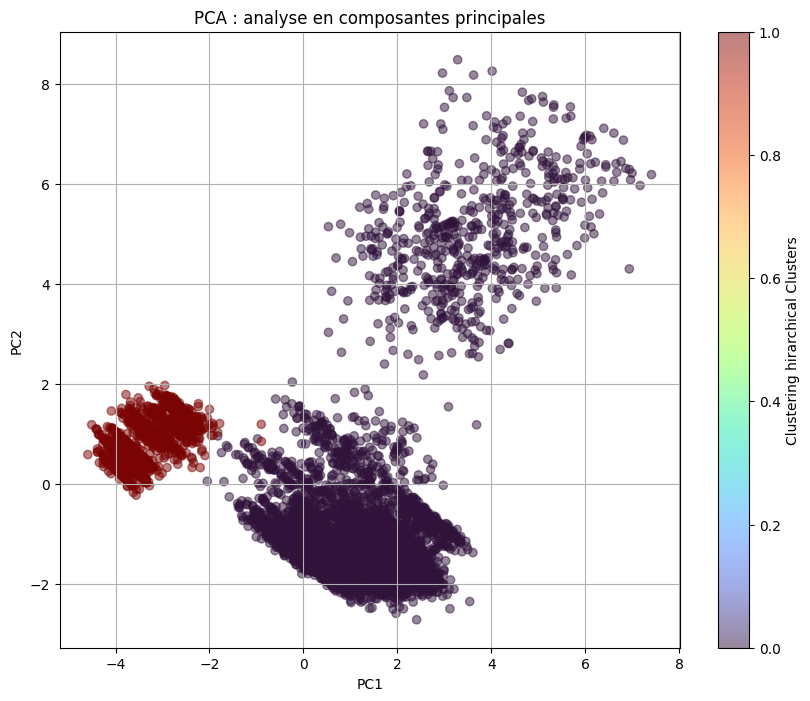

In [83]:
pca(n_components, matrix, preprocessed_data['kmeans_cluster'], "K-Means Clusters")
pca(n_components, matrix, preprocessed_data['gmm_cluster'], "GMM Clusters")
pca(n_components, matrix, preprocessed_data['hierarchical_cluster'], "Clustering hirarchical Clusters")

### Remarques :

In [84]:
silhouette_avg = silhouette_score(matrix, preprocessed_data['kmeans_cluster'])
print(f"Score de Silhouette K-Means : {silhouette_avg}")


silhouette_avg = silhouette_score(matrix, preprocessed_data['gmm_cluster'])
print(f"Score de Silhouette GMM : {silhouette_avg}")


silhouette_avg = silhouette_score(matrix, preprocessed_data['hierarchical_cluster'])
print(f"Score de Silhouette Hierarchical Clustering : {silhouette_avg}")

Score de Silhouette K-Means : 0.18725975978284698
Score de Silhouette GMM : 0.19180159679054773
Score de Silhouette Hierarchical Clustering : 0.20911054602365378


### Remarques :

* Un score plus élevé indique une meilleure cohésion intra-cluster et une meilleure séparation inter-cluster. Cela implique une meilleure qualité de regroupement.
* Ici K-Means a le meilleure résultat.

In [85]:
dbi_score = davies_bouldin_score(matrix, preprocessed_data['kmeans_cluster'])
print(f"Indice Davies-Bouldin pour K-Means : {dbi_score}")

dbi_score = davies_bouldin_score(matrix, preprocessed_data['gmm_cluster'])
print(f"Indice Davies-Bouldin pour GMM : {dbi_score}")

dbi_score = davies_bouldin_score(matrix, preprocessed_data['hierarchical_cluster'])
print(f"Indice Davies-Bouldin pour Hierarchical Clustering : {dbi_score}")

Indice Davies-Bouldin pour K-Means : 1.852091273451854
Indice Davies-Bouldin pour GMM : 1.788485337501727
Indice Davies-Bouldin pour Hierarchical Clustering : 1.6552762293530185


### Remarques :

* Un score moins élevé indique une bonne qualité de regroupement.
* Ici aussi K-Means a le meilleur résultat.

## **Clustering hierarchique**

* **Liaison simple (Single Linkage) :** Distance entre deux clusters = distance la plus courte entre les éléments de deux clusters respectifs --> créer des clusters allongés ou chaînés, sensibles au bruit et aux valeurs aberrantes
* **Liaison complète (Complete Linkage) :** Distance entre deux clusters = distance la plus longue entre les éléments de deux clusters respectifs --> former des clusters plus compacts, mieux définis et moins sensibles aux valeurs aberrantes

**Interprétation des résultats avec les dendrogrammes :**
* Observation de la structure des clusters formés à différentes distances
* Comparaison des deux dendrogrammes pour comprendre comment les différents liens (single et complete) influent sur la formation des clusters
* Focalisation sur la compacité, la séparation et la sensibilité aux valeurs aberrantes des clusters générés par les deux méthodes de liaison

In [86]:
def hierarchicalClustering(data, method):
    return linkage(data, method = method)

In [87]:
def graphHierarchicalClustering(data, type_liaison):
    plt.figure(figsize=(12, 4))
    dendrogram(data)
    plt.xlabel('Indice des échantillons')
    plt.ylabel('Distance')
    plt.title(f'Dendrogramme avec liaison {type_liaison}')
    plt.show()

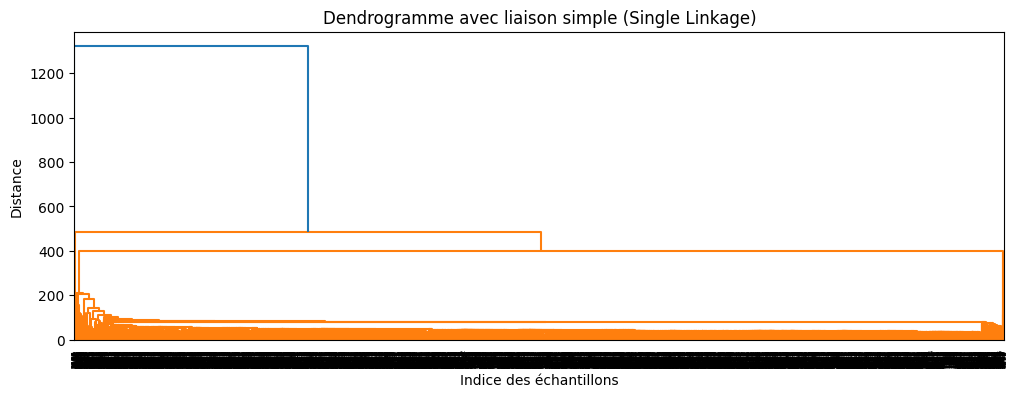

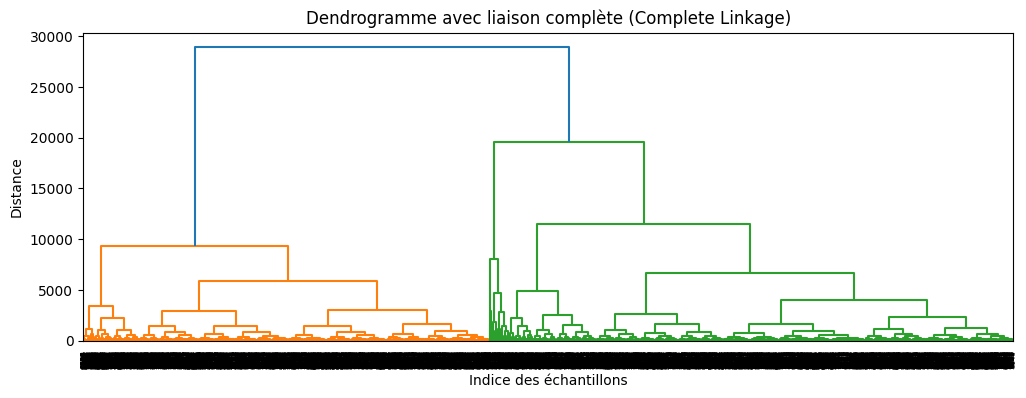

In [88]:
reduced_data = PCA().fit_transform(preprocessed_data)
Z_single = hierarchicalClustering(reduced_data, 'single')
Z_complete = hierarchicalClustering(reduced_data, 'complete')

graphHierarchicalClustering(Z_single, 'simple (Single Linkage)')
graphHierarchicalClustering(Z_complete, 'complète (Complete Linkage)')

### Avantages GMM par rapport à K-Means :

* Analyse des données complexes et mixtes
* Gère plus facilement les valeurs aberrantes

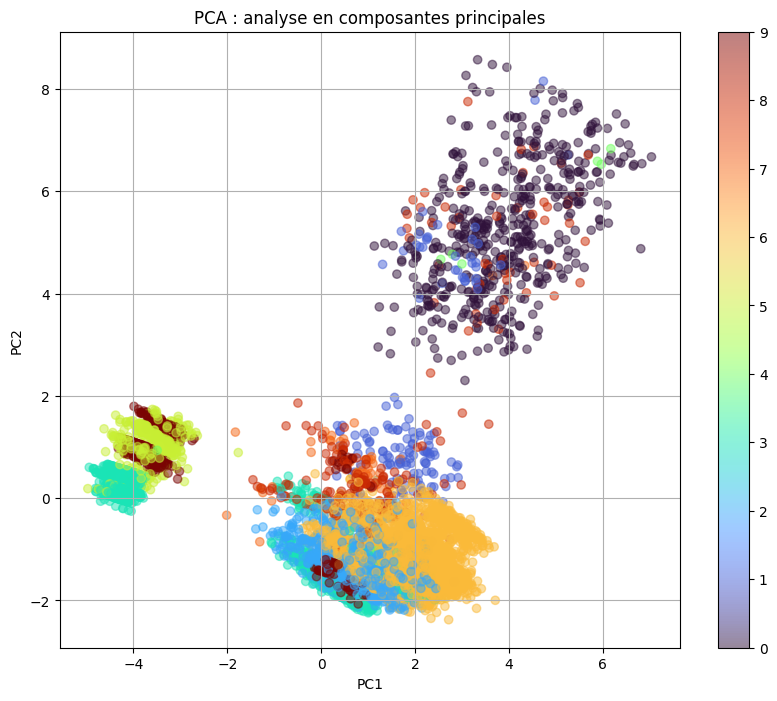

Poids des composants :  [0.07235217 0.02193809 0.10322442 0.24243539 0.00319628 0.0482096
 0.32238849 0.01002486 0.02905696 0.14717374]

Moyennes des composants :
[[1.30321287e+00 9.94176693e+00 5.18072273e-01 4.81927727e-01
  3.90040182e+01 2.24199991e+04 6.15642617e+01 0.00000000e+00
  9.93775044e+00 1.09518028e+01 3.21285171e-02 7.52811421e+00
  1.98614417e+01 4.00602432e+01 4.73895580e+00 3.94979979e+00
  4.64859382e+00 1.80000000e+01 6.03614454e+00 1.49598408e+00
  4.61646576e+00 7.24899559e-01 6.08946957e+01 1.94694352e+03
  0.00000000e+00 2.44176730e+00 0.00000000e+00]
 [1.01986643e+00 6.60926673e+00 4.83443168e-01 5.16556832e-01
  2.60529503e+01 2.63264330e+04 6.17549500e+01 4.23839079e-01
  1.00993455e+01 2.32583091e+01 3.84106289e+00 5.29800147e+00
  6.49007153e+01 2.65496384e+01 4.79470181e+00 1.94701261e+00
  3.36424342e+00 1.80000000e+01 1.06291490e+01 6.91391320e+00
  4.61589395e+00 6.95364021e-01 7.15827704e+01 1.93923842e+03
  7.68212578e-01 5.37748804e+00 0.00000000e+0

In [89]:
gmm = GaussianMixture(n_components = optimal_gmm, random_state=SEED)
labels = gmm.fit_predict(preprocessed_data)

pca(2, preprocessed_data, labels, "")

print("Poids des composants : ", gmm.weights_)
print("\nMoyennes des composants :")
print(gmm.means_)
print("\nCovariances des composants :")
print(gmm.covariances_)

## **Clustering basé sur la densité**

### **Avantages de DBSCAN :**

* Détection automatique du nombre de clusters : DBSCAN peut détecter automatiquement le nombre de clusters dans les données sans que vous ayez à spécifier ce nombre à l'avance.
* Capacité à gérer des clusters de formes et de densités variables : DBSCAN est efficace pour détecter des clusters de formes arbitraires et de densités variables.
* Identification des points de bruit : DBSCAN peut identifier les points de bruit, ce qui est utile pour la détection d'anomalies.
Pas de nécessité de pré-normalisation : Les données n'ont pas besoin d'être normalisées avant d'appliquer DBSCAN.

### **Inconvénients de DBSCAN :**

* Sensibilité aux hyperparamètres : Le choix des valeurs d'epsilon (eps) et du nombre minimum d'échantillons (min_samples) peut influencer les résultats, et leur réglage peut être délicat.
* Difficulté avec des clusters de densités similaires : DBSCAN peut avoir du mal à distinguer des clusters de densités similaires.
* Complexité en temps : DBSCAN peut être coûteux en termes de temps de calcul pour des ensembles de données très volumineux.

In [90]:
dbscan = DBSCAN(eps = 9000, min_samples = 123)
dbscan_labels = dbscan.fit_predict(reduced_data)

neigh = NearestNeighbors()
neigh.fit(reduced_data)
distances, _ = neigh.kneighbors(reduced_data)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

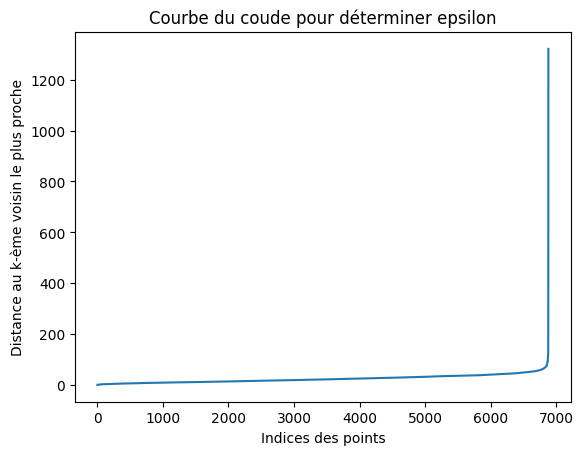

In [91]:
plt.plot(distances)
plt.xlabel('Indices des points')
plt.ylabel(f'Distance au k-ème voisin le plus proche')
plt.title('Courbe du coude pour déterminer epsilon')
plt.show()

In [92]:
def find_optimal_dbscan_parameters(data, eps_values, min_samples_values):
    optimal_eps = None
    optimal_min_samples = None
    optimal_score = -1

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps = eps, min_samples = min_samples)
            labels = dbscan.fit_predict(data)

            if len(set(labels)) > 1:
                score = silhouette_score(data, labels)
                if score > optimal_score:
                    optimal_eps = eps
                    optimal_min_samples = min_samples
                    optimal_score = score

    return optimal_eps, optimal_min_samples, optimal_score

In [93]:
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]

optimal_eps, optimal_min_samples, optimal_score = find_optimal_dbscan_parameters(matrix, eps_values, min_samples_values)

print(f"Optimal Epsilon: {optimal_eps}")
print(f"Optimal Min Samples : {optimal_min_samples}")
print(f"Optimal Silhouette Score : {optimal_score}")

Optimal Epsilon: 0.5
Optimal Min Samples : 15
Optimal Silhouette Score : -0.05407114419377961
